In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../..')

In [3]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from stack_segmentation.stack import Stack

In [5]:
from stack_segmentation.aug_pipelines import medium_aug
from stack_segmentation.io import make_dataloader, collate_fn_basic
from stack_segmentation.training import handle_stacks_data, make_model, train_loop
from stack_segmentation.unet import UNet
from stack_segmentation.pipeline_config import dataloaders_conf, model_conf, train_conf

In [6]:
from exp_config import data_conf

## Prepare train, validation and test data

In [7]:
data_train, data_val, data_test = handle_stacks_data(**data_conf)

720it [00:01, 690.80it/s]
100%|██████████| 720/720 [00:07<00:00, 91.02it/s] 
8280it [00:00, 249084.37it/s]
7920it [00:00, 227590.54it/s]
720it [00:00, 856.26it/s]
100%|██████████| 720/720 [00:07<00:00, 94.81it/s] 
8280it [00:00, 246669.44it/s]
720it [00:00, 848.90it/s]
100%|██████████| 720/720 [00:07<00:00, 94.61it/s] 
8280it [00:00, 83800.26it/s]
700it [00:00, 898.41it/s]
100%|██████████| 700/700 [00:06<00:00, 100.41it/s]
8280it [00:00, 249966.44it/s]
509it [00:00, 1244.00it/s]
100%|██████████| 509/509 [00:02<00:00, 198.88it/s]
3664it [00:00, 245505.85it/s]
700it [00:00, 904.80it/s]
100%|██████████| 700/700 [00:06<00:00, 100.67it/s]
8280it [00:00, 244824.44it/s]
700it [00:00, 826.18it/s]
100%|██████████| 700/700 [00:06<00:00, 100.56it/s]
8280it [00:00, 252632.16it/s]
710it [00:01, 417.65it/s]
100%|██████████| 710/710 [00:07<00:00, 97.97it/s] 
8280it [00:00, 251446.88it/s]
710it [00:01, 421.67it/s]
100%|██████████| 710/710 [00:07<00:00, 98.76it/s] 
8280it [00:00, 247127.57it/s]
710it [

In [8]:
len(data_train), len(data_val), len(data_test)

(8280, 7920, 11)

In [9]:
dataloader_train = make_dataloader(
    samples=data_train, 
    collate_fn=collate_fn_basic,
    **dataloaders_conf['train']
)

dataloader_val = make_dataloader(
    samples=data_val, 
    collate_fn=collate_fn_basic,
    **dataloaders_conf['val']
)

dataloaders_test = {
    name: make_dataloader(
        samples=data, 
        collate_fn=collate_fn_basic,
        **dataloaders_conf['test']
    ) for name, data in data_test.items()}

## Create model and metrics

In [10]:
from stack_segmentation.metrics import accuracy, precision, recall, f1, pr_auc, iou

In [11]:
metrics = {
    'accuracy': accuracy, 
    'precision': precision, 
    'recall': recall, 
    'f1': f1,
    'pr_auc': pr_auc, 
    'iou': iou,
}

In [12]:
model_conf

{'device': 'cuda:0',
 'weight': [1, 10],
 'loss': [('BCE', 0.5), ('Dice', 0.5)],
 'lr': 0.0001,
 'min_lr': 1e-06,
 'weight_decay': 5e-05,
 'factor': 0.5,
 'patience': 5}

In [13]:
model, criterion, optimizer, scheduler = make_model(**model_conf)

## Run experiment

In [ ]:
results = train_loop(
    model=model,
    dataloader_train=dataloader_train, 
    dataloader_val=dataloader_val,
    dataloaders_test=dataloaders_test,
    criterion=criterion, 
    optimizer=optimizer, 
    scheduler=scheduler,
    metrics=metrics,
    exp_name=data_conf['conf_name'],
    **train_conf)

  0%|          | 0/259 [00:00<?, ?it/s]

Epoch 0...


 19%|█▉        | 50/259 [00:11<00:41,  5.00it/s]

## Dump experiment results

In [ ]:
import pickle
import json

In [ ]:
p = './{}_exp_results.pkl'.format(data_conf['conf_name'])
with open(p, 'wb') as f:
    pickle.dump(results, f)

In [10]:
# p = './{}_exp_results.pkl'.format(data_conf['conf_name'])
# with open(p, 'rb') as f:
#     results = pickle.load(f)

In [11]:
import torch
model.load_state_dict(torch.load('./{}.pt'.format(data_conf['conf_name'])))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

## Train and validation losses

In [11]:
from itertools import chain

In [12]:
train_losses = list(chain(*[item for item in results['train_losses']]))
val_losses = list(chain(*[item for item in results['val_losses']]))

In [19]:
def moving_average(a, n=5) :
    ret = np.cumsum([a[0]] * (n - 1) + a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

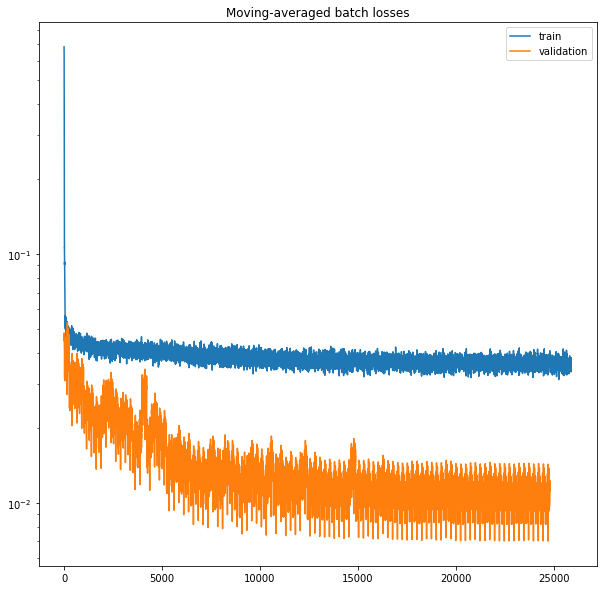

In [20]:
plt.figure(figsize=(10, 10))
plt.title('Moving-averaged batch losses')
plt.plot(np.arange(len(train_losses)), moving_average(train_losses), label='train')
plt.plot(np.arange(len(val_losses)), moving_average(val_losses), label='validation')

plt.legend(loc='best')
plt.yscale('log')

# plt.ylim([1e-2, 1])
plt.show()

In [15]:
mean_train_loss = [np.mean(item) for item in results['train_losses']]
mean_val_loss = [np.mean(item) for item in results['val_losses']]

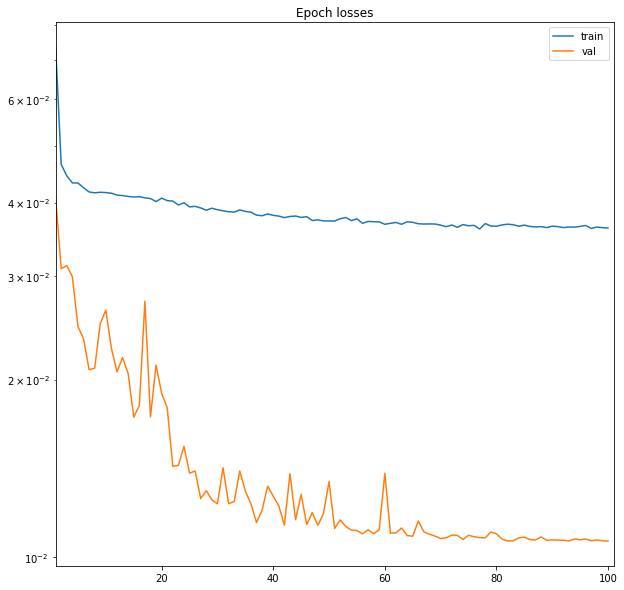

In [22]:
plt.figure(figsize=(10, 10))
plt.title('Epoch losses')
plt.plot(np.arange(len(mean_train_loss)) + 1, mean_train_loss, label='train')
plt.plot(np.arange(len(mean_val_loss)) + 1, mean_val_loss, label='val')

plt.yscale('log')
plt.legend(loc='best')

plt.xlim([1, len(mean_train_loss) + 1])
plt.show()

In [16]:
min(mean_val_loss)

0.010628432

## Predicted samples

In [23]:
import os

In [24]:
import torch

In [25]:
from visualization_utils import output_to_binary, plot_sample

In [26]:
threshold = 0.5
to_plot = 10
device = model_conf['device']

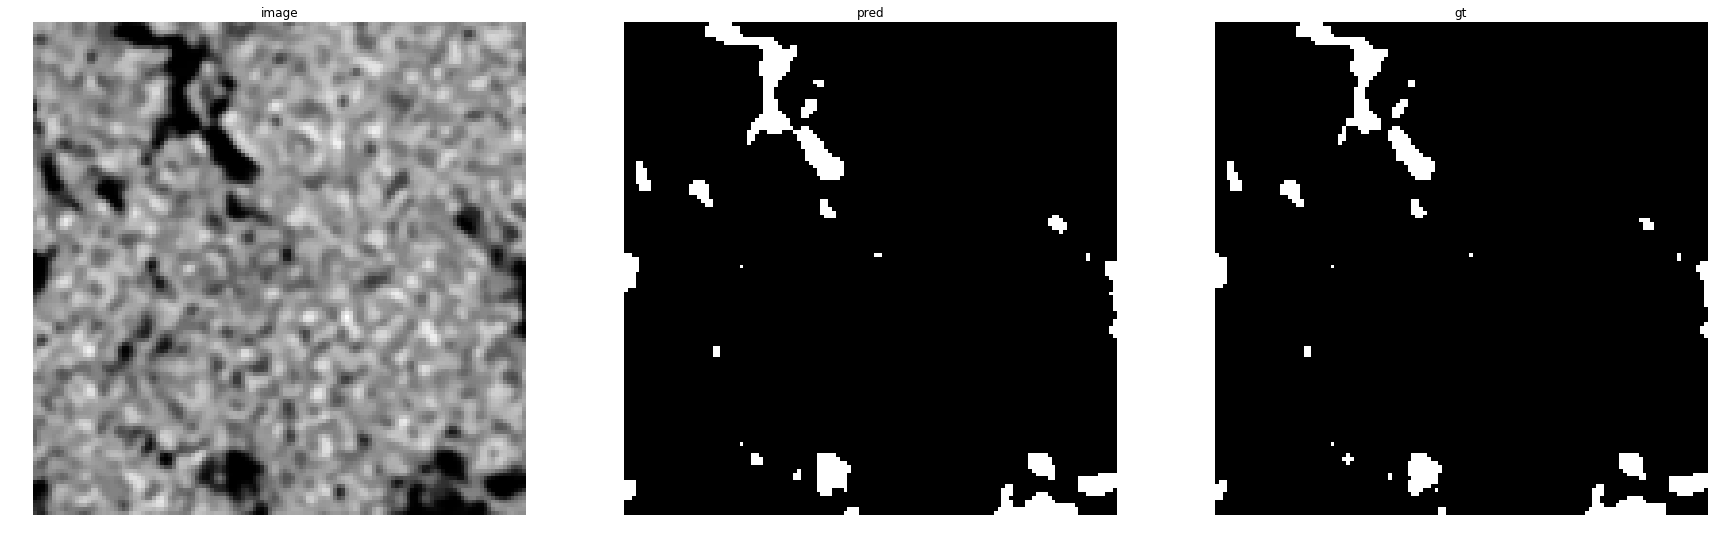

accuracy    : 0.99517822265625
precision   : 0.8961892247043364
recall      : 1.0
f1          : 0.9452529452529452
pr_auc      : 0.9970707250124493
iou         : 0.8961892247043364


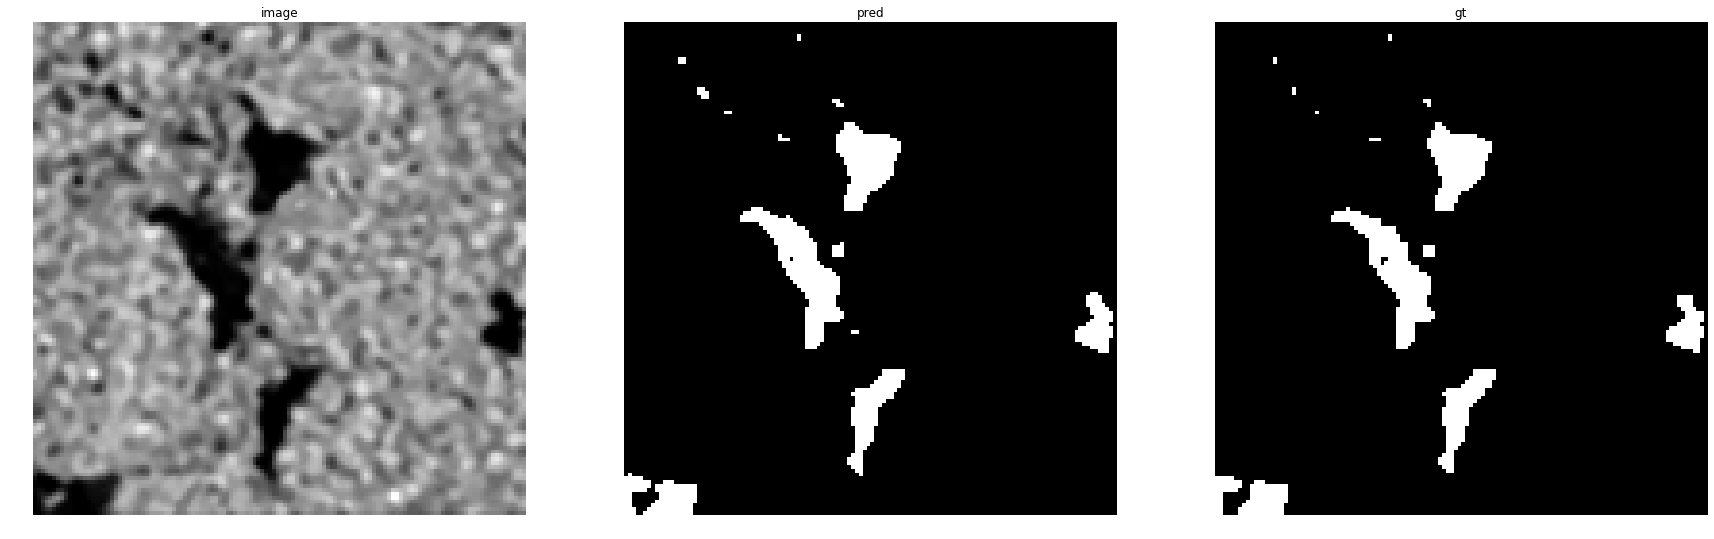

accuracy    : 0.996826171875
precision   : 0.9495459132189707
recall      : 0.9978791092258749
f1          : 0.9731127197518097
pr_auc      : 0.9988145102681234
iou         : 0.9476334340382678


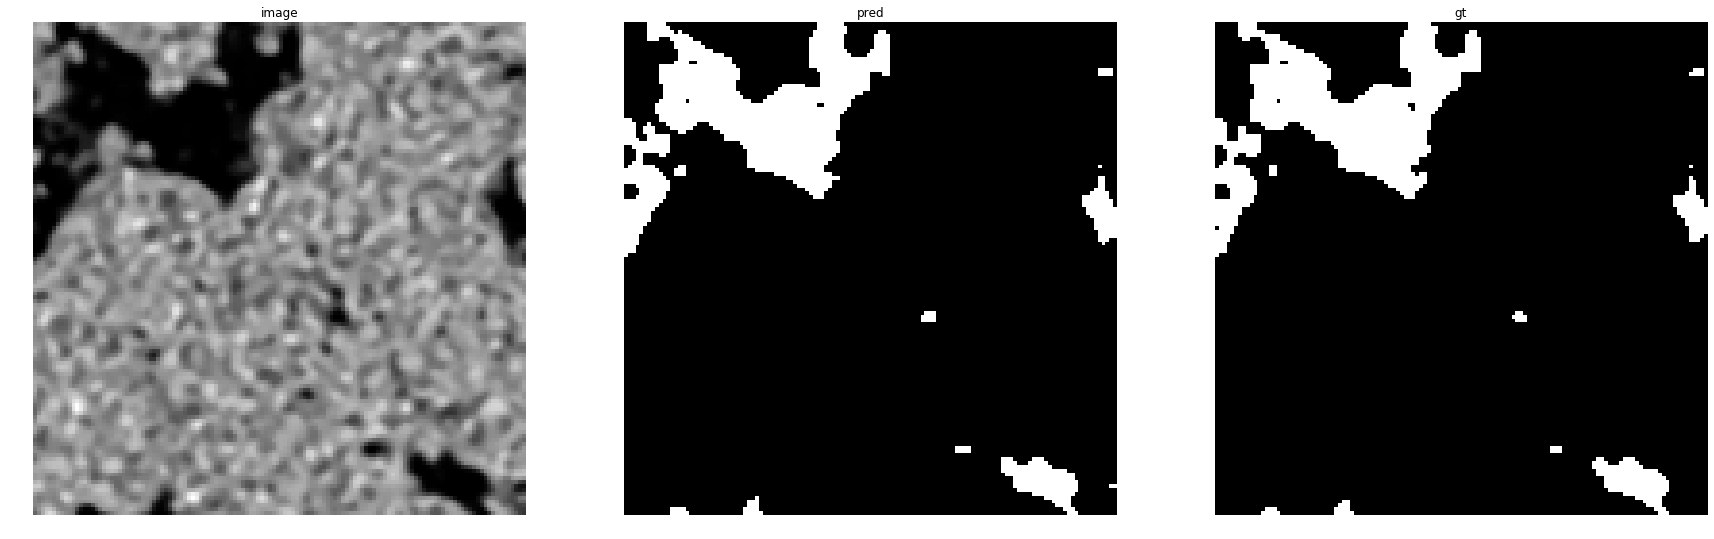

accuracy    : 0.99554443359375
precision   : 0.9629430719656283
recall      : 0.9977740678909294
f1          : 0.9800491937687893
pr_auc      : 0.9994126332895037
iou         : 0.9608788853161844


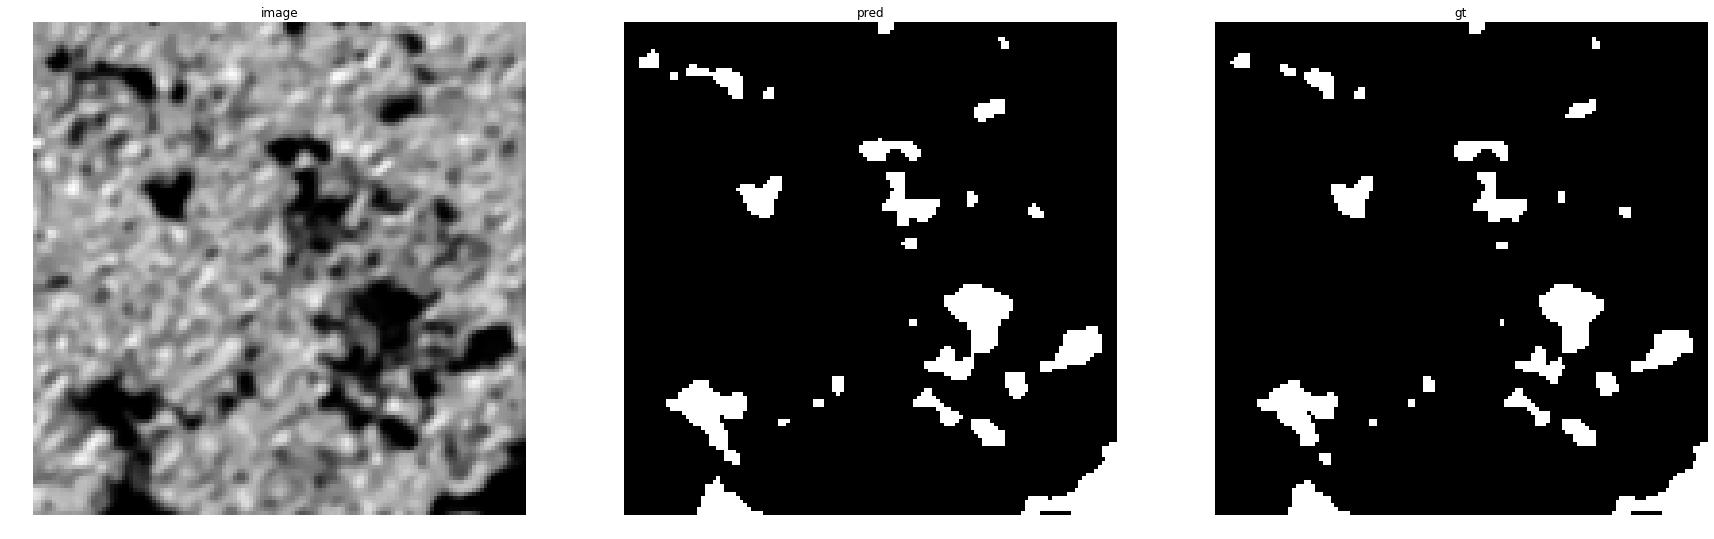

accuracy    : 0.99212646484375
precision   : 0.9122434536447275
recall      : 0.9961360123647605
f1          : 0.9523457702253417
pr_auc      : 0.997309406742014
iou         : 0.9090267983074753


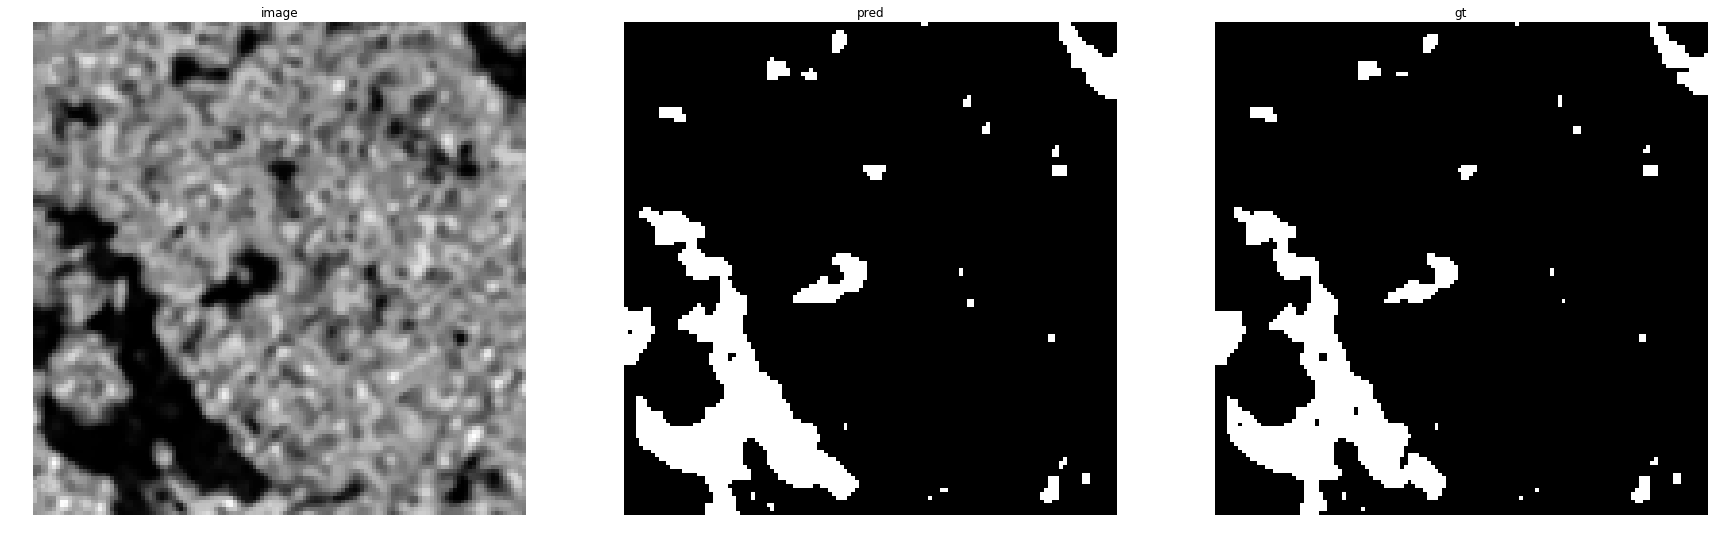

accuracy    : 0.99114990234375
precision   : 0.9264179867143587
recall      : 0.9994487320837927
f1          : 0.9615486608326704
pr_auc      : 0.9981910617349697
iou         : 0.9259448416751788


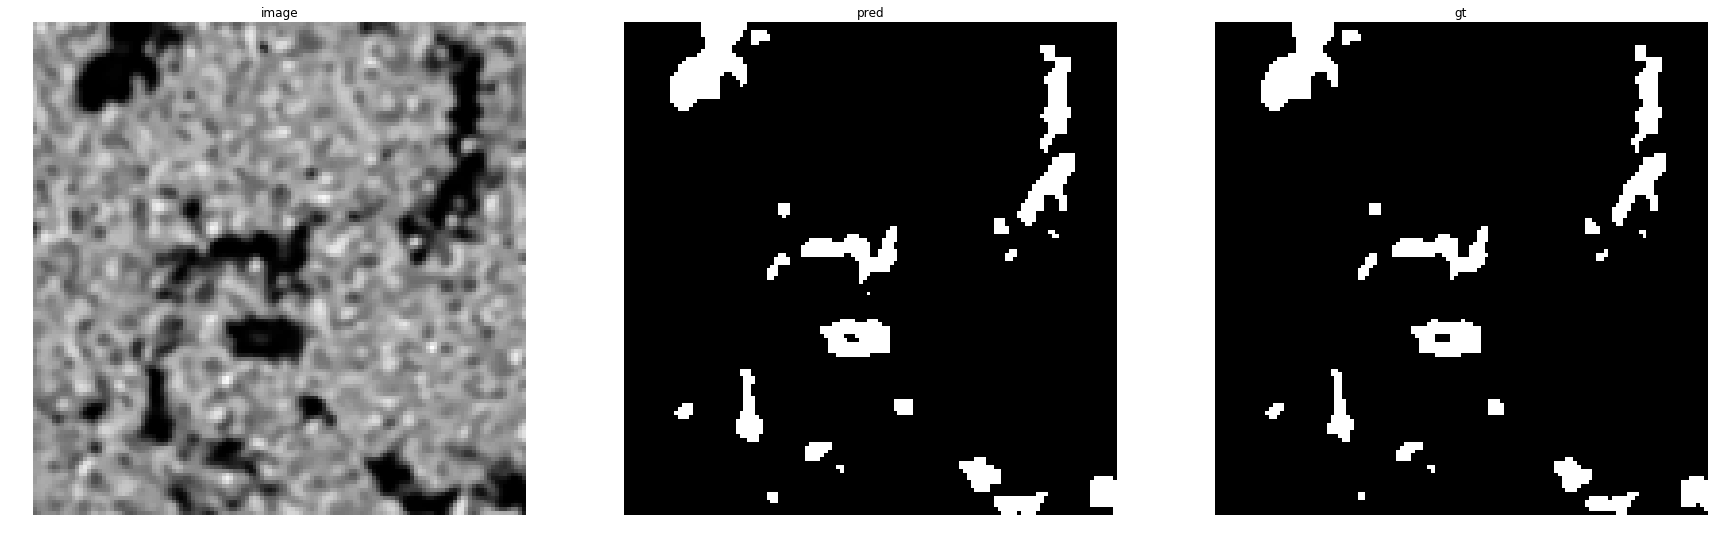

accuracy    : 0.99407958984375
precision   : 0.923013923013923
recall      : 0.9973451327433628
f1          : 0.9587409612930669
pr_auc      : 0.9977802121690034
iou         : 0.920751633986928


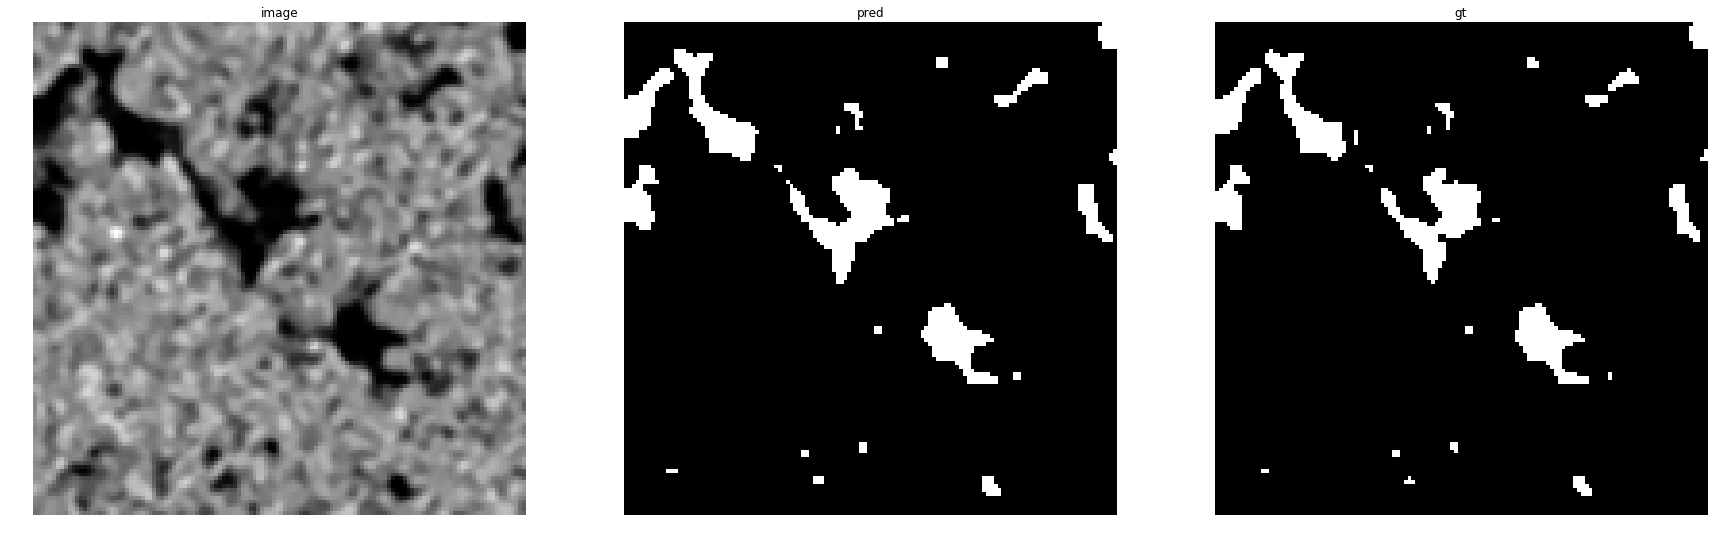

accuracy    : 0.99395751953125
precision   : 0.9197584124245038
recall      : 0.9944029850746269
f1          : 0.9556252801434334
pr_auc      : 0.9978157280653082
iou         : 0.9150214592274678


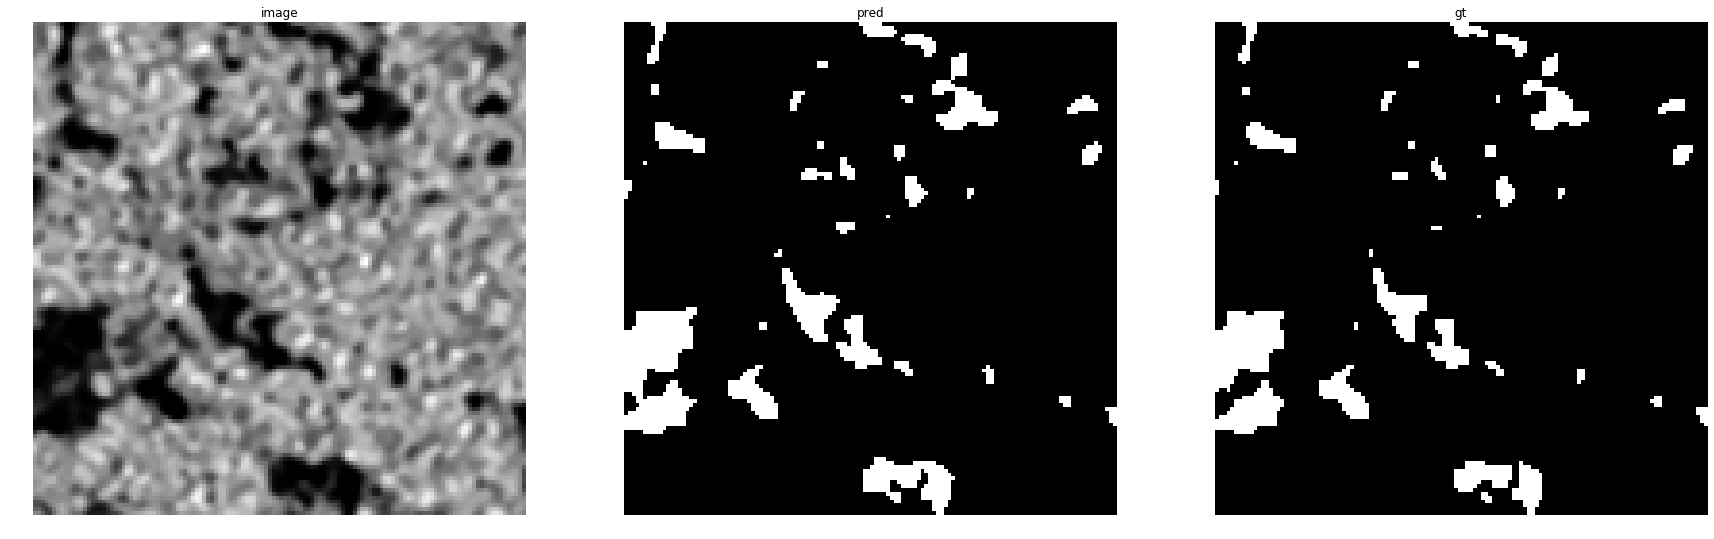

accuracy    : 0.99072265625
precision   : 0.8965995836224844
recall      : 0.9976833976833976
f1          : 0.9444444444444444
pr_auc      : 0.9965136228591223
iou         : 0.8947368421052632


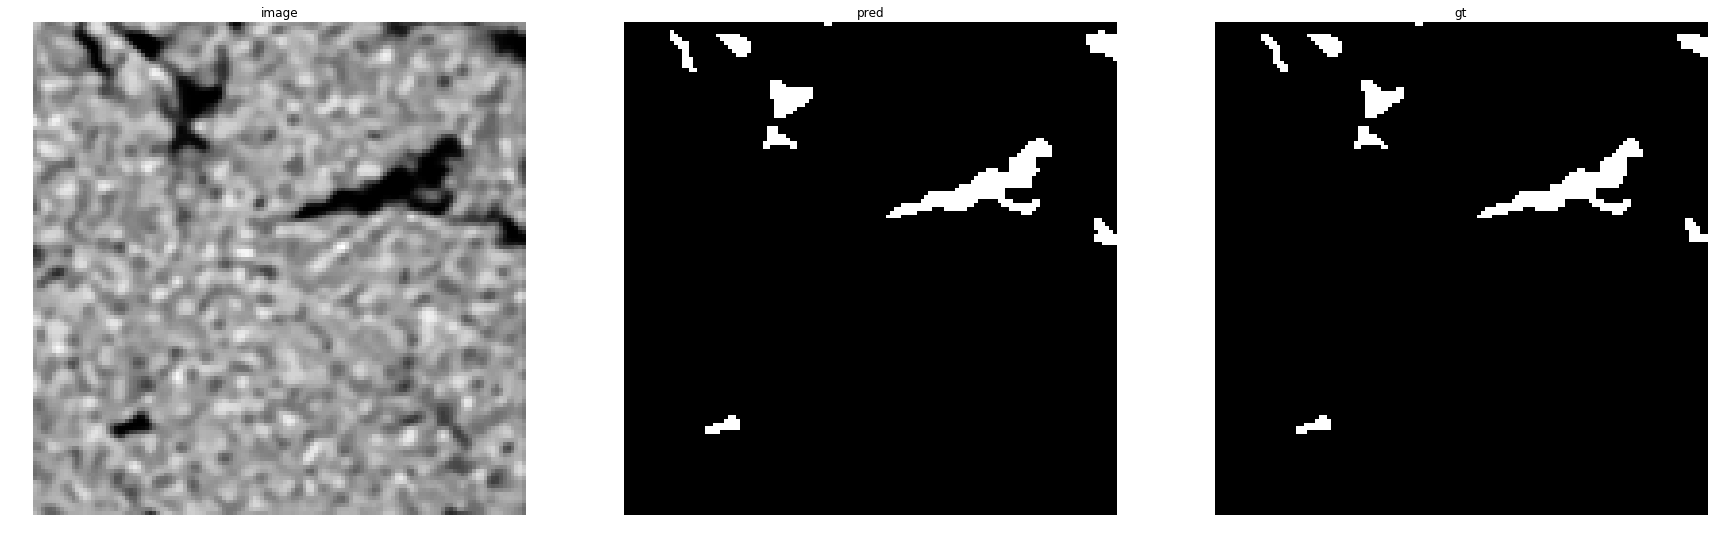

accuracy    : 0.99737548828125
precision   : 0.9212007504690432
recall      : 0.9979674796747967
f1          : 0.9580487804878048
pr_auc      : 0.9979869479148489
iou         : 0.9194756554307116


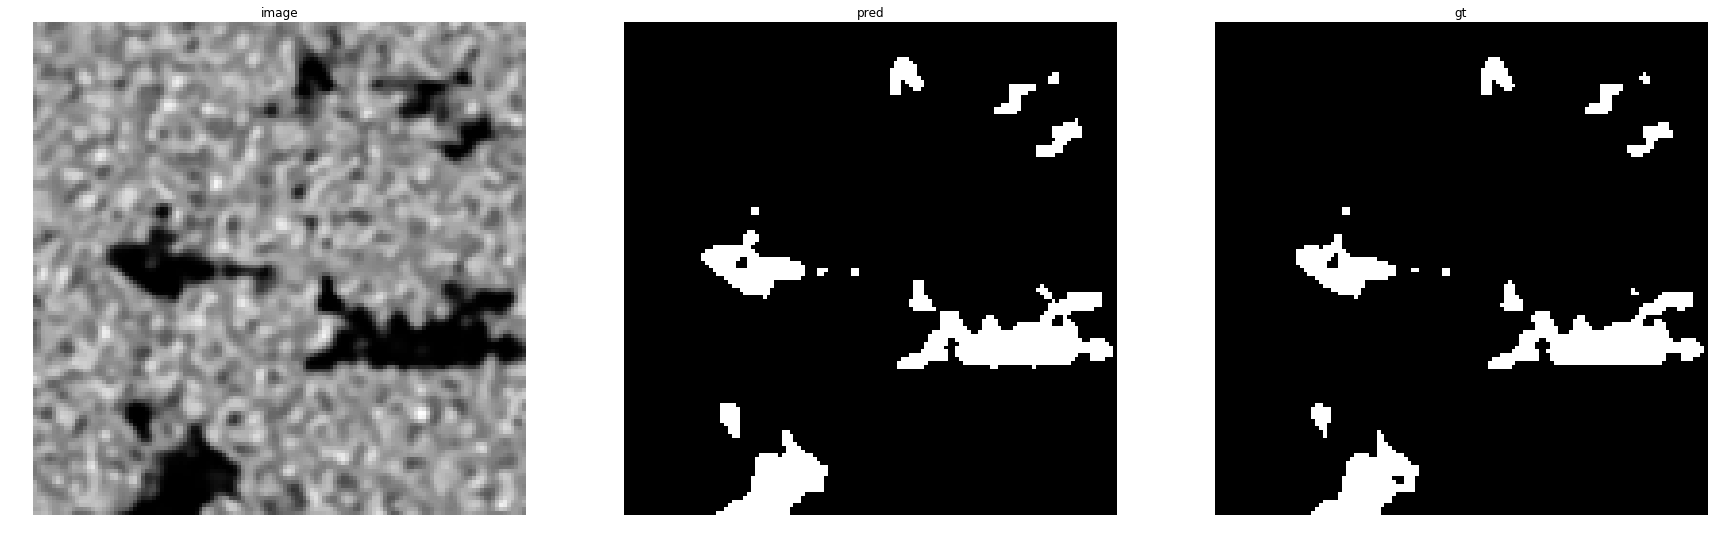

accuracy    : 0.994140625
precision   : 0.9289493575207861
recall      : 0.9983753046303818
f1          : 0.9624119028974158
pr_auc      : 0.9978945424566317
iou         : 0.9275471698113208


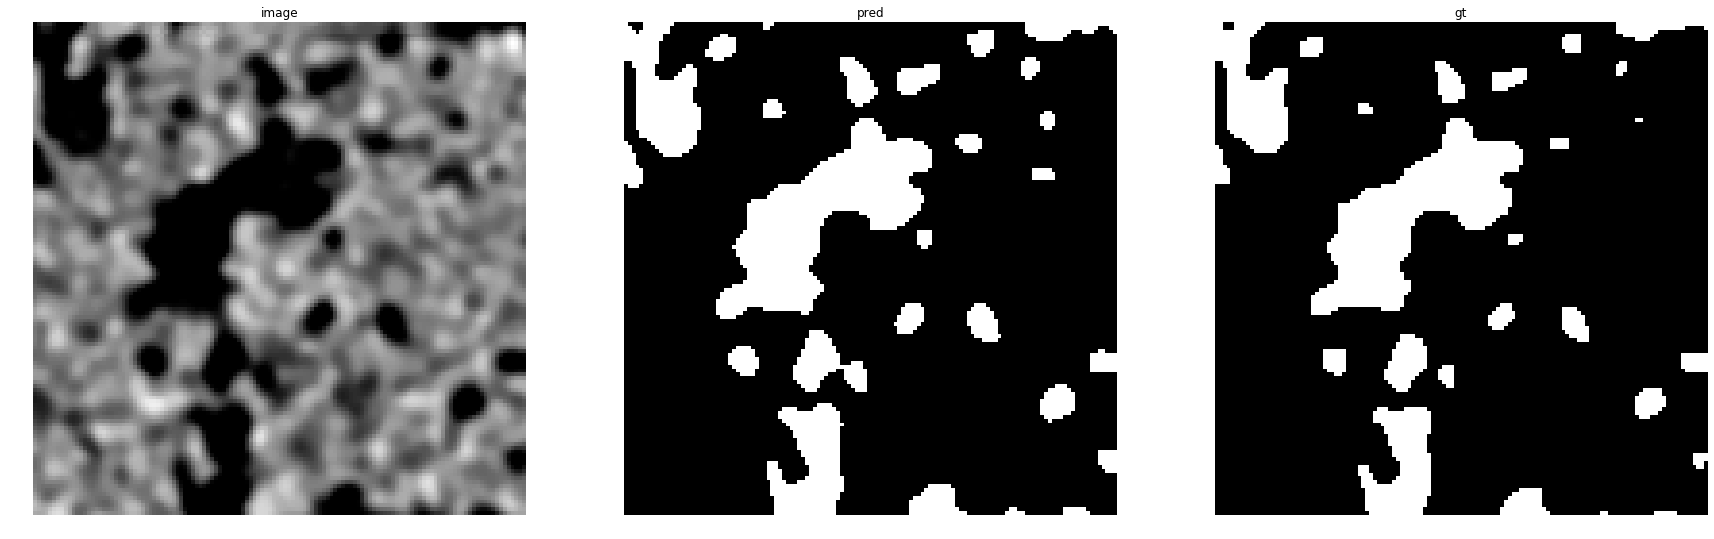

accuracy    : 0.97314453125
precision   : 0.8584844559585493
recall      : 0.9988696307460437
f1          : 0.9233716475095787
pr_auc      : 0.9980070708278943
iou         : 0.8576512455516014


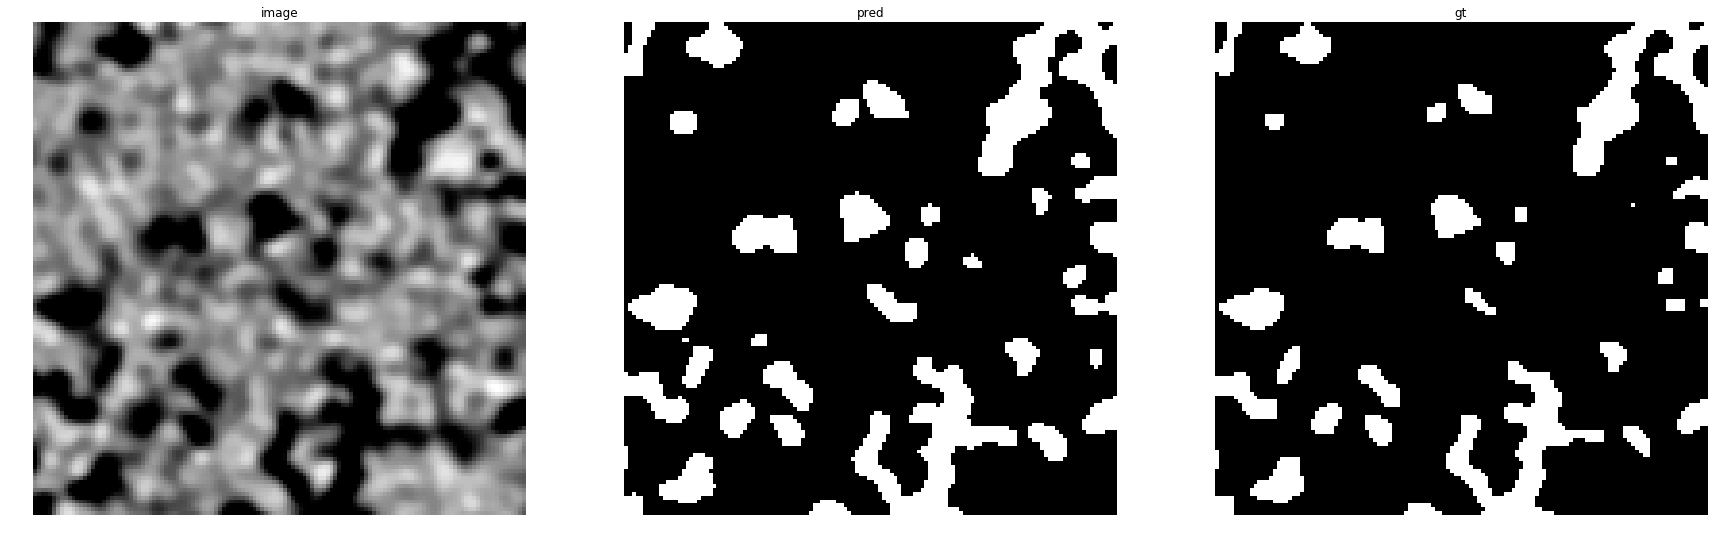

accuracy    : 0.95684814453125
precision   : 0.7741935483870968
recall      : 1.0
f1          : 0.8727272727272727
pr_auc      : 0.9945847941451438
iou         : 0.7741935483870968


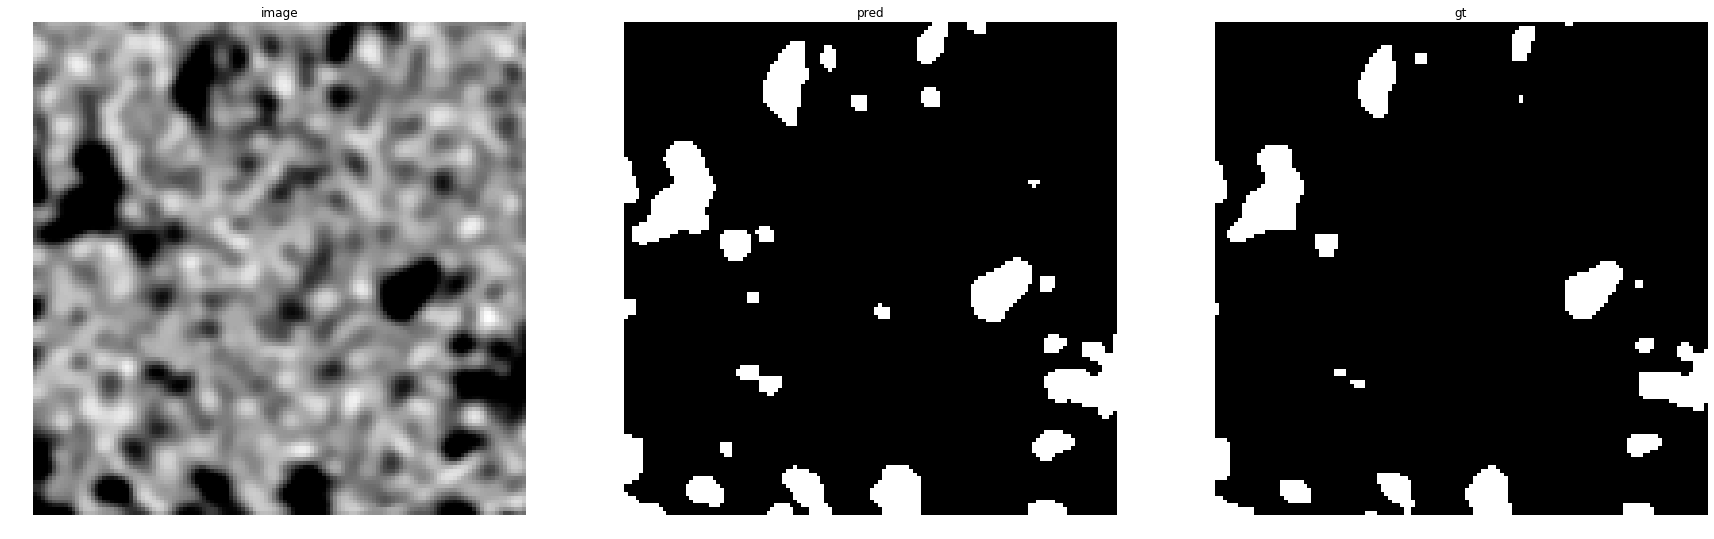

accuracy    : 0.968994140625
precision   : 0.7118547929665343
recall      : 1.0
f1          : 0.8316766070245195
pr_auc      : 0.9939170001156452
iou         : 0.7118547929665343


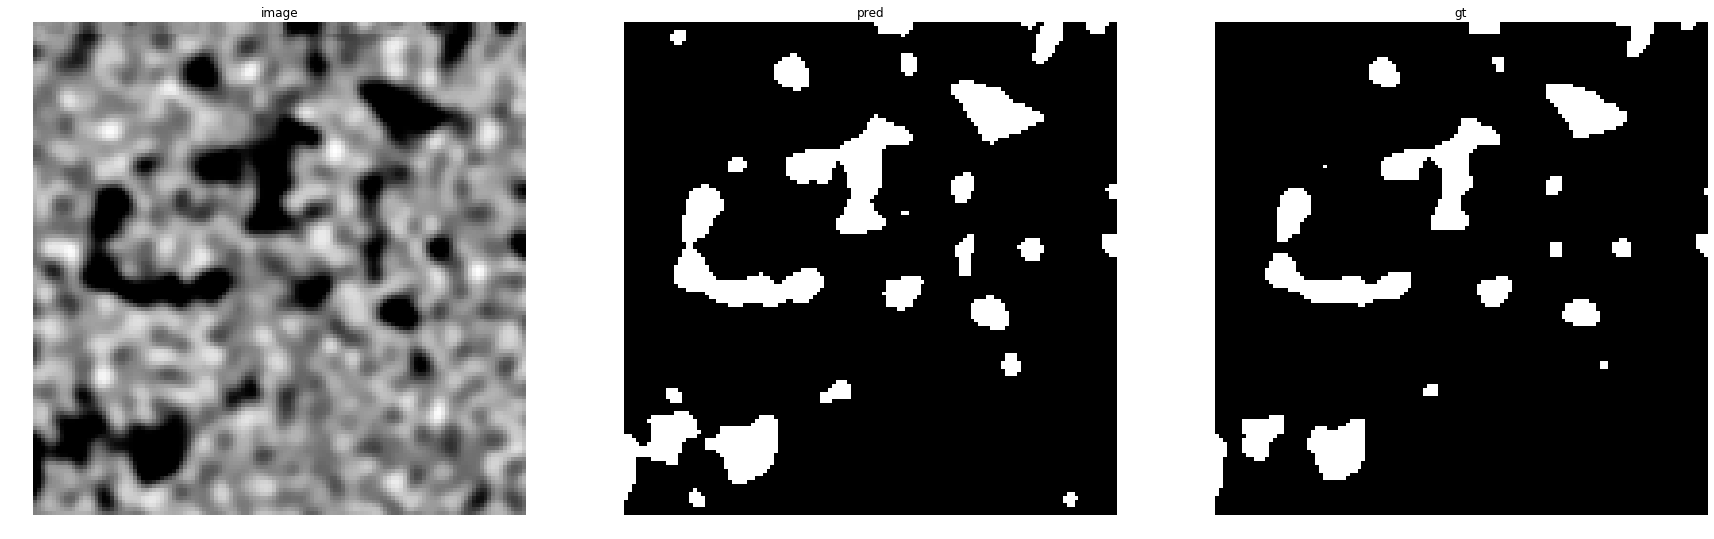

accuracy    : 0.96722412109375
precision   : 0.7338308457711443
recall      : 0.998645903859174
f1          : 0.8459994264410668
pr_auc      : 0.9923079548063589
iou         : 0.7331013916500994


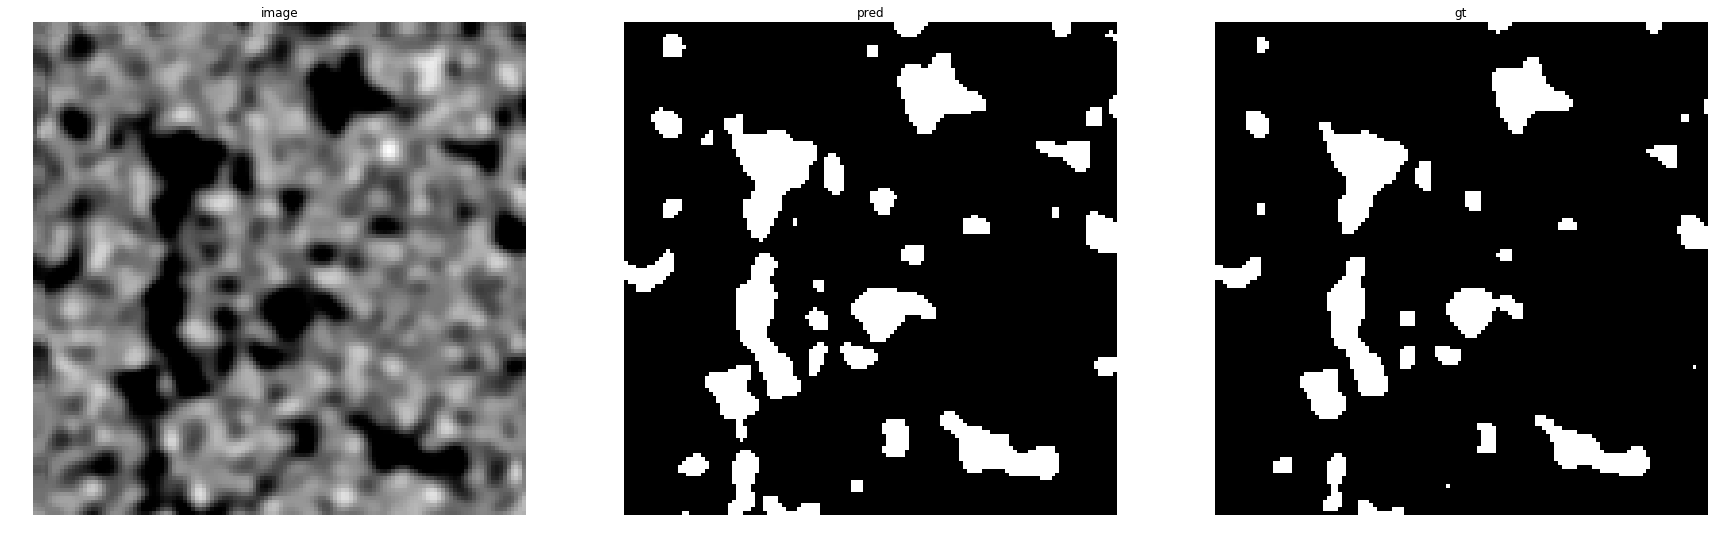

accuracy    : 0.95880126953125
precision   : 0.7271624898949071
recall      : 1.0
f1          : 0.8420313597004446
pr_auc      : 0.9916417474942304
iou         : 0.7271624898949071


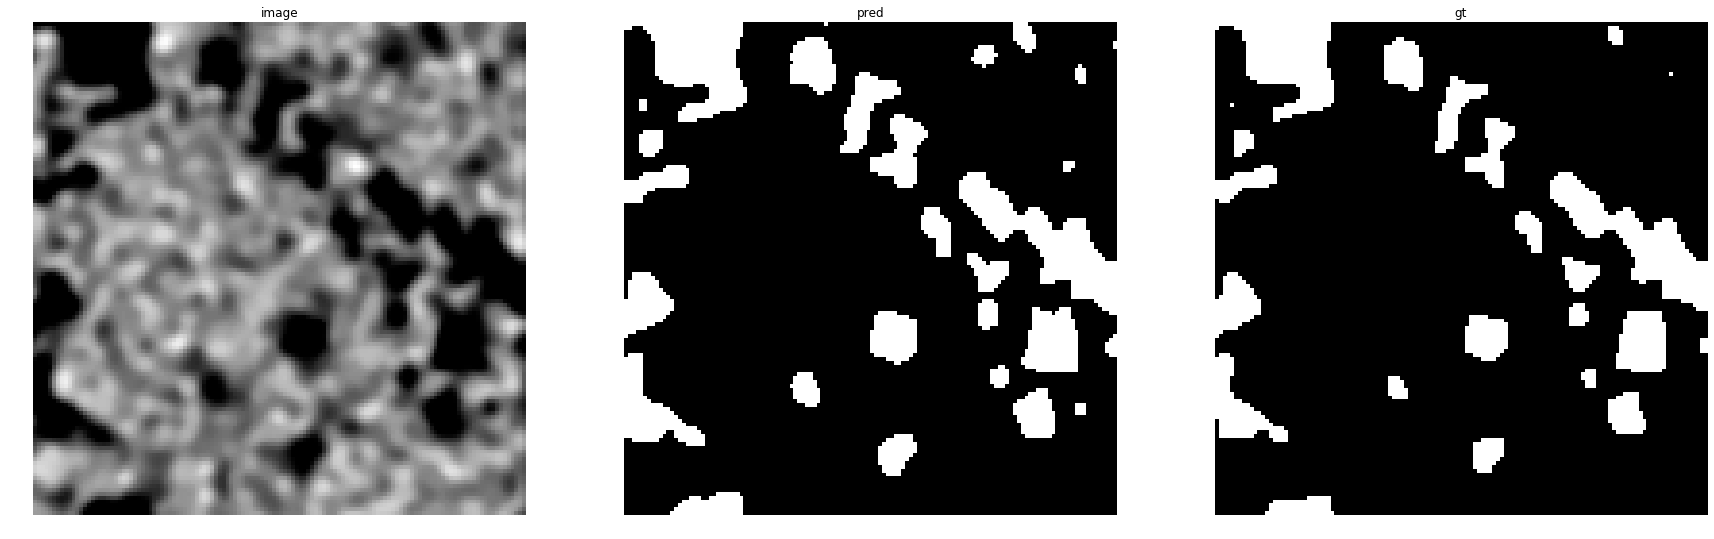

accuracy    : 0.96966552734375
precision   : 0.8315645326942828
recall      : 0.9979457682826622
f1          : 0.90718954248366
pr_auc      : 0.9958641477403479
iou         : 0.8301435406698564


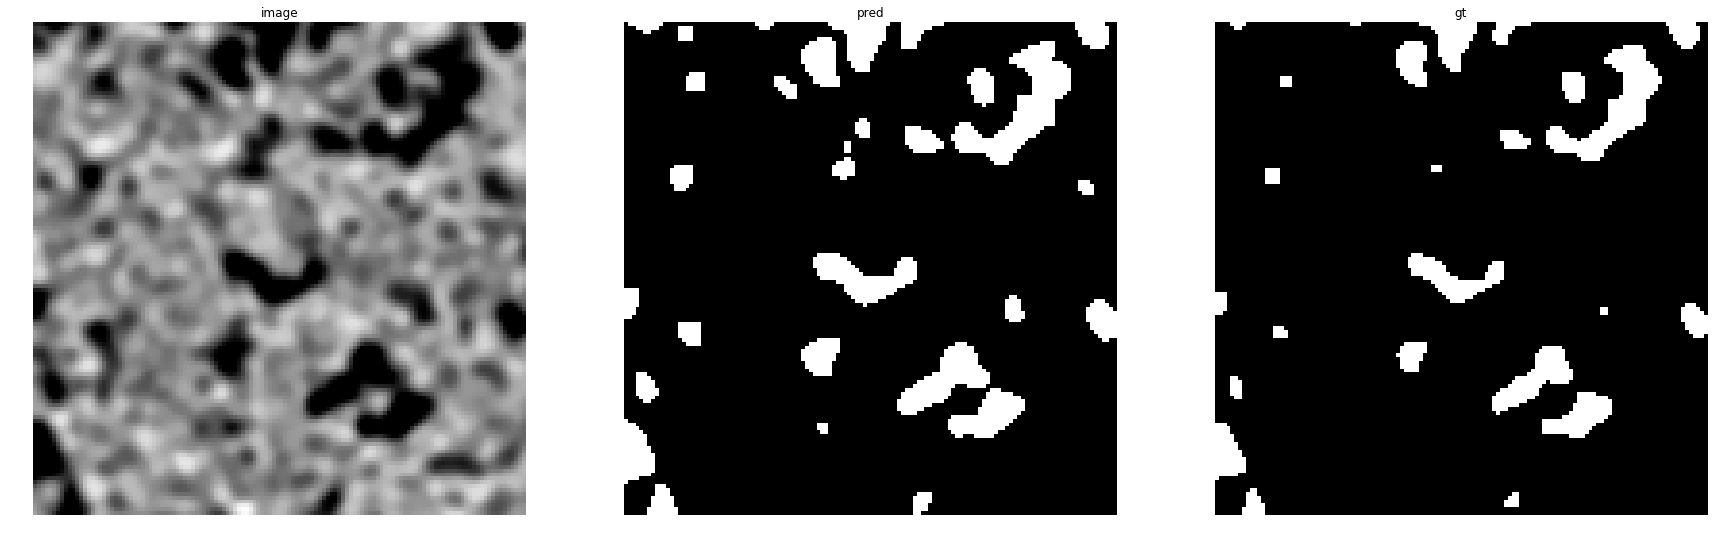

accuracy    : 0.96551513671875
precision   : 0.7104722792607803
recall      : 0.9992779783393502
f1          : 0.8304830483048304
pr_auc      : 0.9927970388386971
iou         : 0.7101077475628528


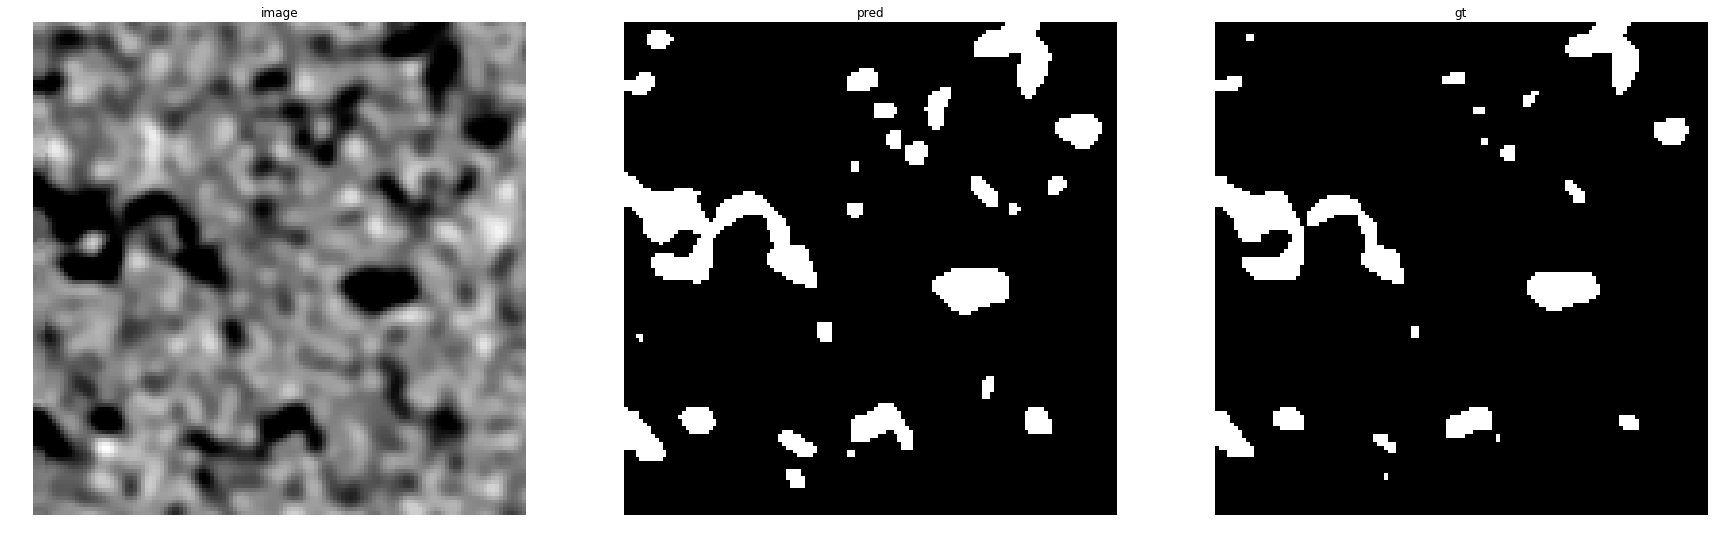

accuracy    : 0.966552734375
precision   : 0.6891661939875213
recall      : 1.0
f1          : 0.8159838817998657
pr_auc      : 0.9885981171858572
iou         : 0.6891661939875213


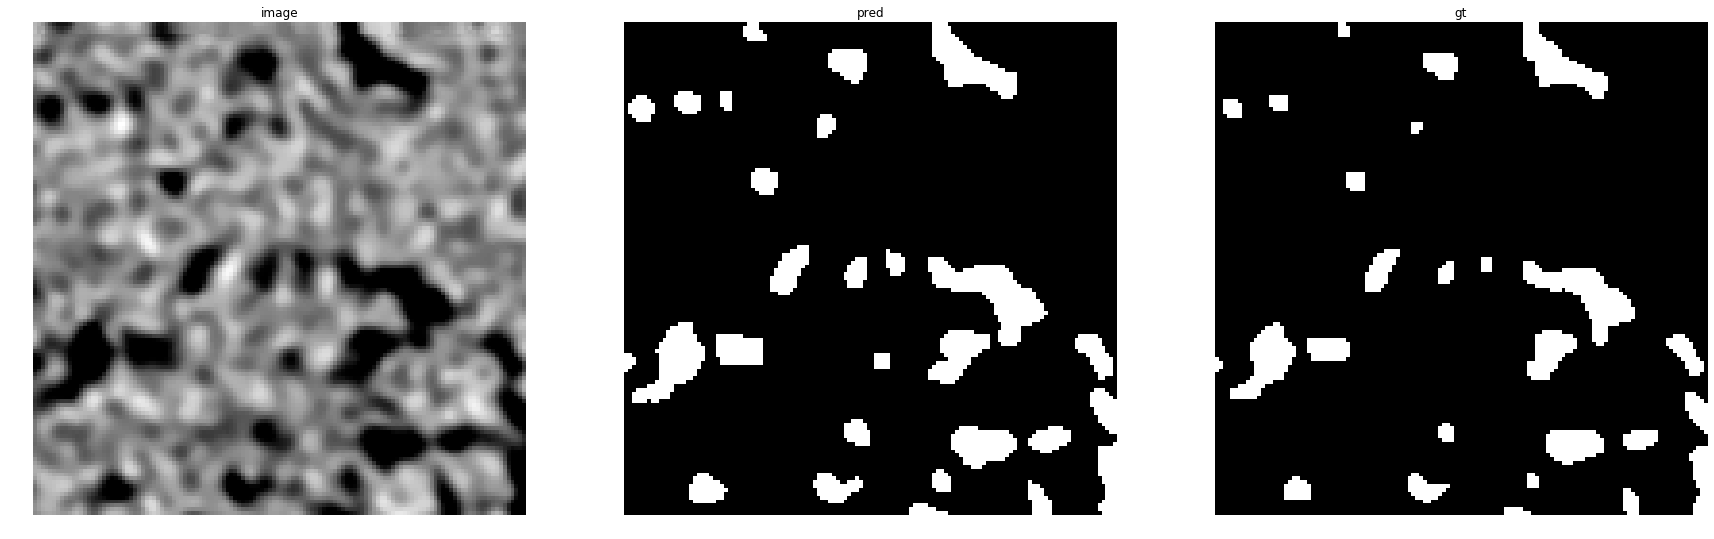

accuracy    : 0.9691162109375
precision   : 0.7428716904276986
recall      : 0.9993150684931507
f1          : 0.8522196261682243
pr_auc      : 0.9921717108454934
iou         : 0.7424936386768448


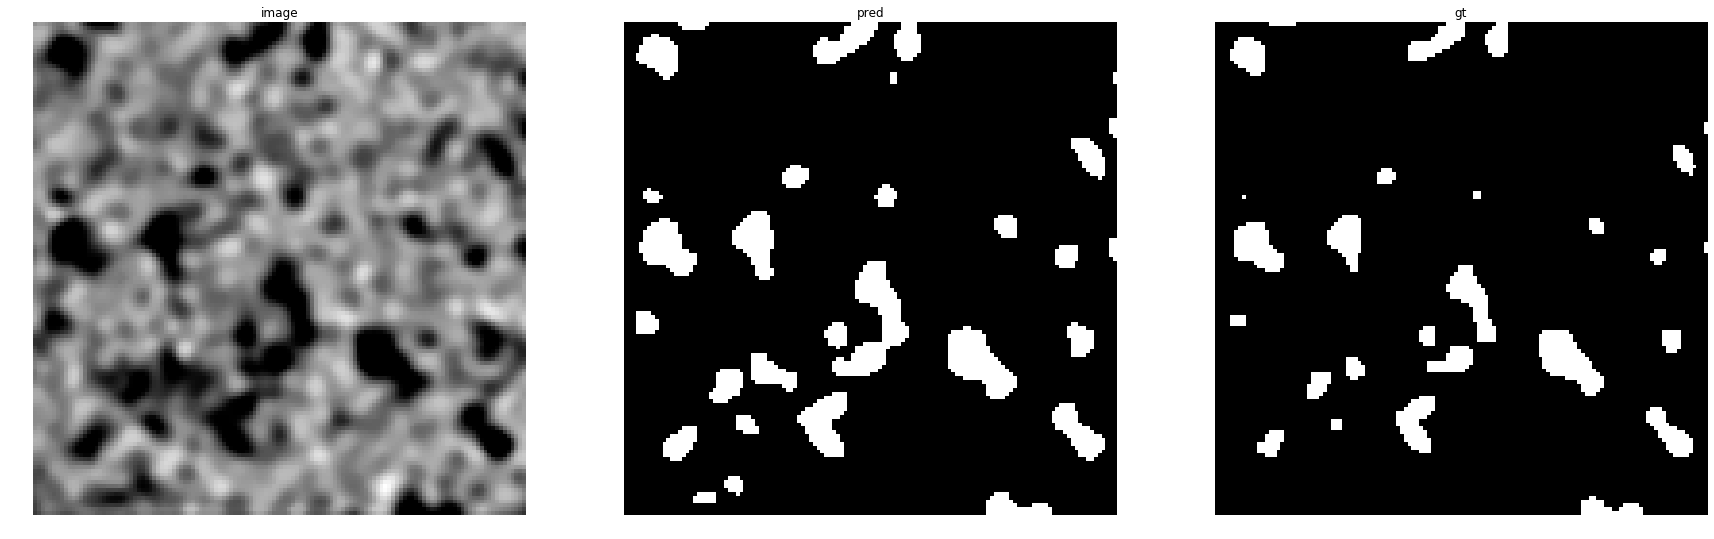

accuracy    : 0.96044921875
precision   : 0.6487804878048781
recall      : 1.0
f1          : 0.78698224852071
pr_auc      : 0.9908126644382382
iou         : 0.6487804878048781


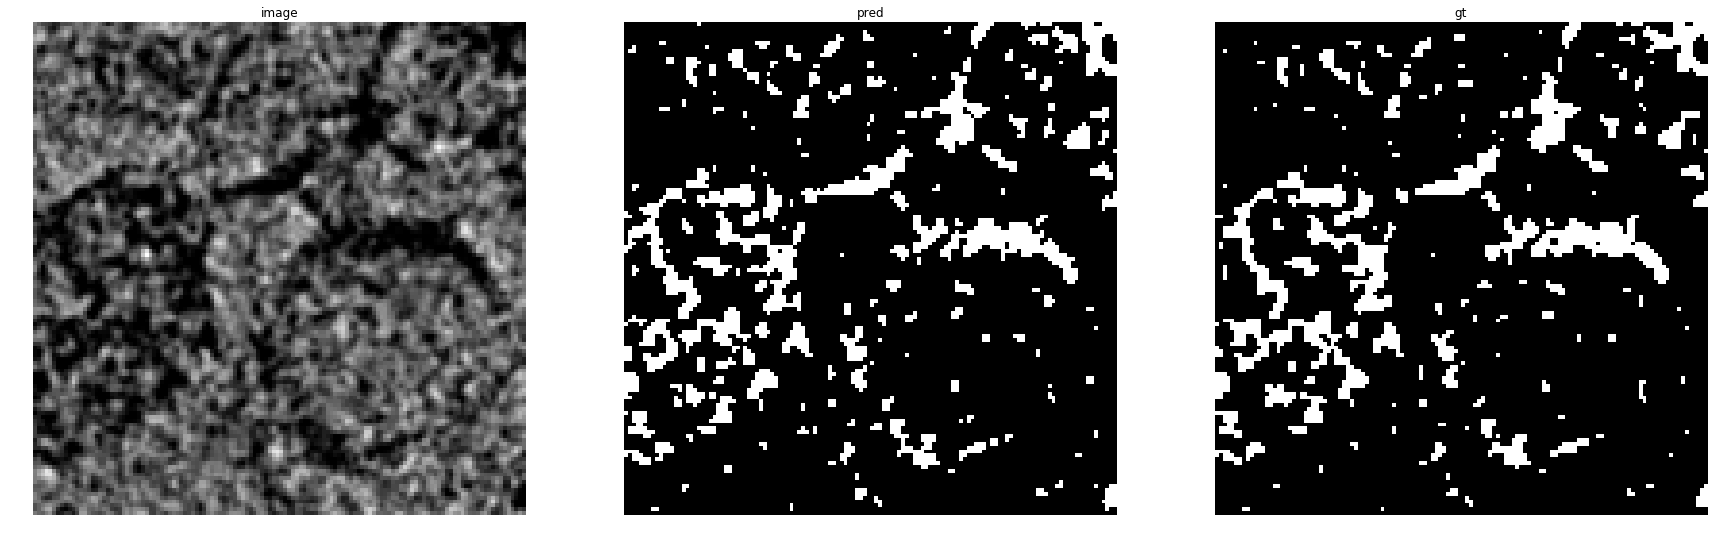

accuracy    : 0.97235107421875
precision   : 0.87751677852349
recall      : 0.9285397248113626
f1          : 0.9023075264179425
pr_auc      : 0.9772414538179492
iou         : 0.8220039292730845


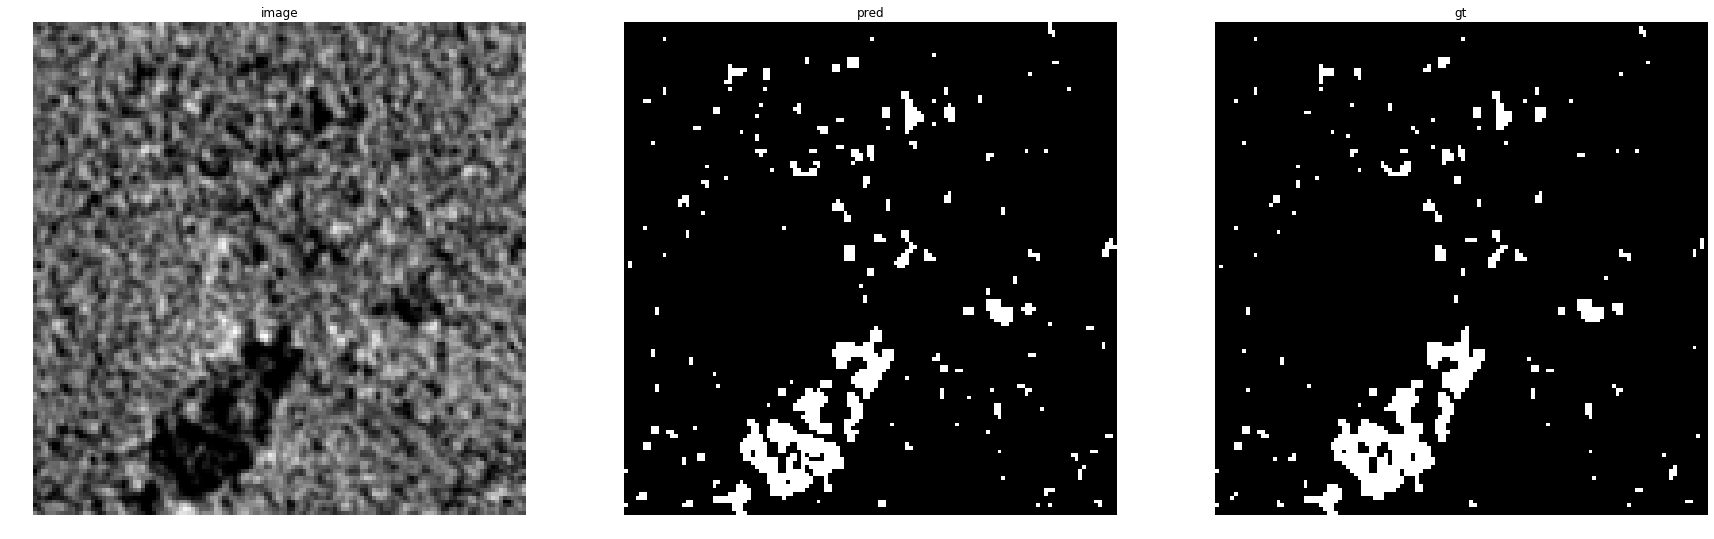

accuracy    : 0.98858642578125
precision   : 0.8664717348927875
recall      : 0.946751863684771
f1          : 0.9048346055979645
pr_auc      : 0.9777597701918344
iou         : 0.8262081784386617


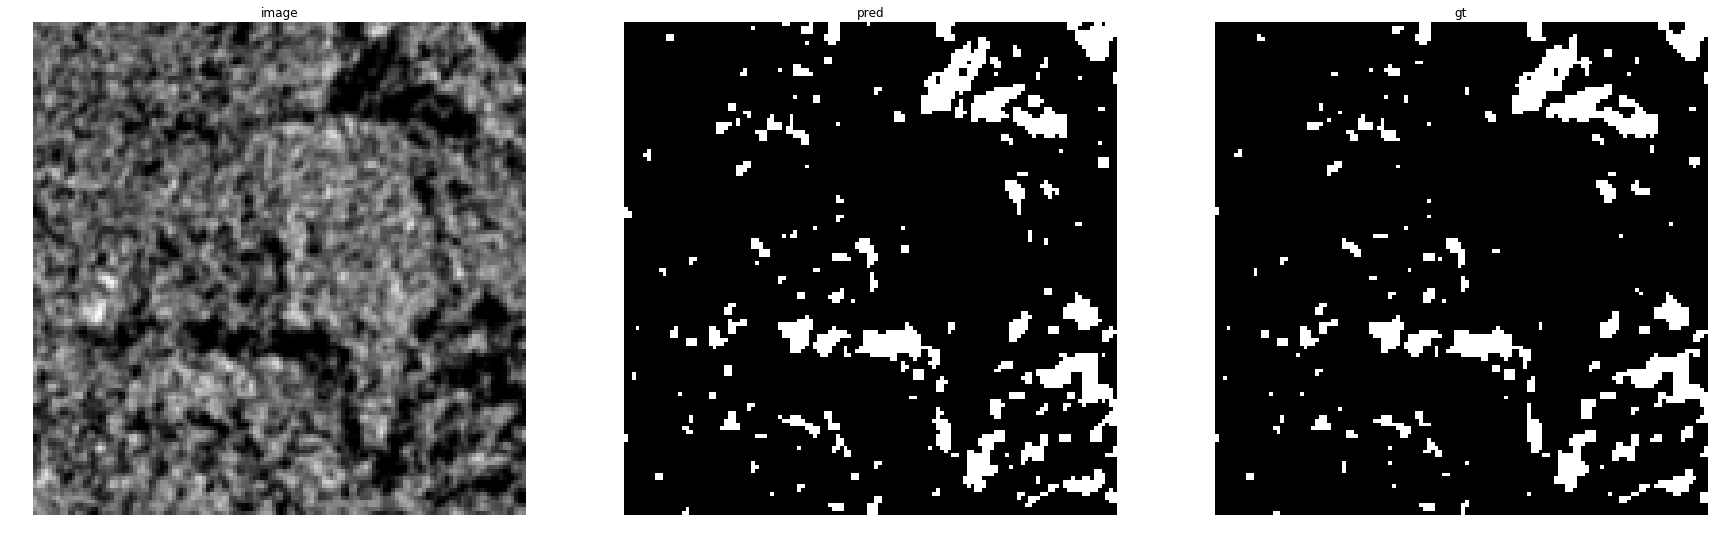

accuracy    : 0.9822998046875
precision   : 0.8720136518771331
recall      : 0.9593241551939925
f1          : 0.9135876042908225
pr_auc      : 0.9860531764042395
iou         : 0.8409215578716401


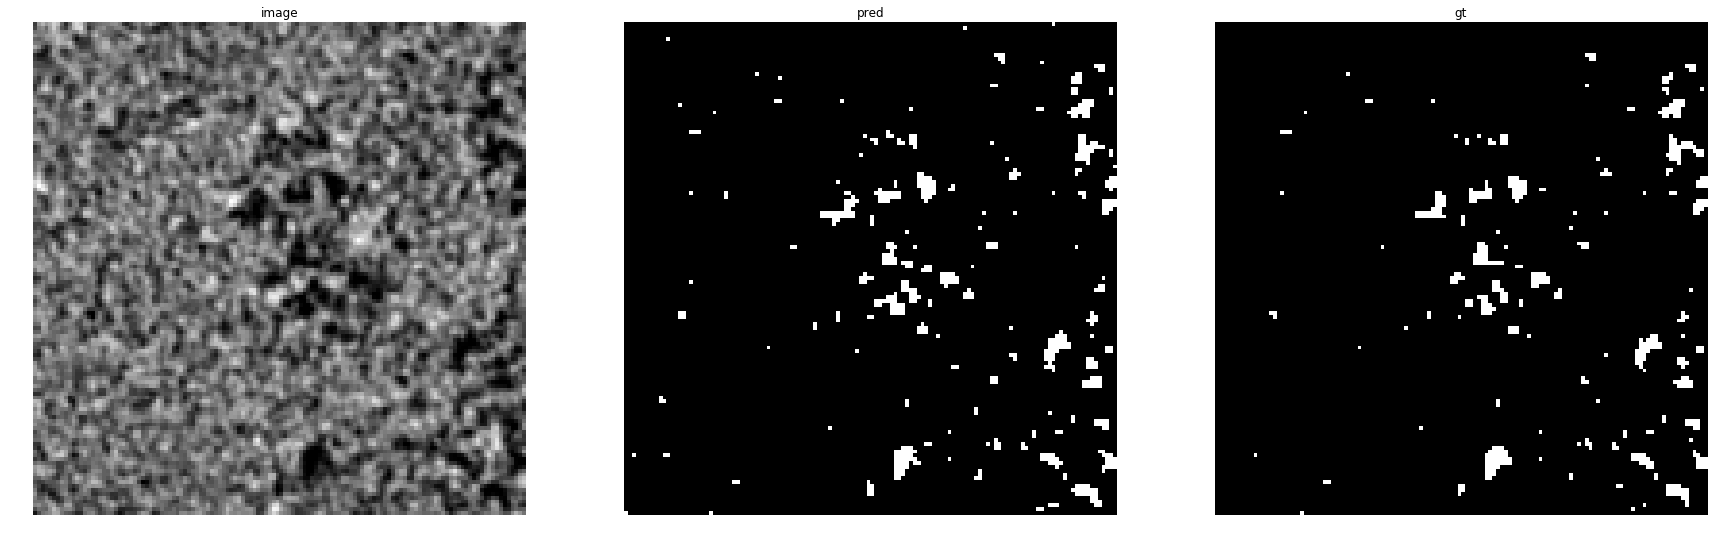

accuracy    : 0.99127197265625
precision   : 0.8068181818181818
recall      : 0.9539347408829175
f1          : 0.8742304309586632
pr_auc      : 0.9734140410403401
iou         : 0.7765625


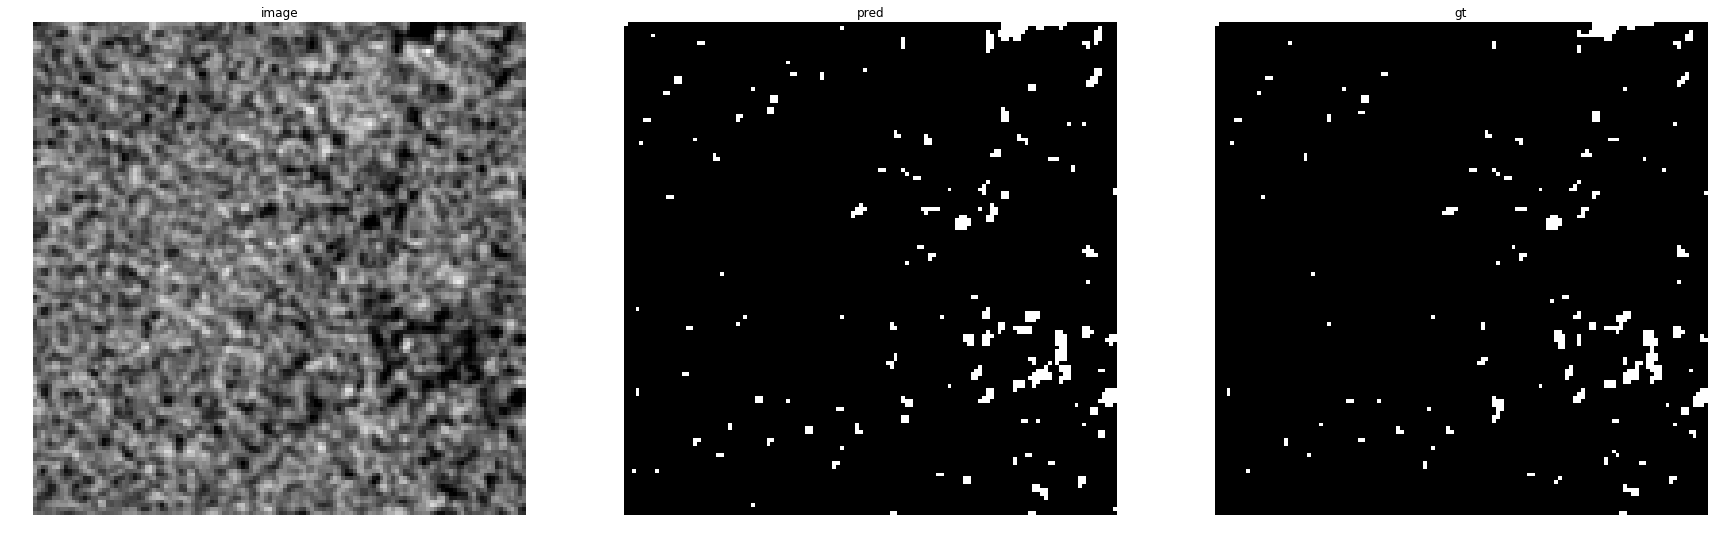

accuracy    : 0.99072265625
precision   : 0.733739837398374
recall      : 0.9450261780104712
f1          : 0.826086956521739
pr_auc      : 0.9599228576992749
iou         : 0.7037037037037037


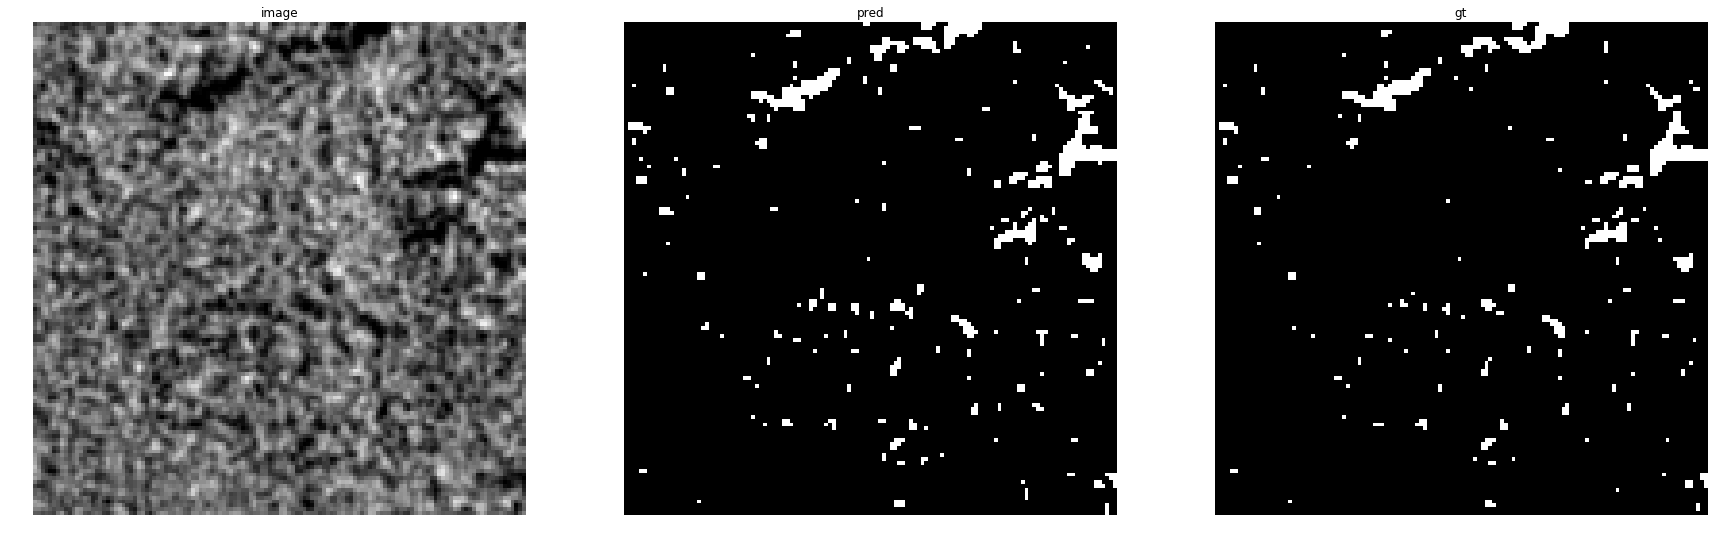

accuracy    : 0.99041748046875
precision   : 0.8135135135135135
recall      : 0.9694041867954911
f1          : 0.884643644379133
pr_auc      : 0.980074752227821
iou         : 0.7931488801054019


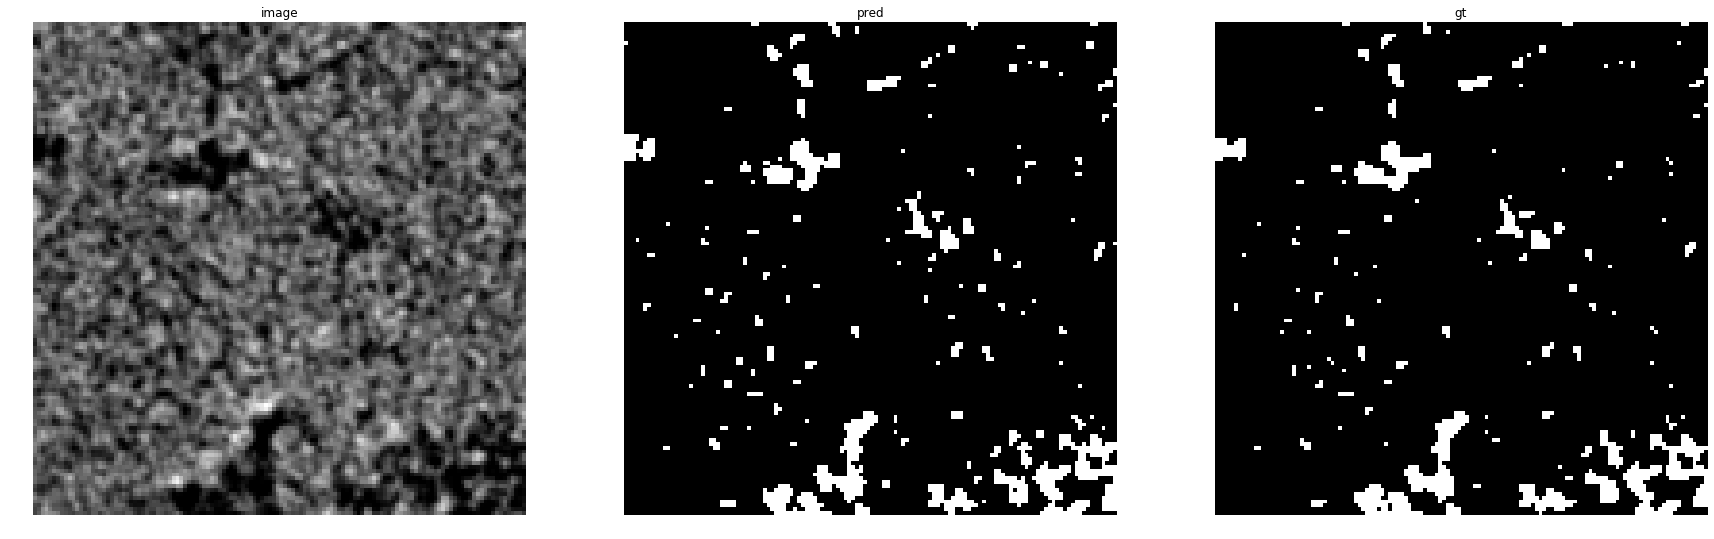

accuracy    : 0.987060546875
precision   : 0.8685567010309279
recall      : 0.9448598130841122
f1          : 0.9051029543419875
pr_auc      : 0.9790183703988495
iou         : 0.8266557645134914


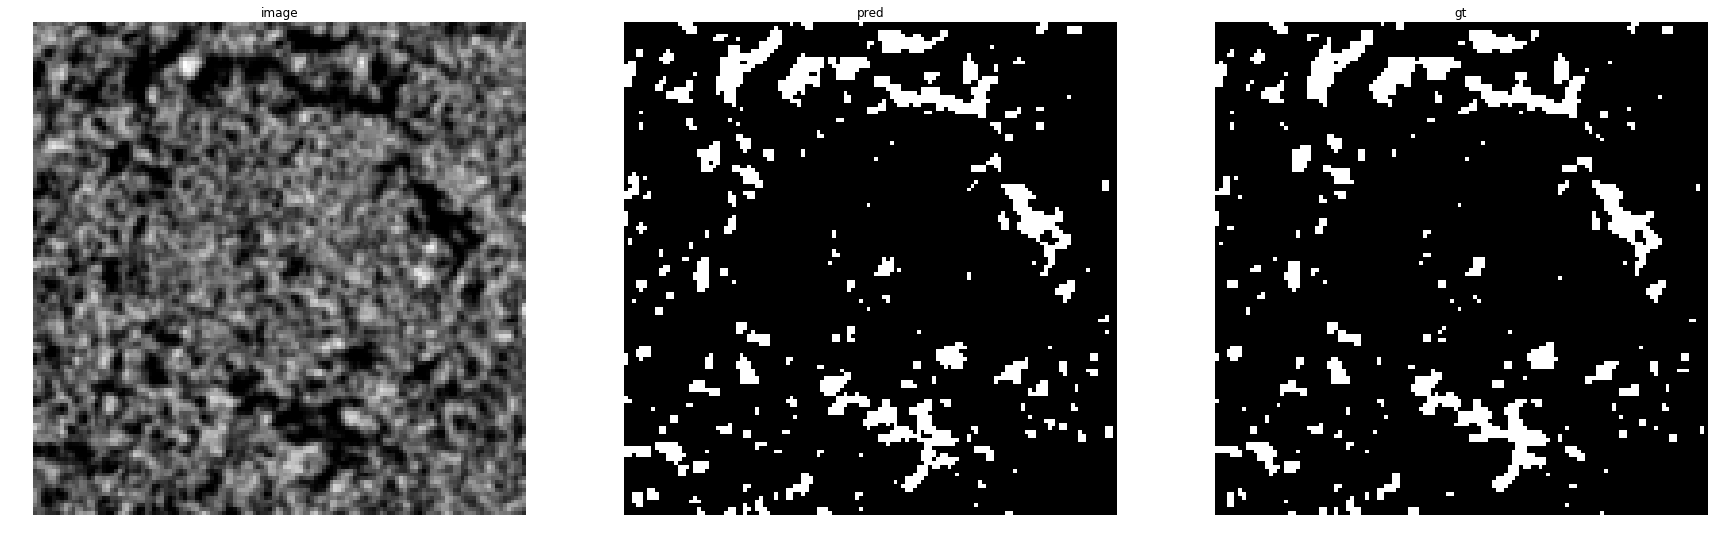

accuracy    : 0.9808349609375
precision   : 0.871836295099623
recall      : 0.9551622418879055
f1          : 0.911599099099099
pr_auc      : 0.9835224482176209
iou         : 0.8375581996896017


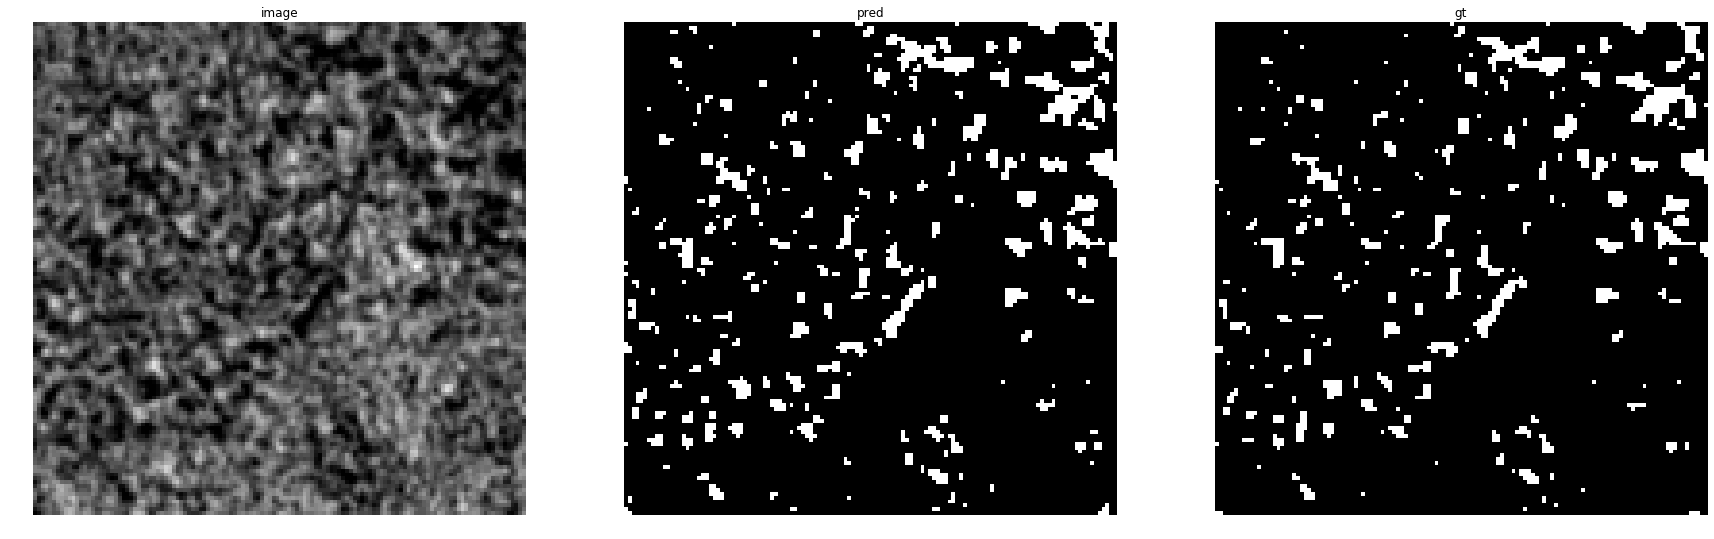

accuracy    : 0.9803466796875
precision   : 0.8317214700193424
recall      : 0.9548482605477424
f1          : 0.8890420399724328
pr_auc      : 0.9777046016352966
iou         : 0.8002481389578163


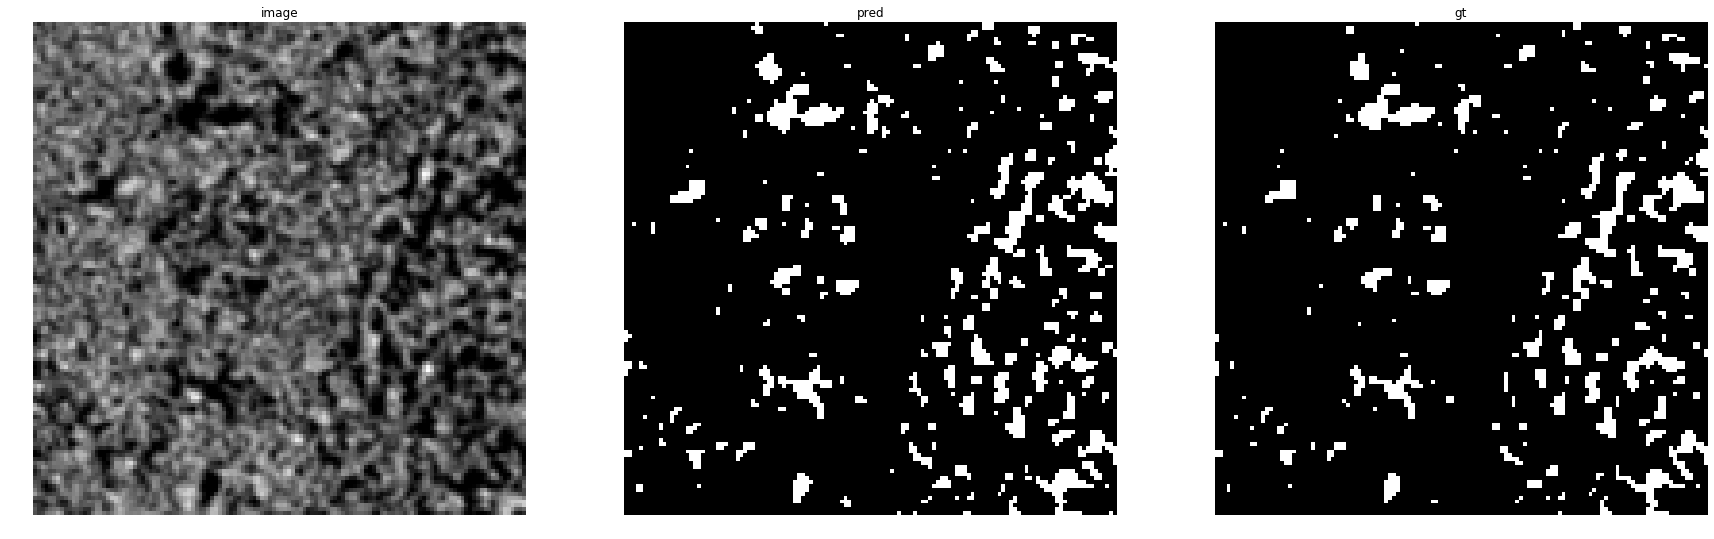

accuracy    : 0.9803466796875
precision   : 0.8389380530973451
recall      : 0.9666893269884432
f1          : 0.8982943777637398
pr_auc      : 0.9817039791988885
iou         : 0.8153669724770642


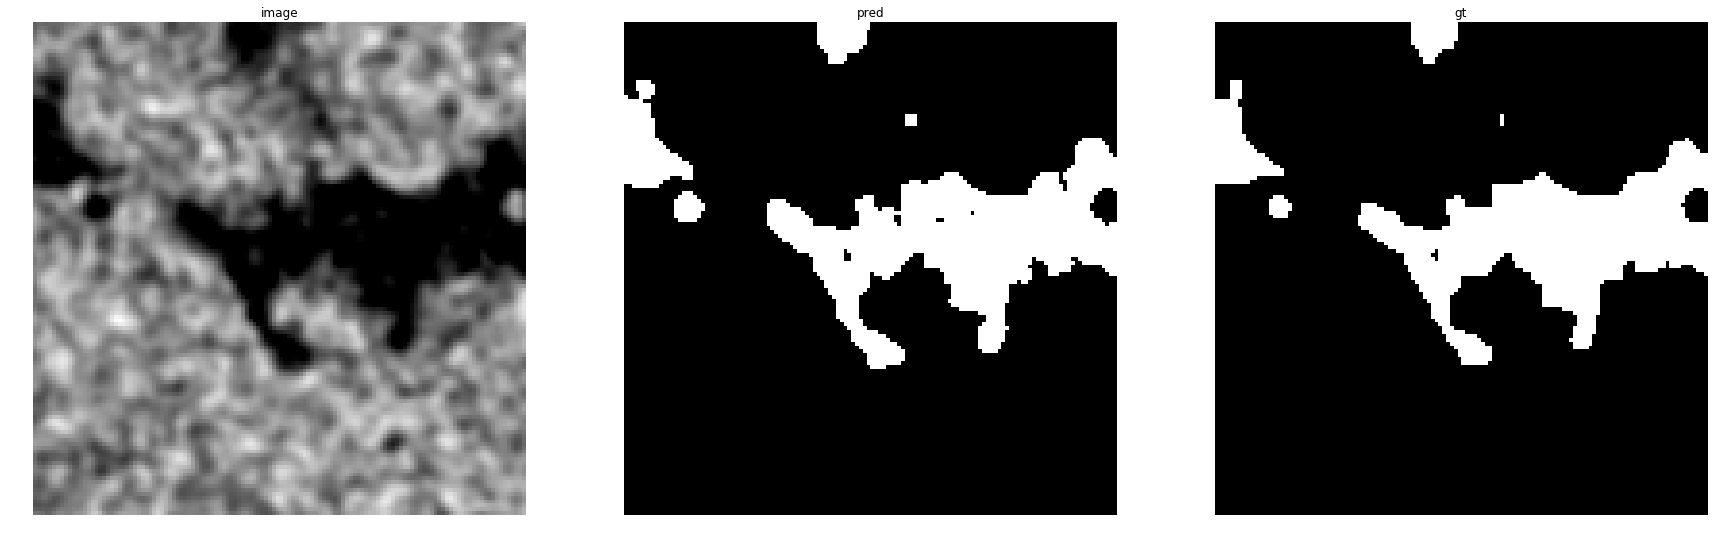

accuracy    : 0.98602294921875
precision   : 0.9313466616371181
recall      : 0.9813195548489666
f1          : 0.9556802786916972
pr_auc      : 0.9968800397696885
iou         : 0.9151223128243143


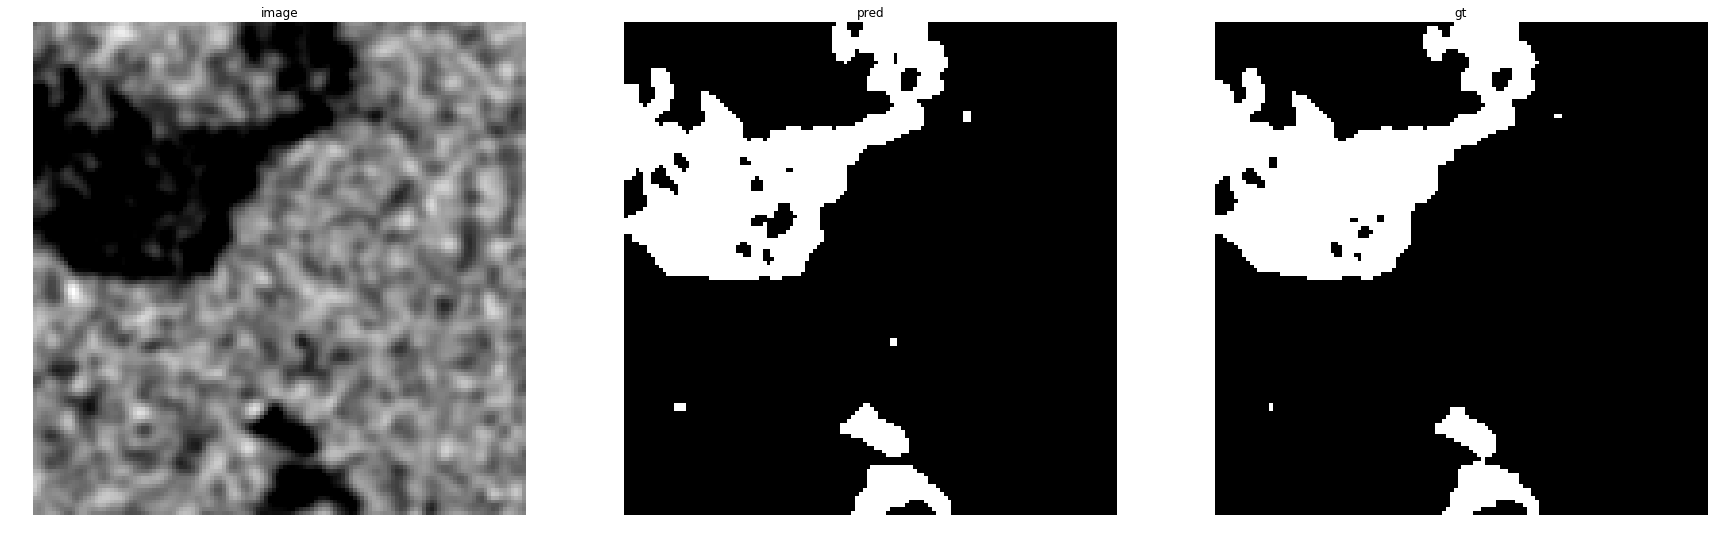

accuracy    : 0.9859619140625
precision   : 0.9633649932157394
recall      : 0.9588116137744767
f1          : 0.961082910321489
pr_auc      : 0.995265122845551
iou         : 0.9250814332247557


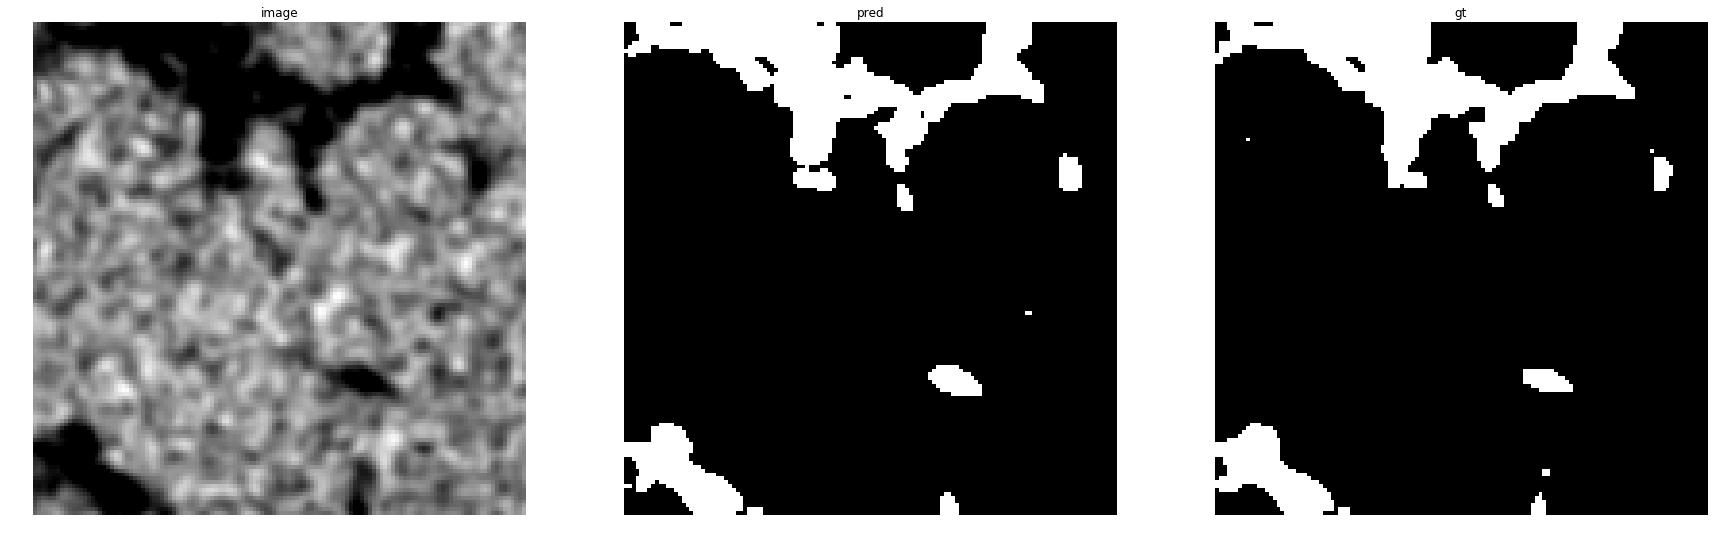

accuracy    : 0.98883056640625
precision   : 0.9447713897691263
recall      : 0.9716014897579144
f1          : 0.9579986229056691
pr_auc      : 0.996074986287211
iou         : 0.9193832599118943


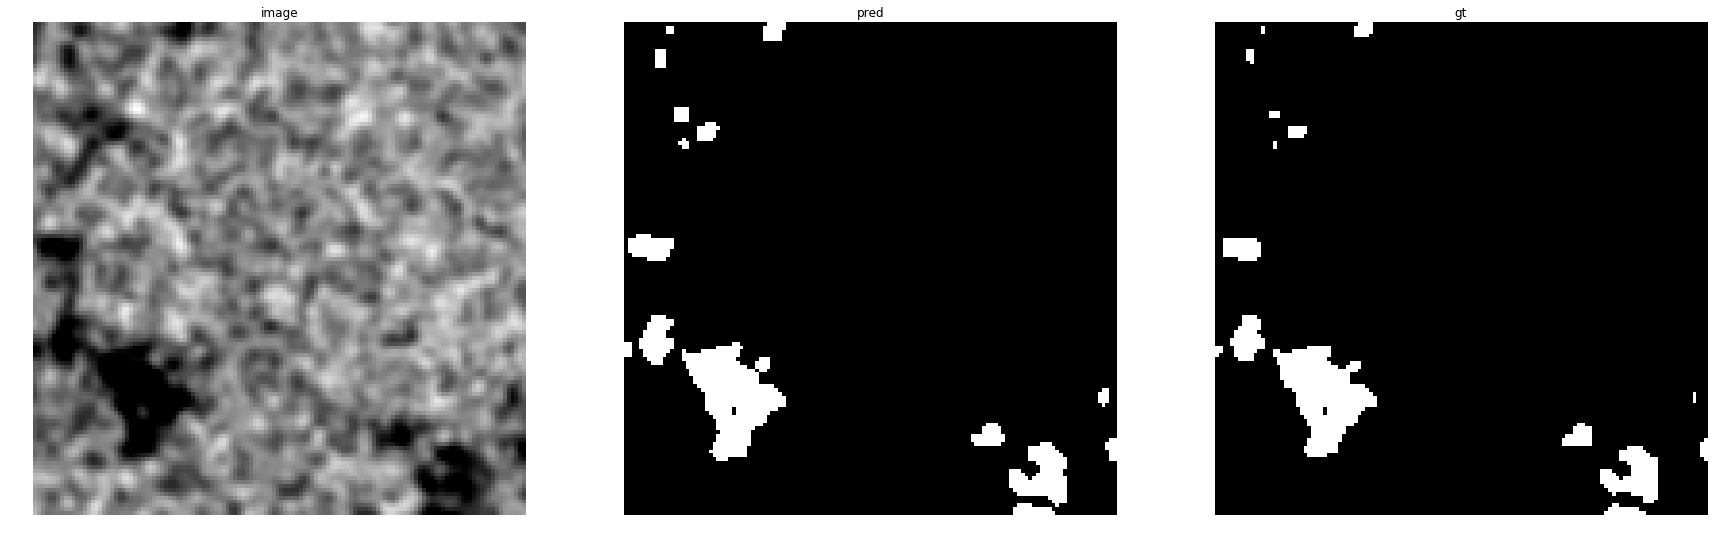

accuracy    : 0.99163818359375
precision   : 0.8610206297502715
recall      : 0.9887780548628429
f1          : 0.9204875217643645
pr_auc      : 0.992280155598528
iou         : 0.8526881720430107


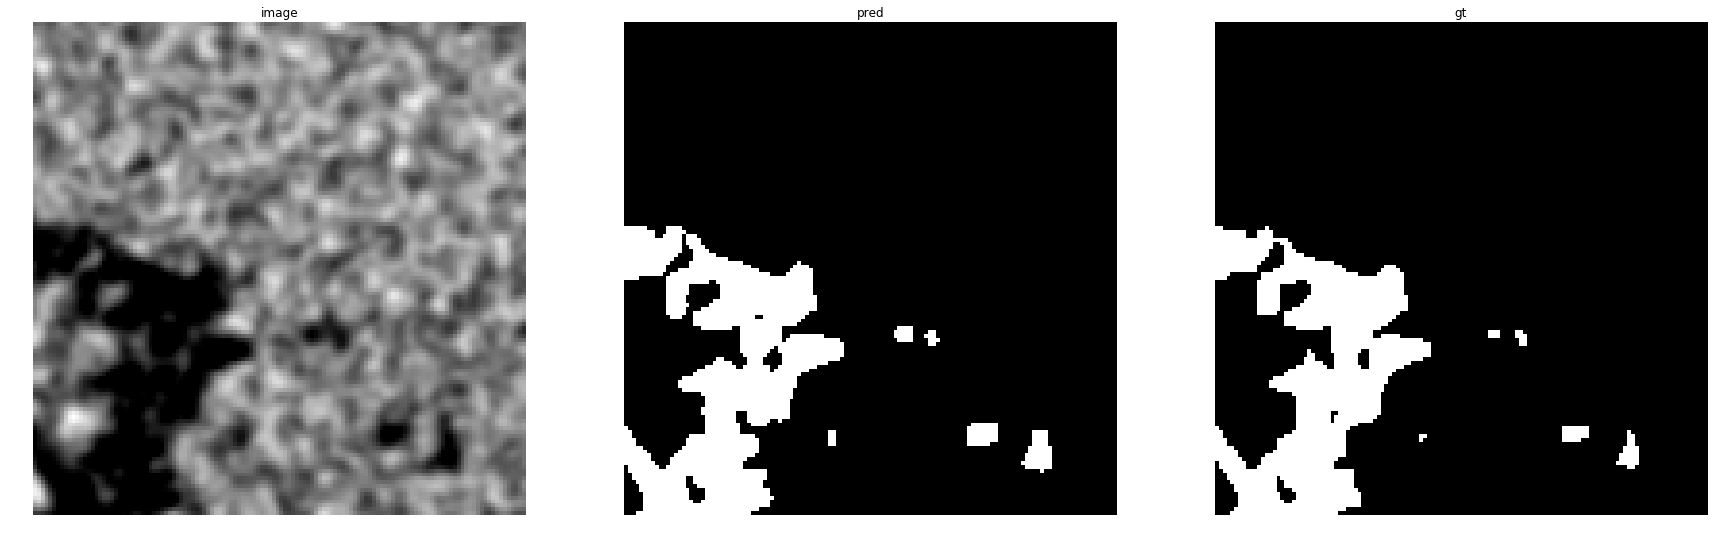

accuracy    : 0.9876708984375
precision   : 0.9253731343283582
recall      : 0.9761300152361605
f1          : 0.9500741473059813
pr_auc      : 0.994453064325135
iou         : 0.9048964218455744


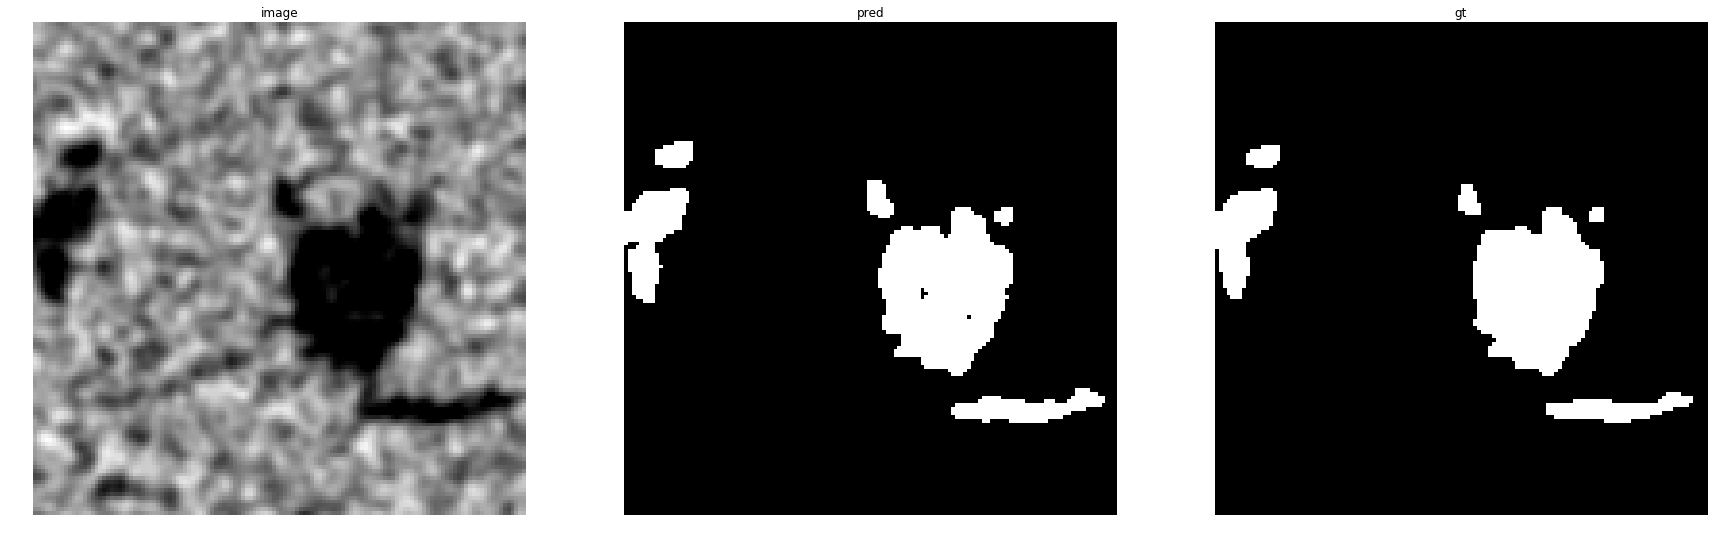

accuracy    : 0.99200439453125
precision   : 0.930870083432658
recall      : 0.9904882688649335
f1          : 0.9597542242703533
pr_auc      : 0.9979454395500937
iou         : 0.9226225634967513


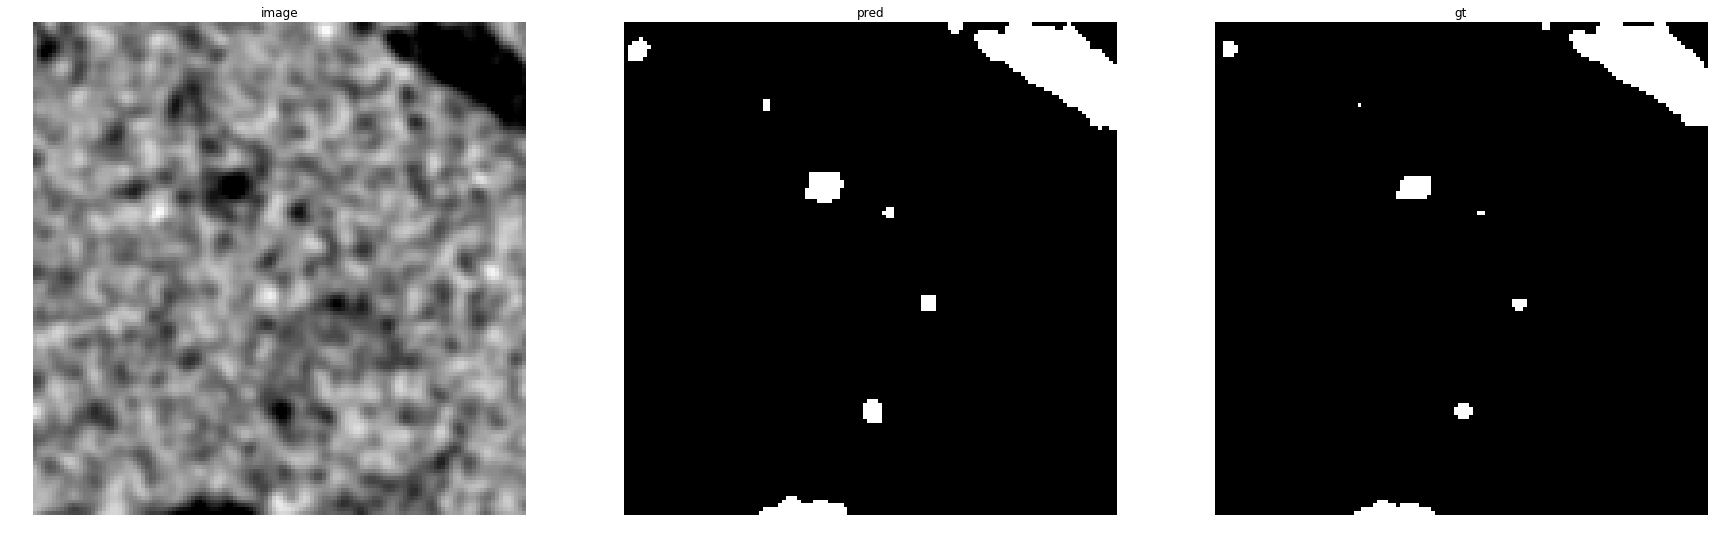

accuracy    : 0.99298095703125
precision   : 0.8607918263090677
recall      : 0.9911764705882353
f1          : 0.9213943950786057
pr_auc      : 0.9959996122752314
iou         : 0.8542458808618505


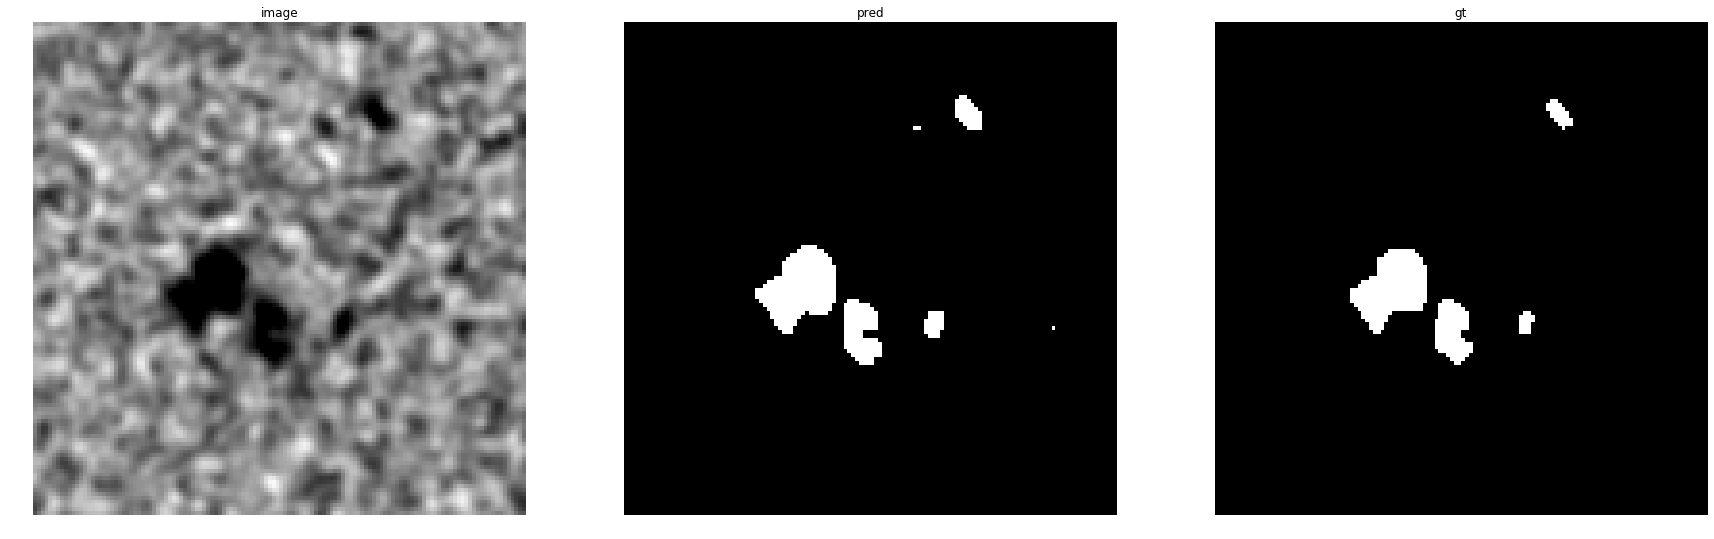

accuracy    : 0.9957275390625
precision   : 0.8717948717948718
recall      : 0.9888143176733781
f1          : 0.9266247379454927
pr_auc      : 0.9954522414597744
iou         : 0.86328125


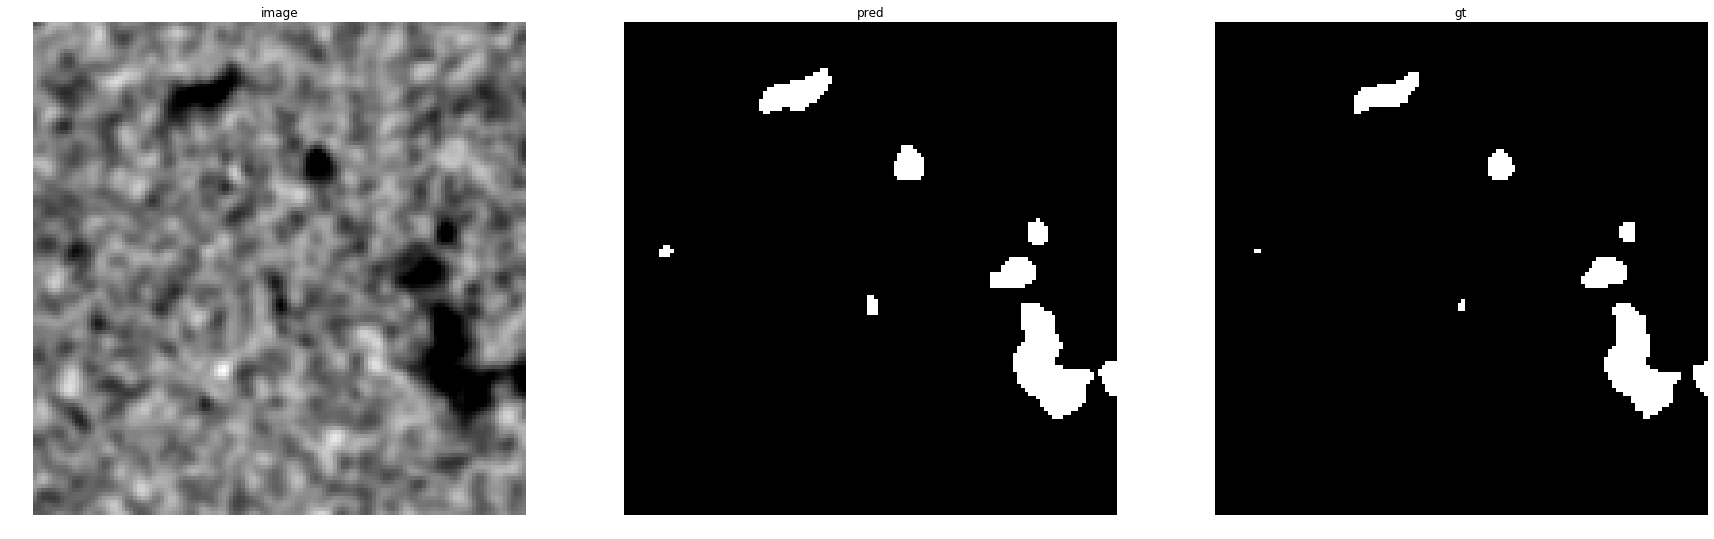

accuracy    : 0.99267578125
precision   : 0.8289473684210527
recall      : 0.9947368421052631
f1          : 0.9043062200956938
pr_auc      : 0.9946984743643428
iou         : 0.8253275109170306


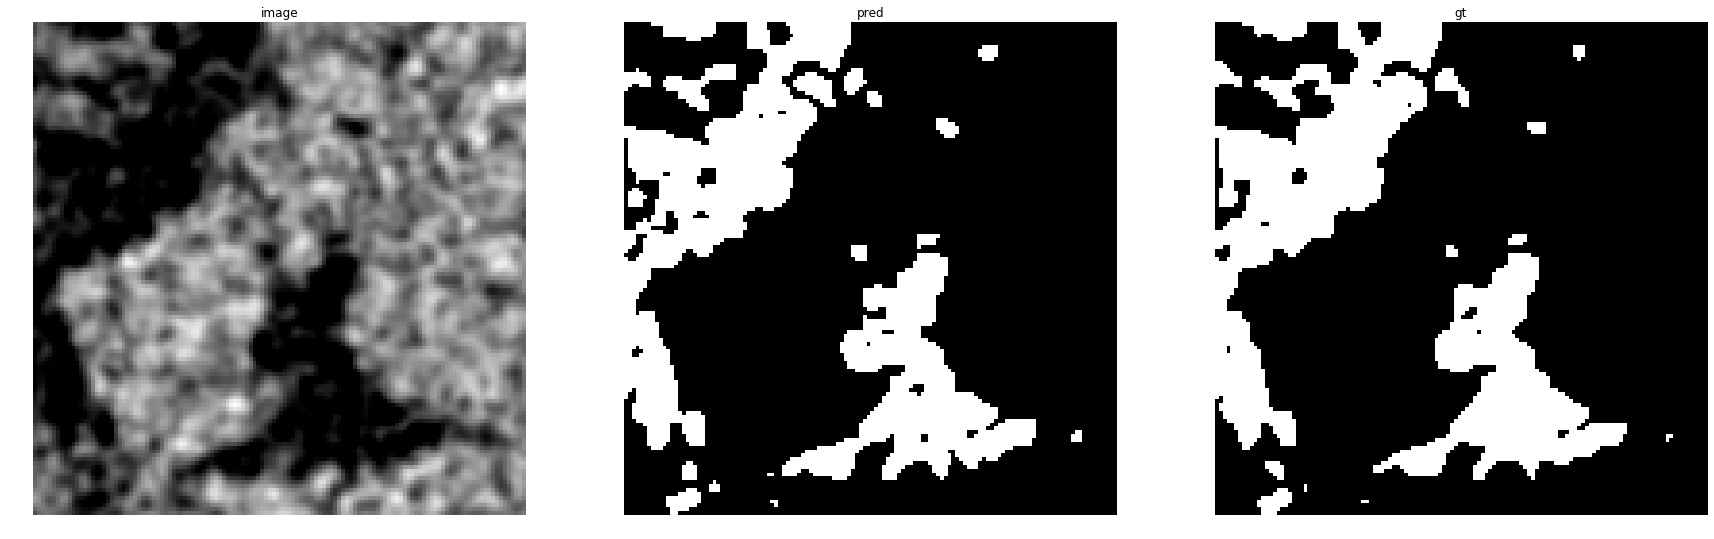

accuracy    : 0.9766845703125
precision   : 0.9590268886043534
recall      : 0.9440383161078901
f1          : 0.9514735772357725
pr_auc      : 0.9938166972204353
iou         : 0.9074388175430095


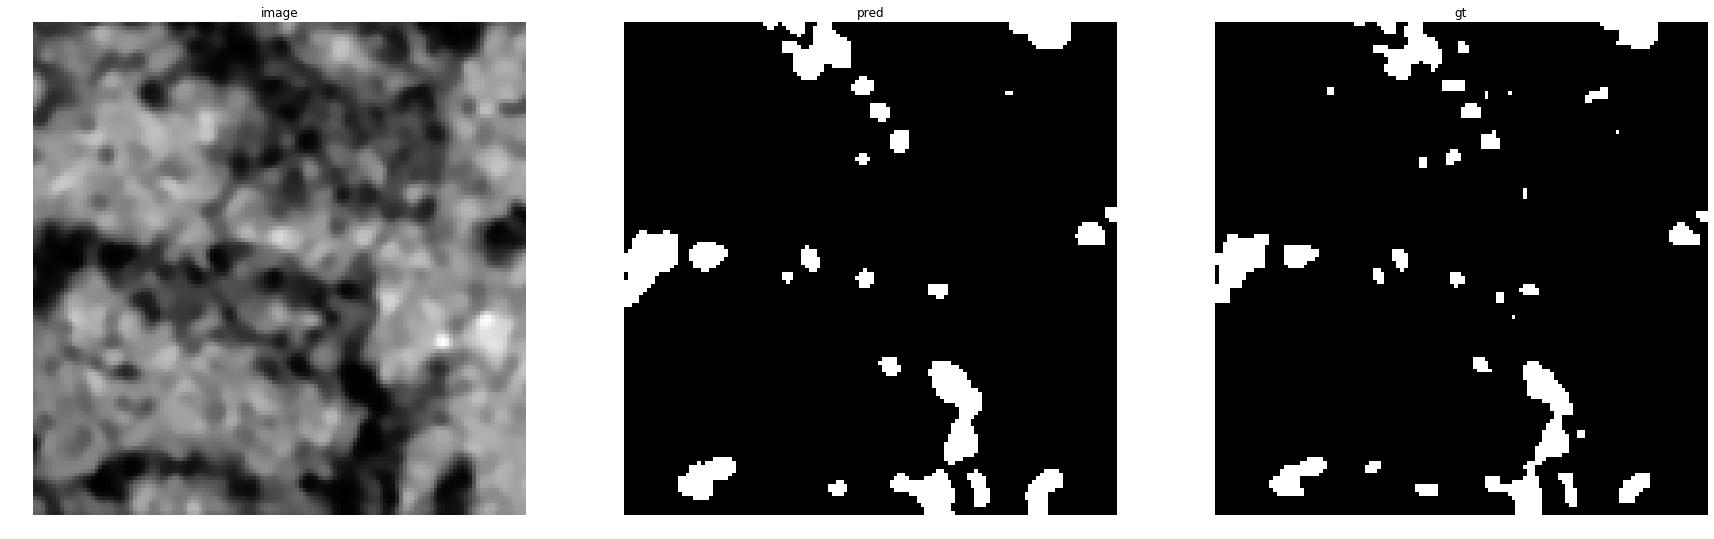

accuracy    : 0.97918701171875
precision   : 0.7989002356637863
recall      : 0.9228675136116152
f1          : 0.856421052631579
pr_auc      : 0.962460690802588
iou         : 0.7488954344624448


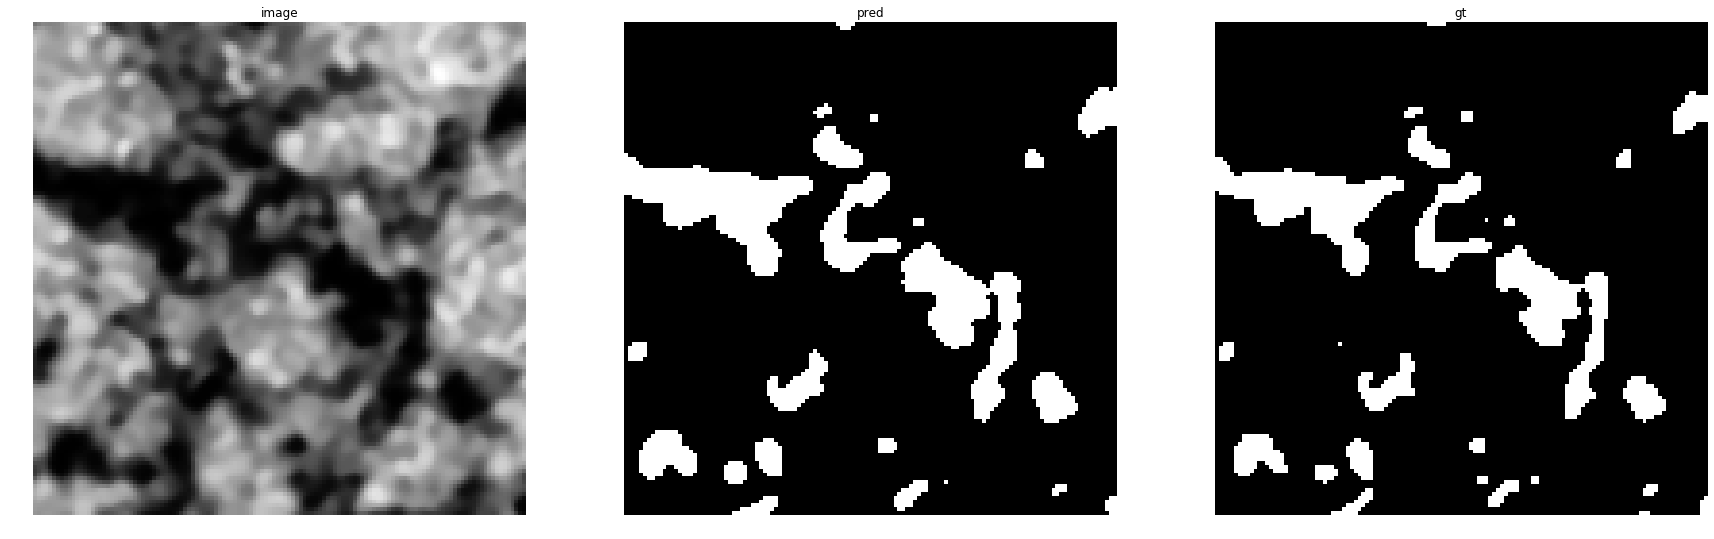

accuracy    : 0.97406005859375
precision   : 0.8341232227488151
recall      : 0.979757085020243
f1          : 0.9010937863625786
pr_auc      : 0.9870104464683453
iou         : 0.81999152901313


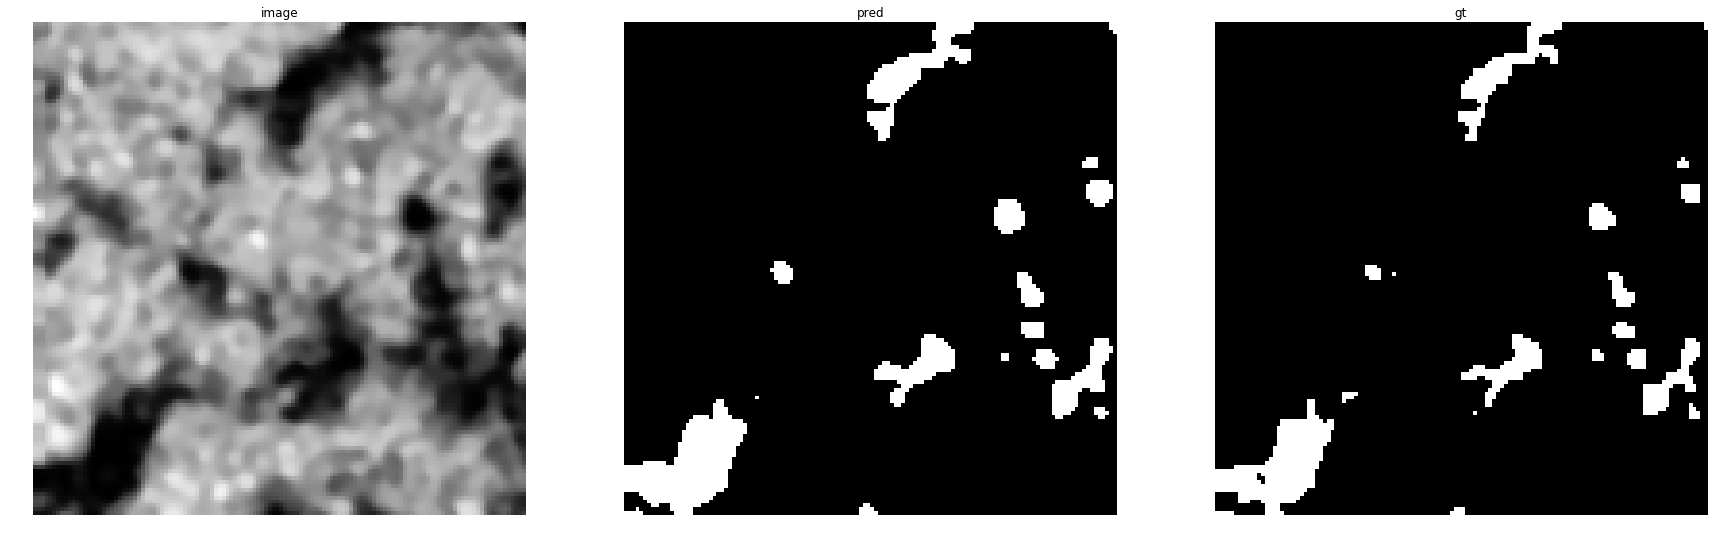

accuracy    : 0.98291015625
precision   : 0.8021472392638037
recall      : 0.9794007490636704
f1          : 0.8819561551433389
pr_auc      : 0.979065764882731
iou         : 0.7888386123680241


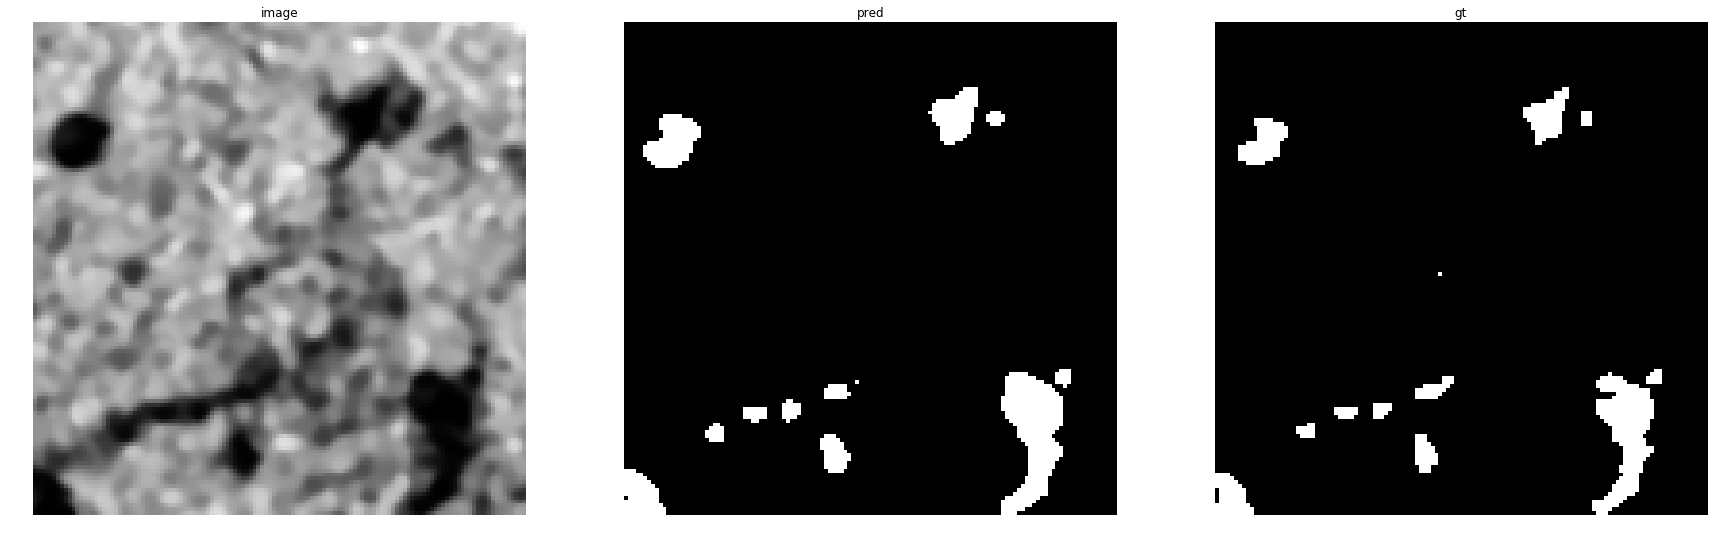

accuracy    : 0.988525390625
precision   : 0.8064516129032258
recall      : 0.9810554803788903
f1          : 0.8852258852258853
pr_auc      : 0.9846079984928793
iou         : 0.7940854326396495


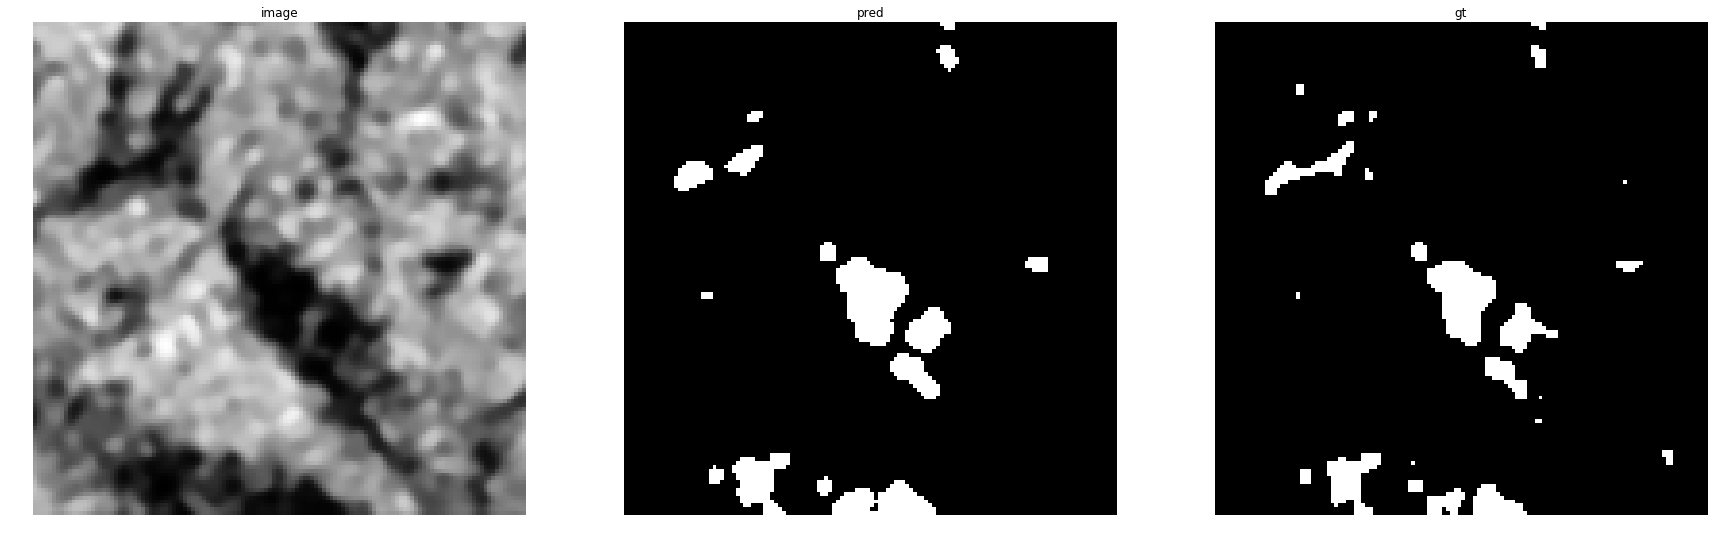

accuracy    : 0.9852294921875
precision   : 0.8212461695607763
recall      : 0.9230769230769231
f1          : 0.8691891891891892
pr_auc      : 0.964118851371789
iou         : 0.768642447418738


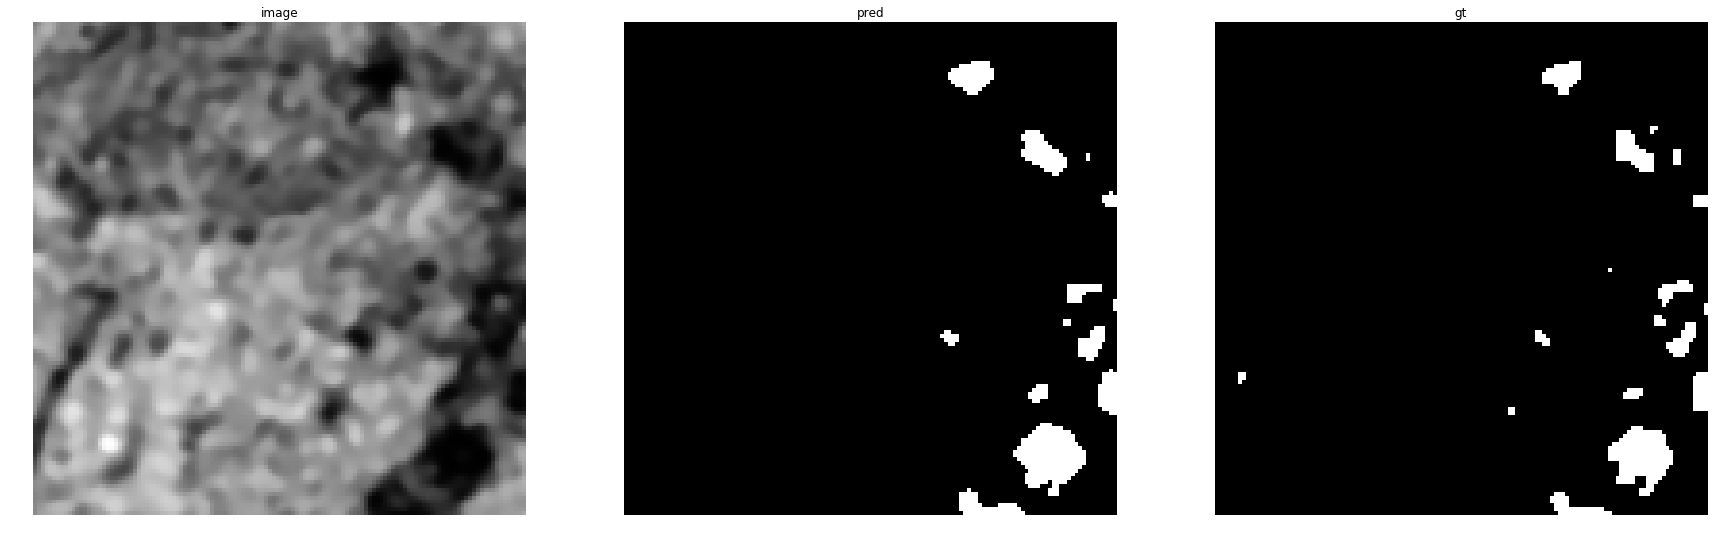

accuracy    : 0.9906005859375
precision   : 0.813614262560778
recall      : 0.9279112754158965
f1          : 0.8670120898100172
pr_auc      : 0.968782033803506
iou         : 0.7652439024390244


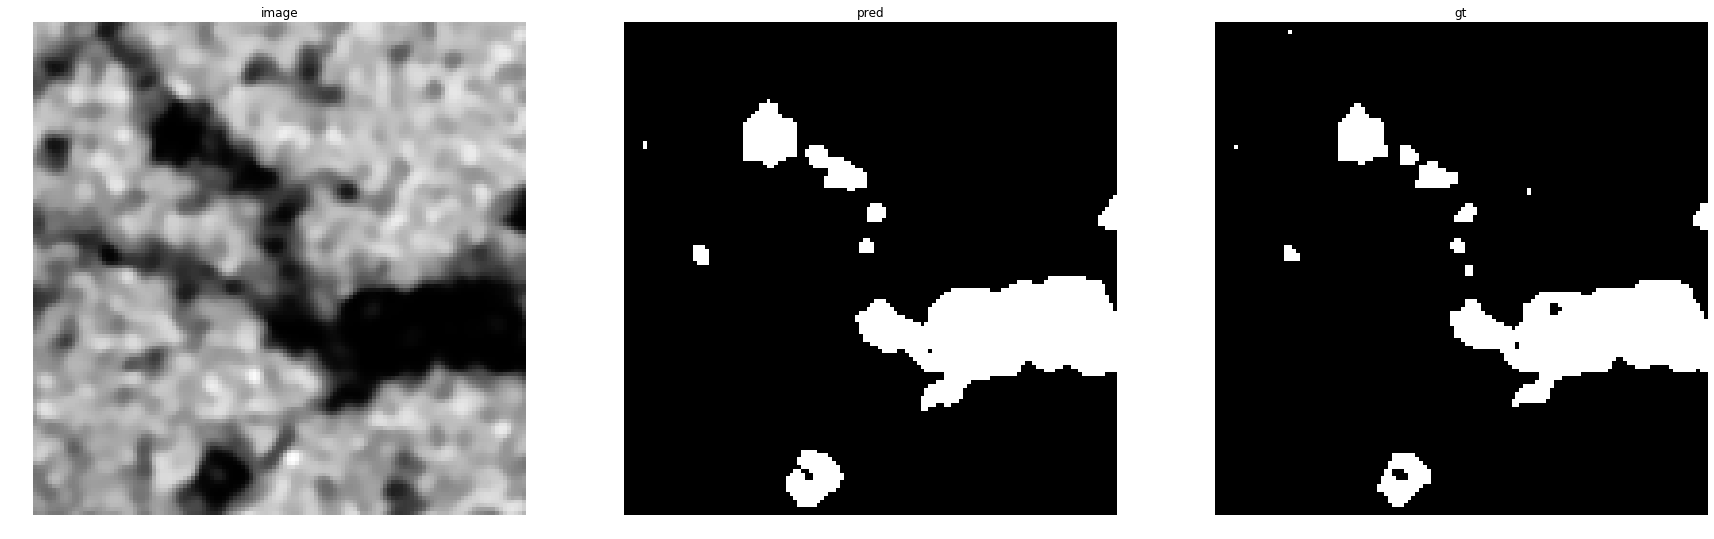

accuracy    : 0.98382568359375
precision   : 0.8666666666666667
recall      : 0.9921259842519685
f1          : 0.9251623835074838
pr_auc      : 0.994559510814857
iou         : 0.860746190225959


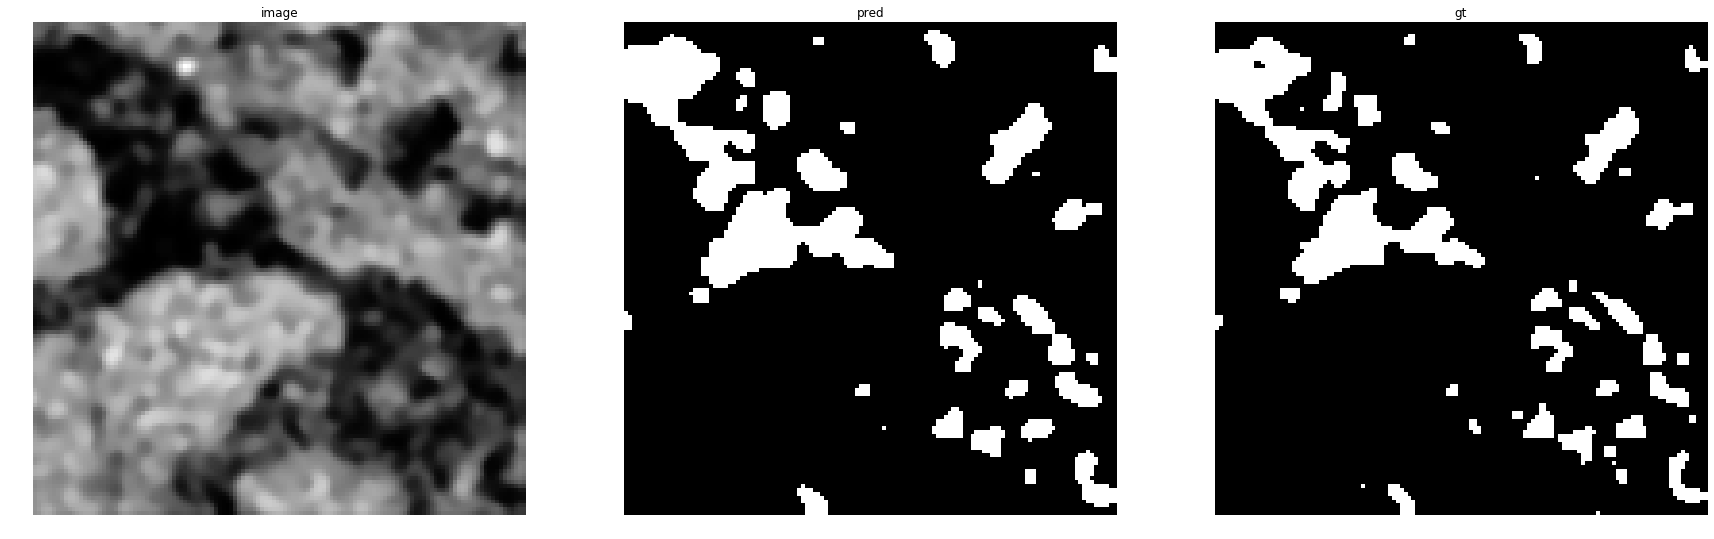

accuracy    : 0.9696044921875
precision   : 0.8451380552220888
recall      : 0.9500674763832658
f1          : 0.8945362134688691
pr_auc      : 0.978121837247345
iou         : 0.8091954022988506


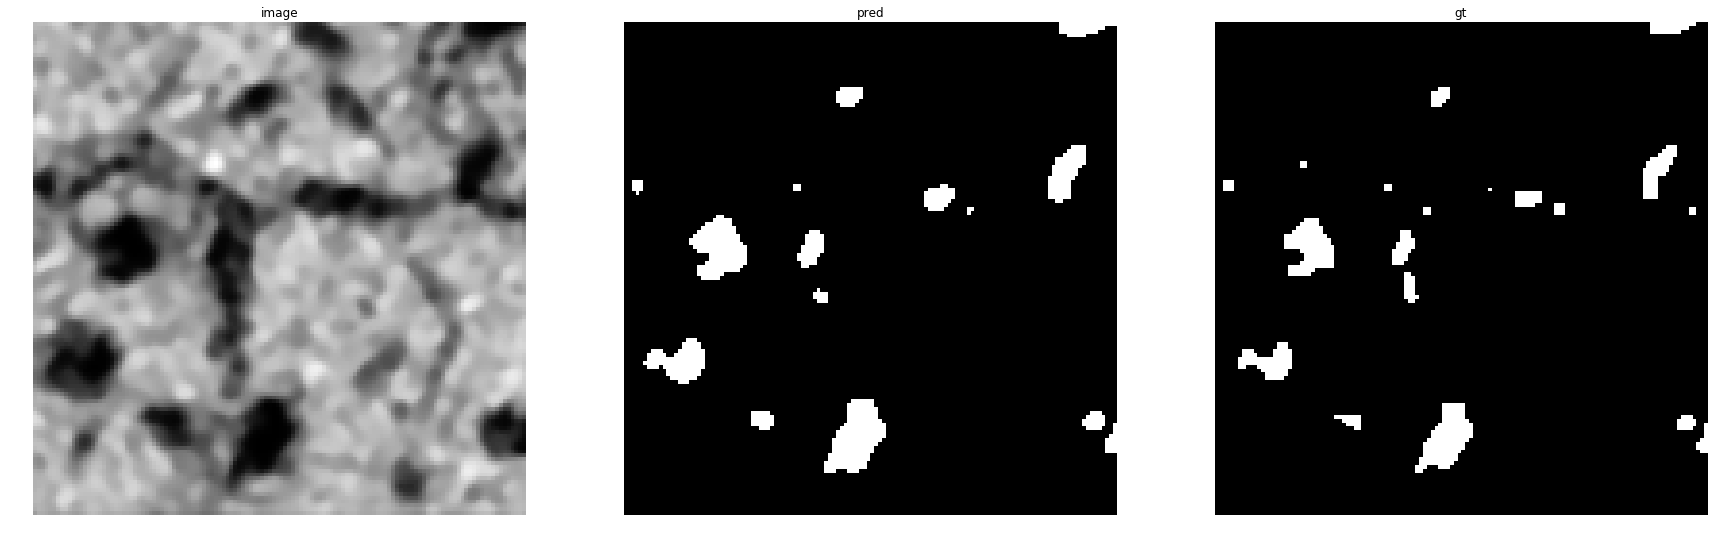

accuracy    : 0.9857177734375
precision   : 0.754601226993865
recall      : 0.9476117103235747
f1          : 0.8401639344262295
pr_auc      : 0.9635280926492865
iou         : 0.7243816254416962


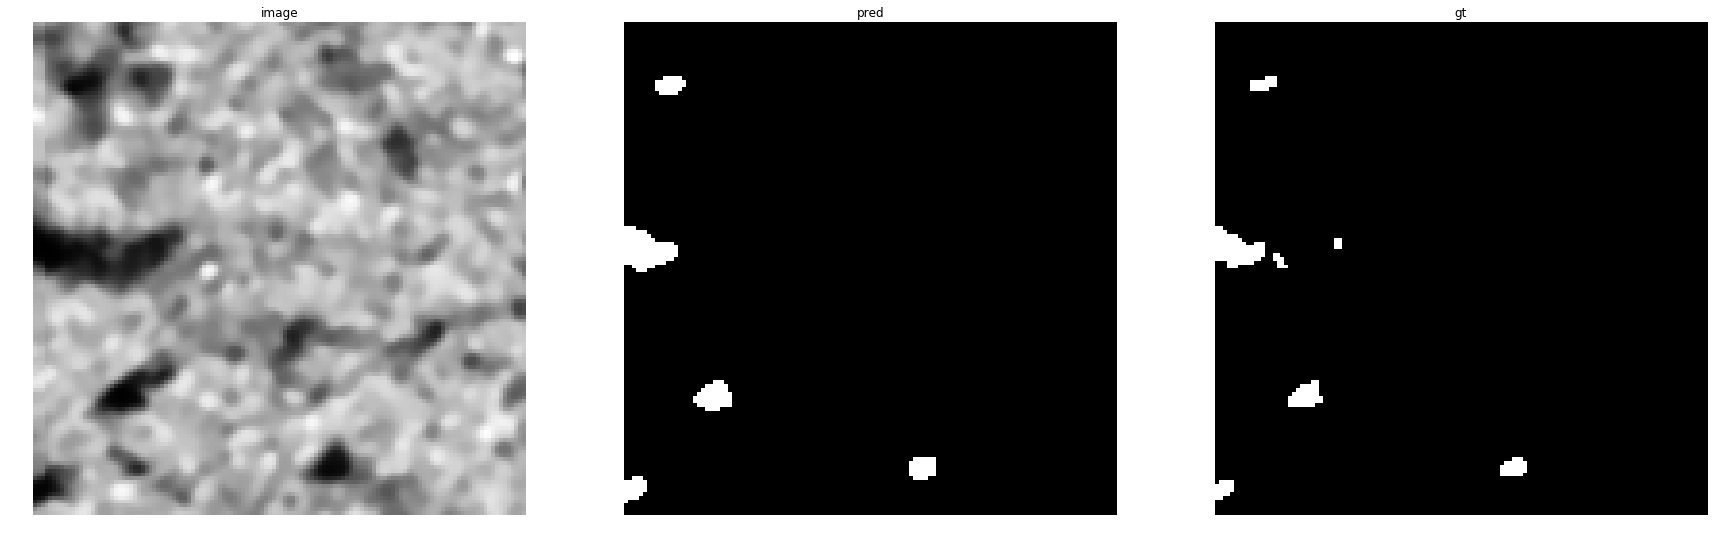

accuracy    : 0.9947509765625
precision   : 0.75
recall      : 0.918918918918919
f1          : 0.8259109311740892
pr_auc      : 0.957513675097244
iou         : 0.7034482758620689


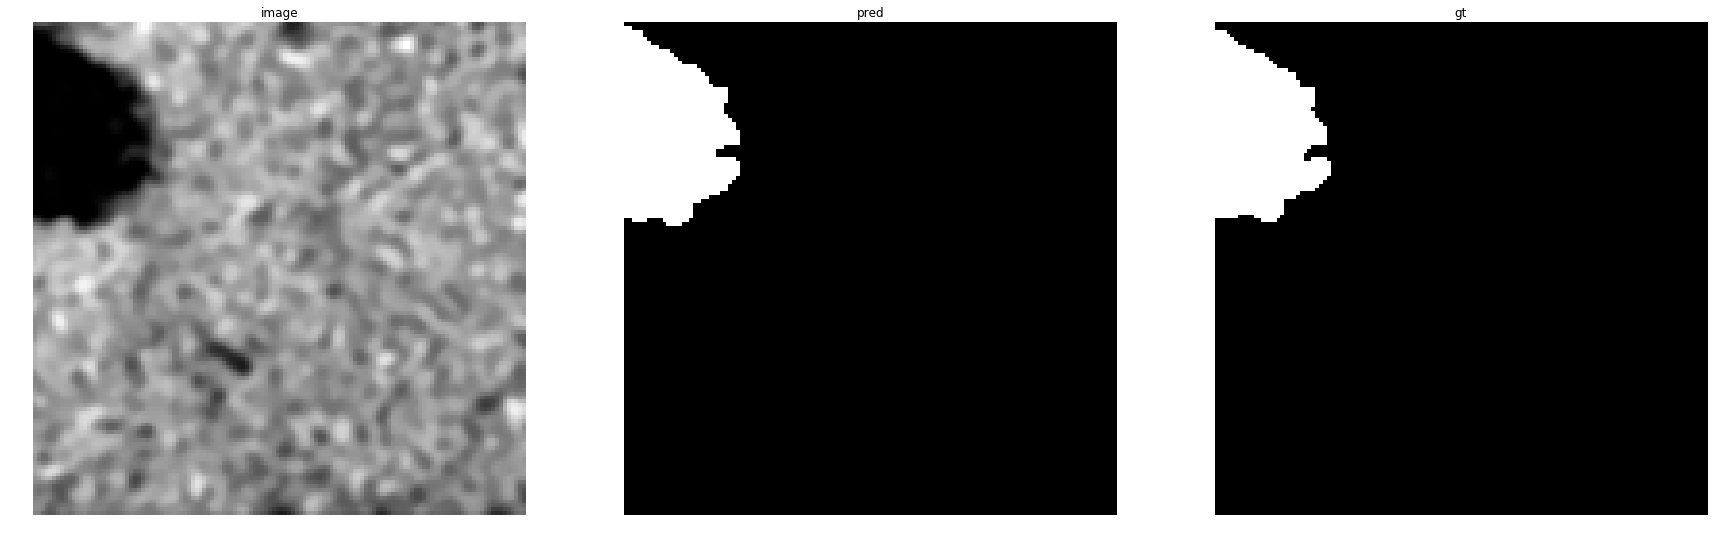

accuracy    : 0.99664306640625
precision   : 0.9509803921568627
recall      : 1.0
f1          : 0.9748743718592965
pr_auc      : 0.9998705655045995
iou         : 0.9509803921568627


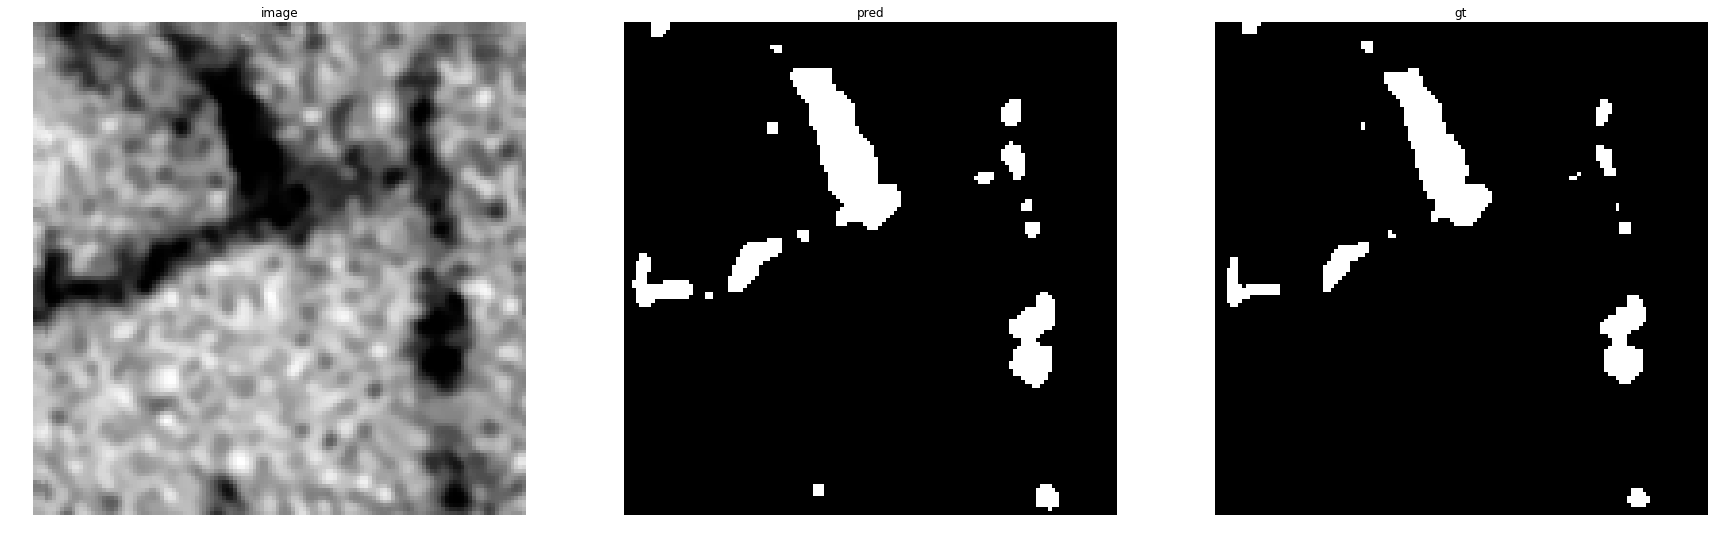

accuracy    : 0.98577880859375
precision   : 0.7969991173874669
recall      : 0.9966887417218543
f1          : 0.8857282981853849
pr_auc      : 0.993924352732554
iou         : 0.7948943661971831


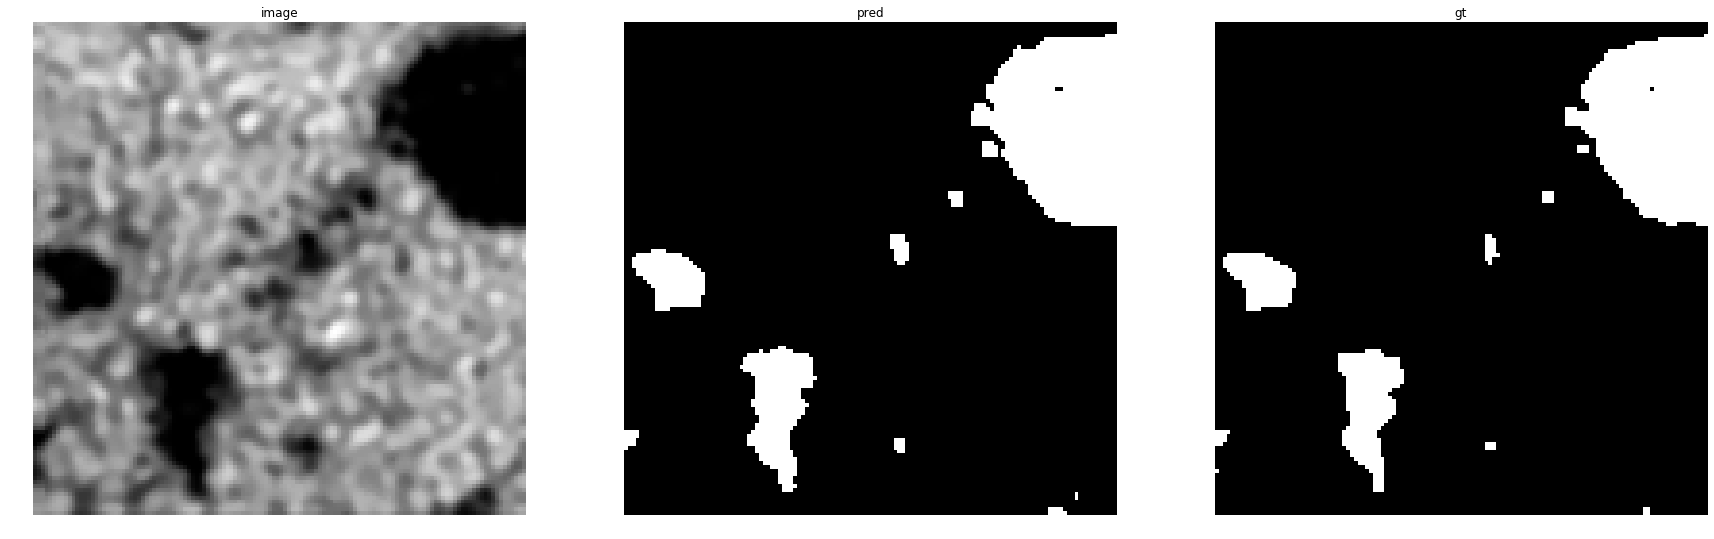

accuracy    : 0.99041748046875
precision   : 0.9259436215957955
recall      : 0.9989690721649485
f1          : 0.9610711629060252
pr_auc      : 0.9994164441574862
iou         : 0.9250596658711218


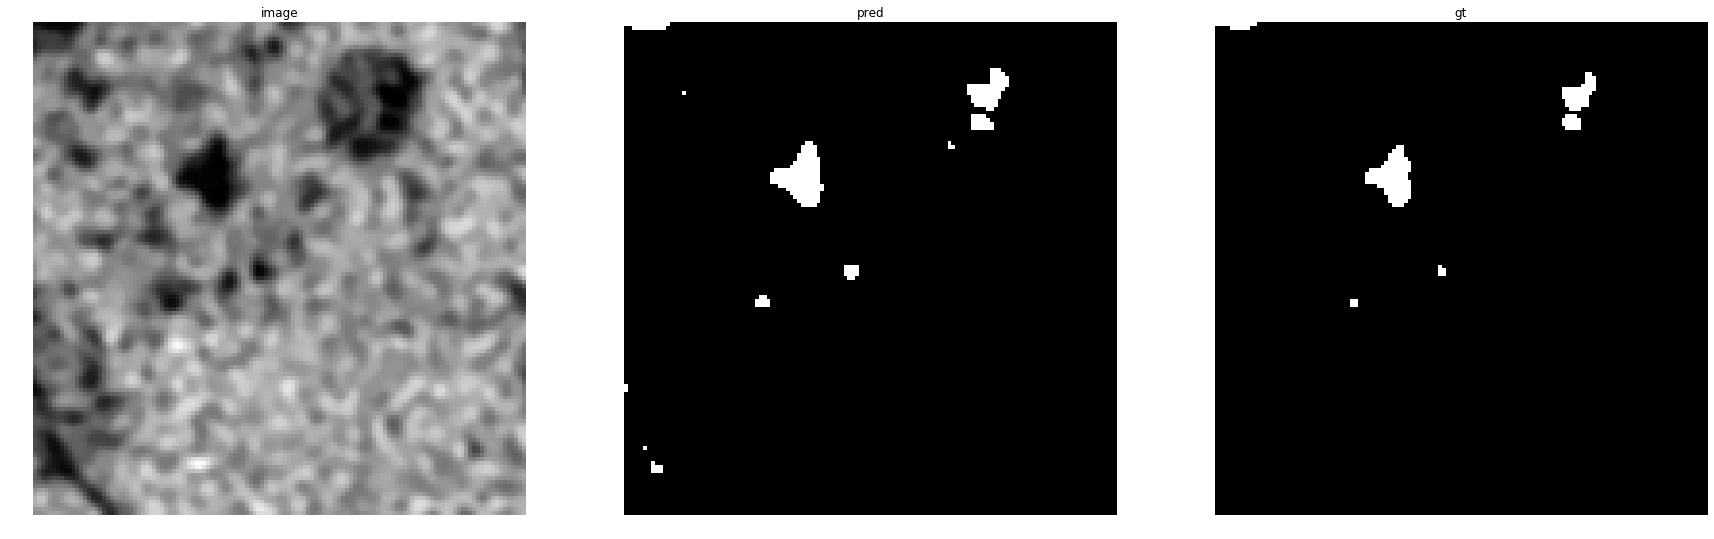

accuracy    : 0.994873046875
precision   : 0.7112676056338029
recall      : 0.9901960784313726
f1          : 0.8278688524590163
pr_auc      : 0.9901744628258898
iou         : 0.7062937062937062


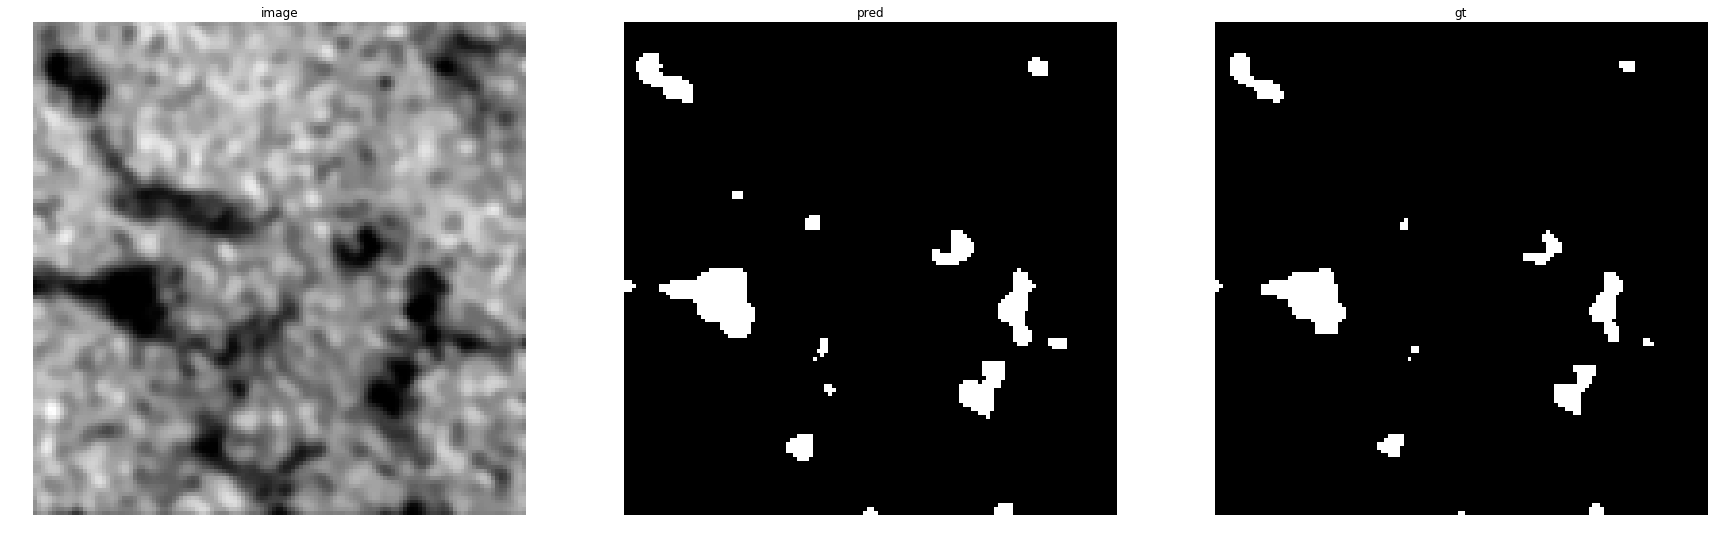

accuracy    : 0.98797607421875
precision   : 0.7393617021276596
recall      : 0.9982046678635548
f1          : 0.8495034377387319
pr_auc      : 0.9897393339032481
iou         : 0.7383798140770252


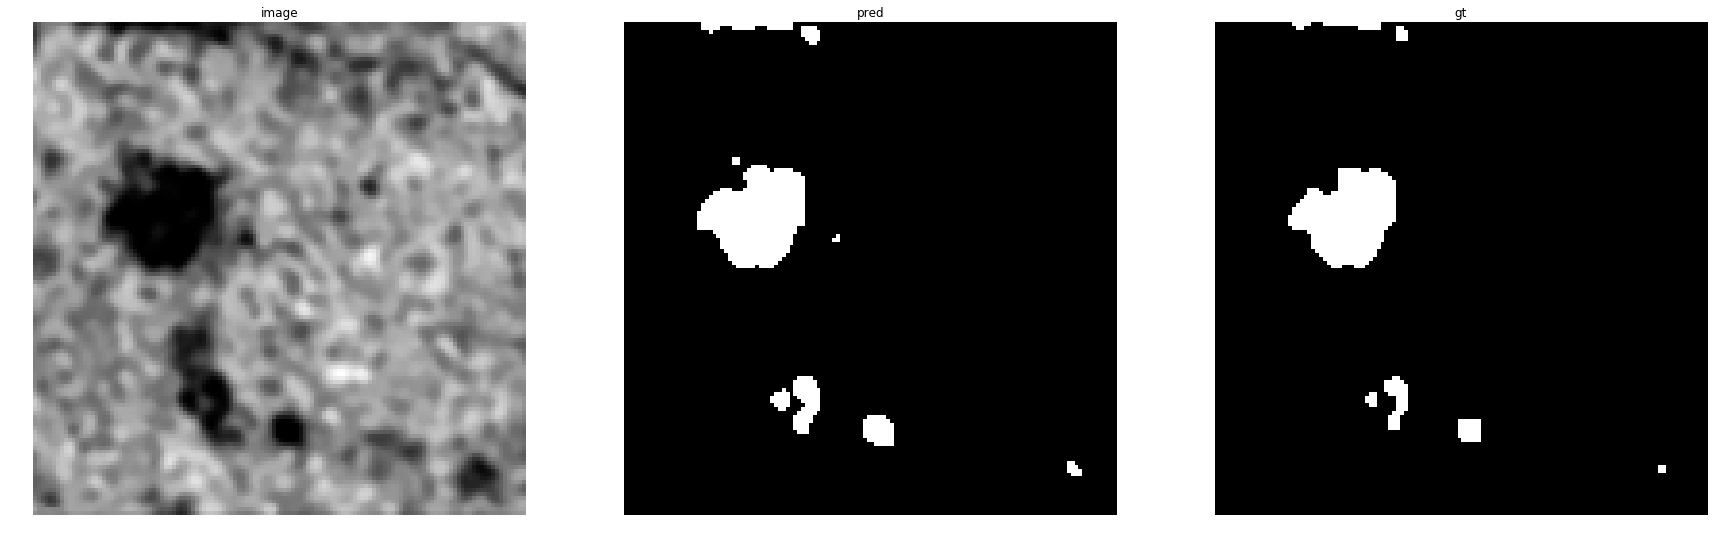

accuracy    : 0.9921875
precision   : 0.8333333333333334
recall      : 0.9984276729559748
f1          : 0.9084406294706724
pr_auc      : 0.9978903946305564
iou         : 0.8322411533420708


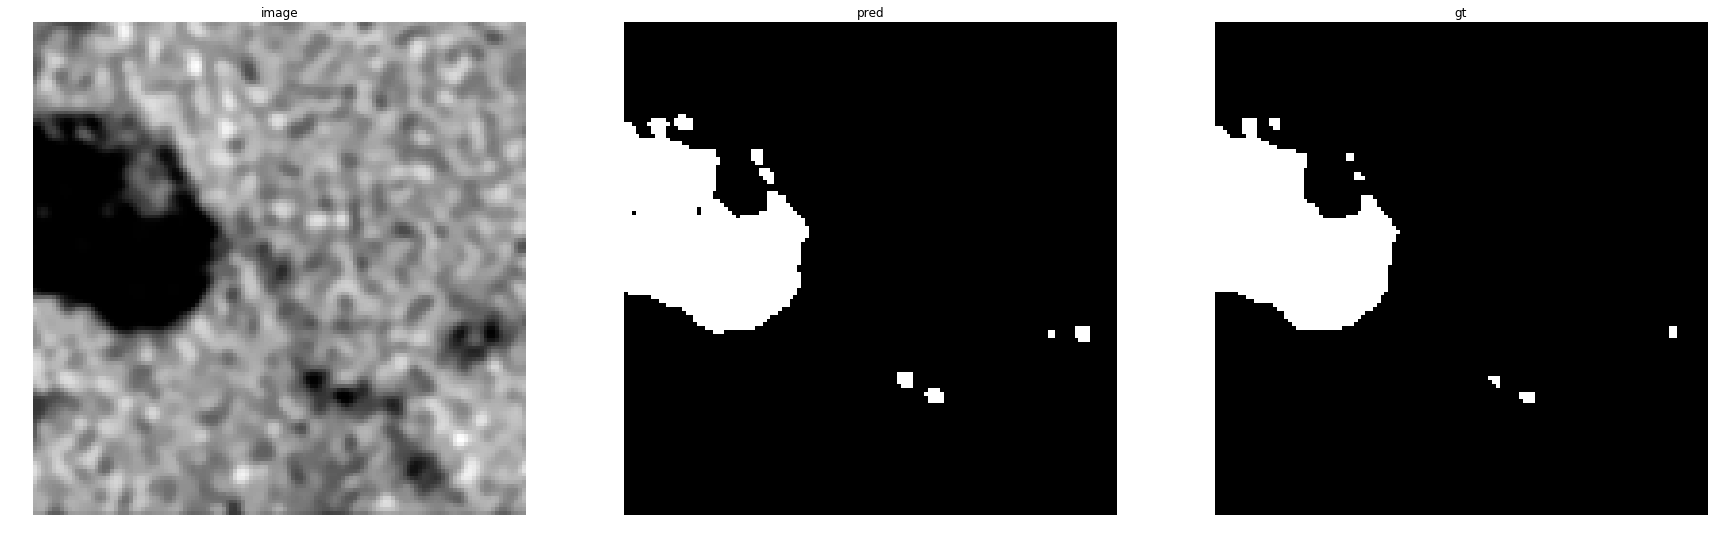

accuracy    : 0.99249267578125
precision   : 0.9337382661512976
recall      : 0.9982290436835891
f1          : 0.96490727532097
pr_auc      : 0.9994496040916869
iou         : 0.9321940463065049


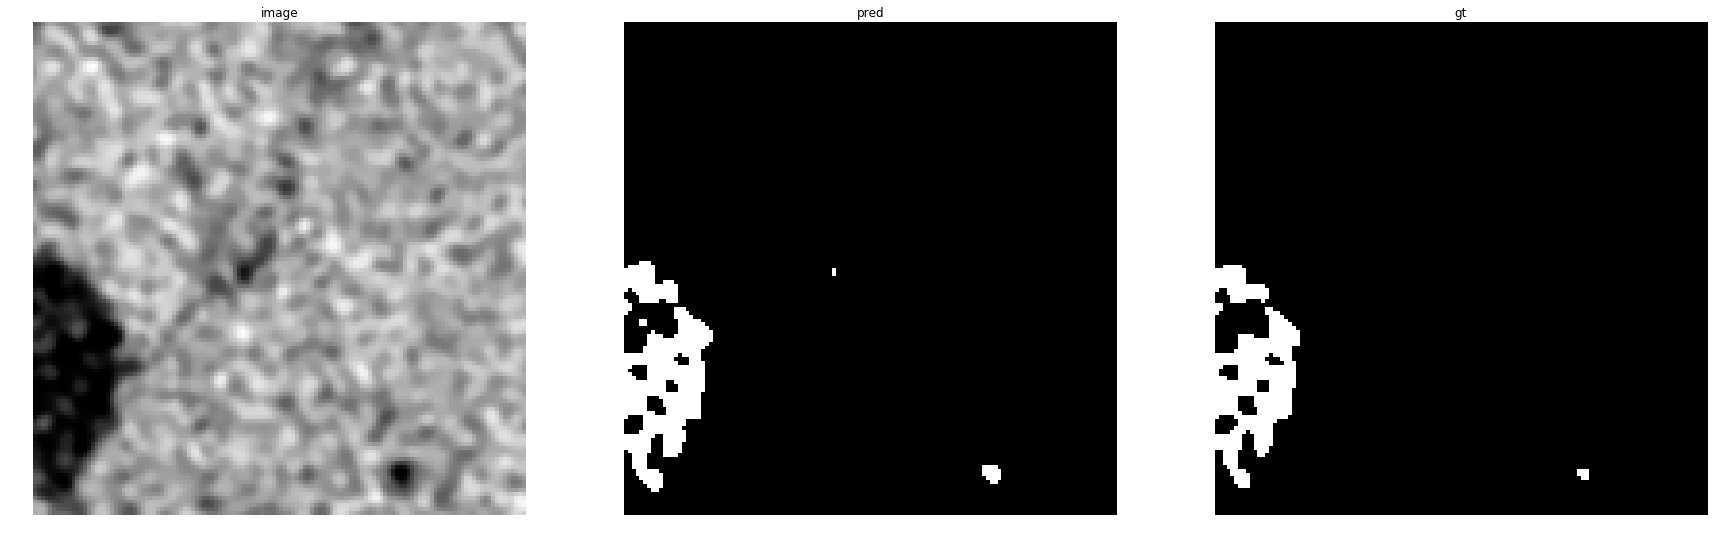

accuracy    : 0.99530029296875
precision   : 0.8904694167852063
recall      : 1.0
f1          : 0.9420617005267118
pr_auc      : 0.9957700234708231
iou         : 0.8904694167852063


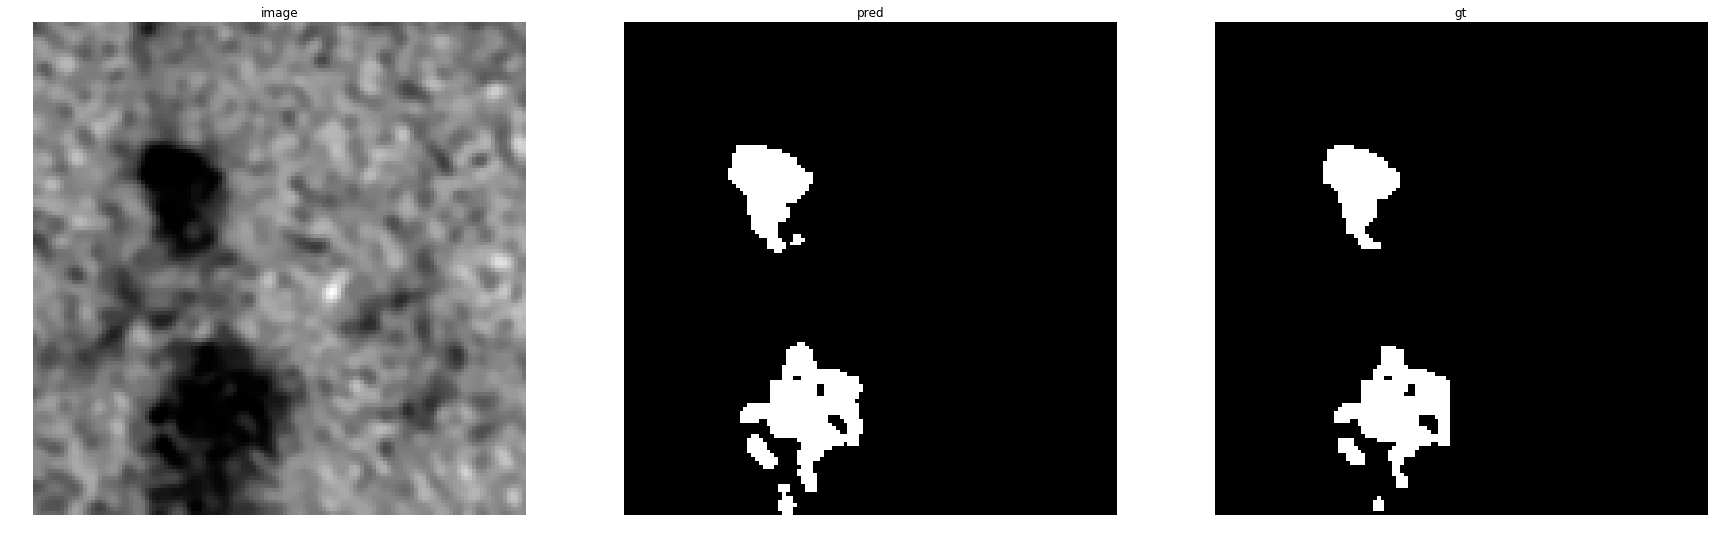

accuracy    : 0.9925537109375
precision   : 0.8799171842650103
recall      : 0.9929906542056075
f1          : 0.9330406147091108
pr_auc      : 0.9954195896358753
iou         : 0.8744855967078189


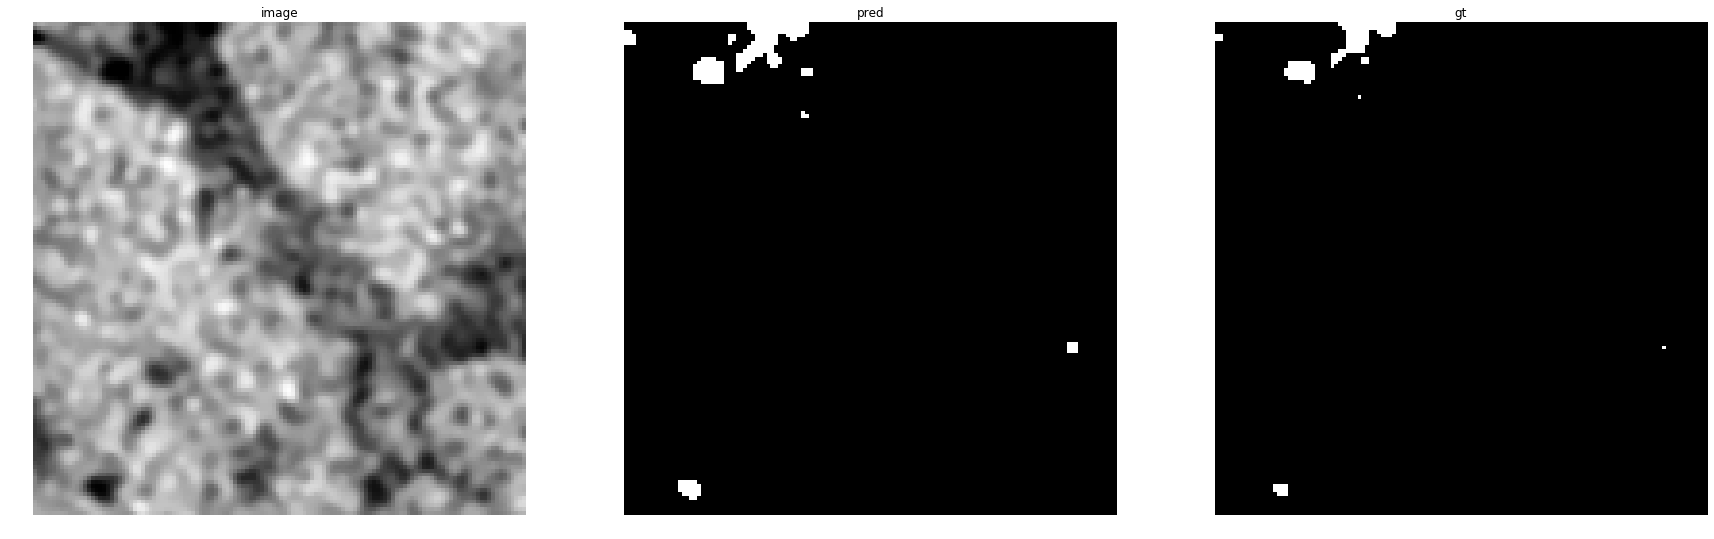

accuracy    : 0.99456787109375
precision   : 0.6157205240174672
recall      : 0.9929577464788732
f1          : 0.7601078167115903
pr_auc      : 0.9787183183174263
iou         : 0.6130434782608696


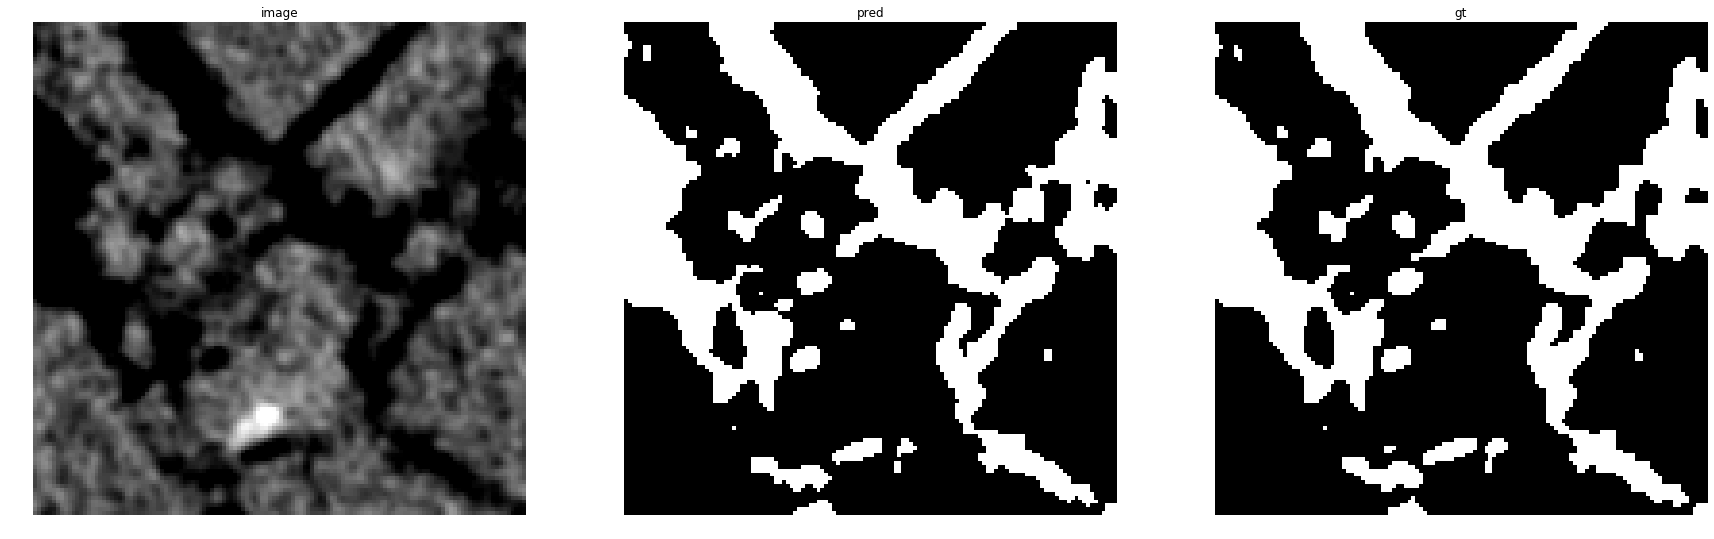

accuracy    : 0.98370361328125
precision   : 0.9943691345151199
recall      : 0.952076677316294
f1          : 0.9727634397633378
pr_auc      : 0.9986230589859248
iou         : 0.9469712015888778


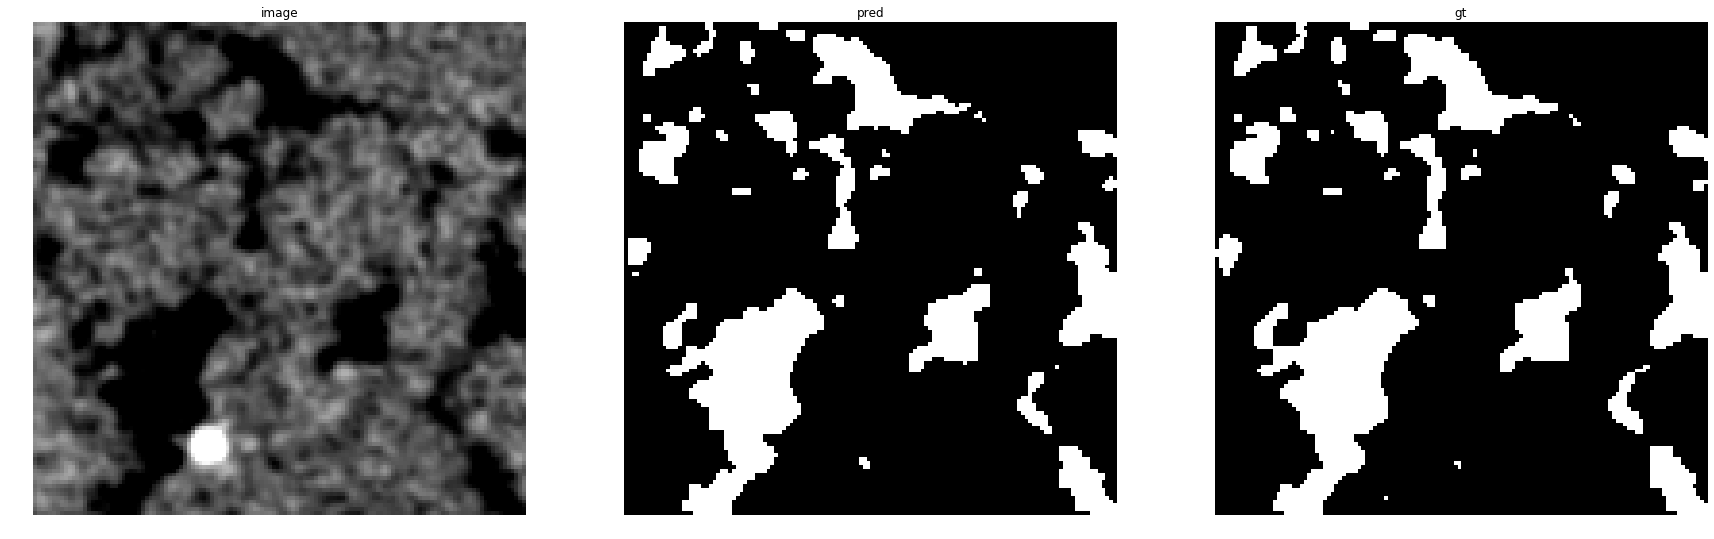

accuracy    : 0.988525390625
precision   : 0.9895116355293346
recall      : 0.9508661417322835
f1          : 0.9698040475425634
pr_auc      : 0.9977630682813206
iou         : 0.9413782351106954


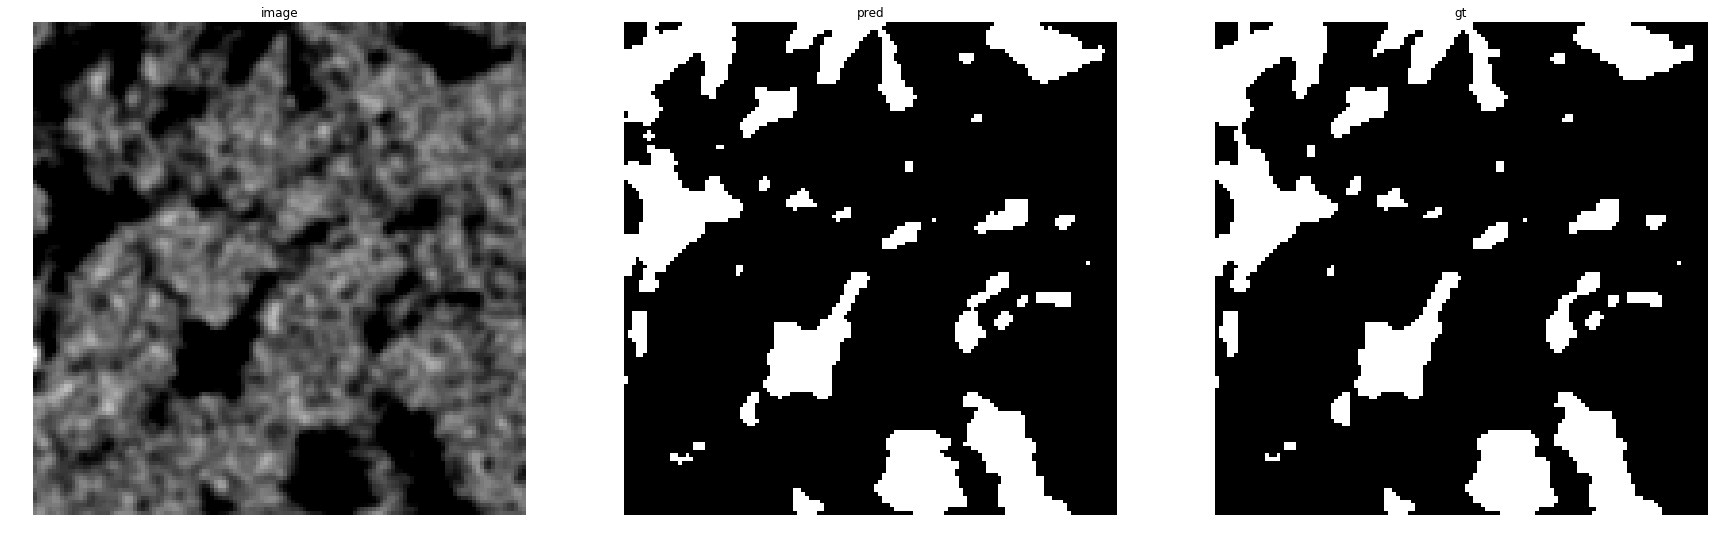

accuracy    : 0.98876953125
precision   : 0.9854036341971999
recall      : 0.9607900087133314
f1          : 0.9729411764705882
pr_auc      : 0.9974693916206528
iou         : 0.9473081328751431


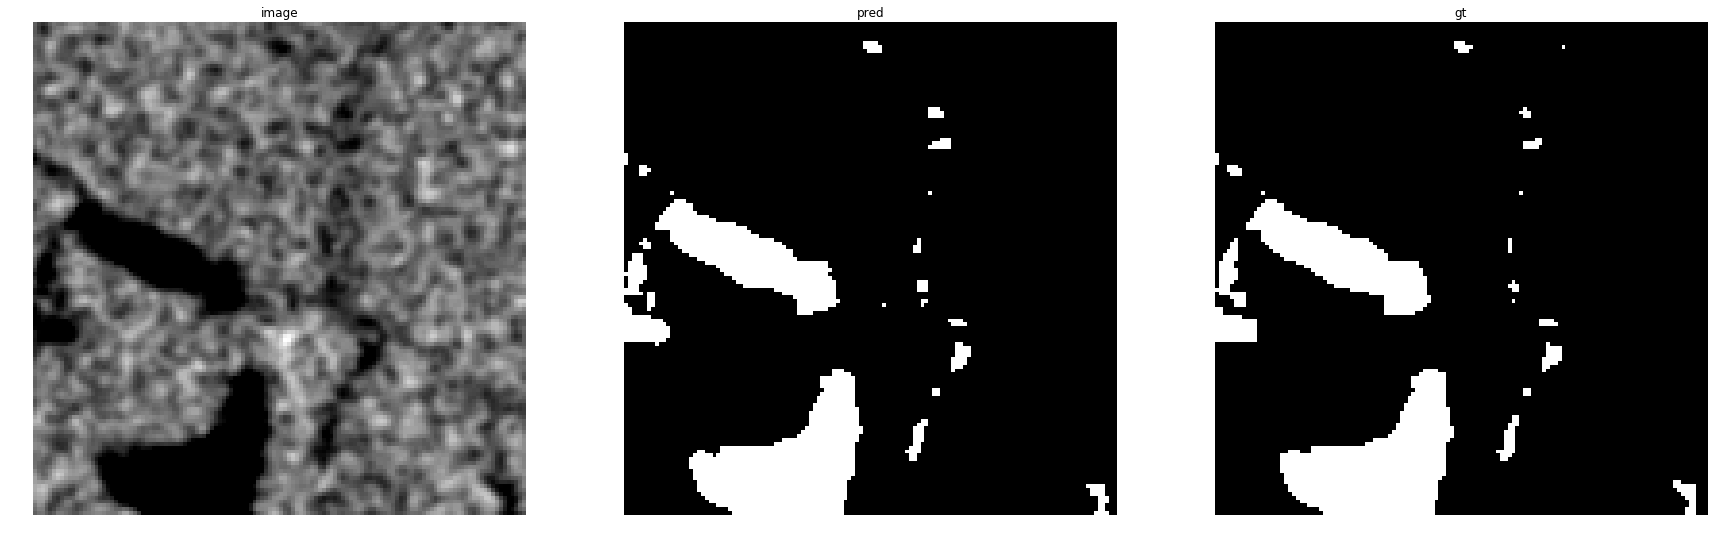

accuracy    : 0.9940185546875
precision   : 0.9794672586015538
recall      : 0.9665936473165389
f1          : 0.9729878721058434
pr_auc      : 0.9979656105989859
iou         : 0.9473966720343532


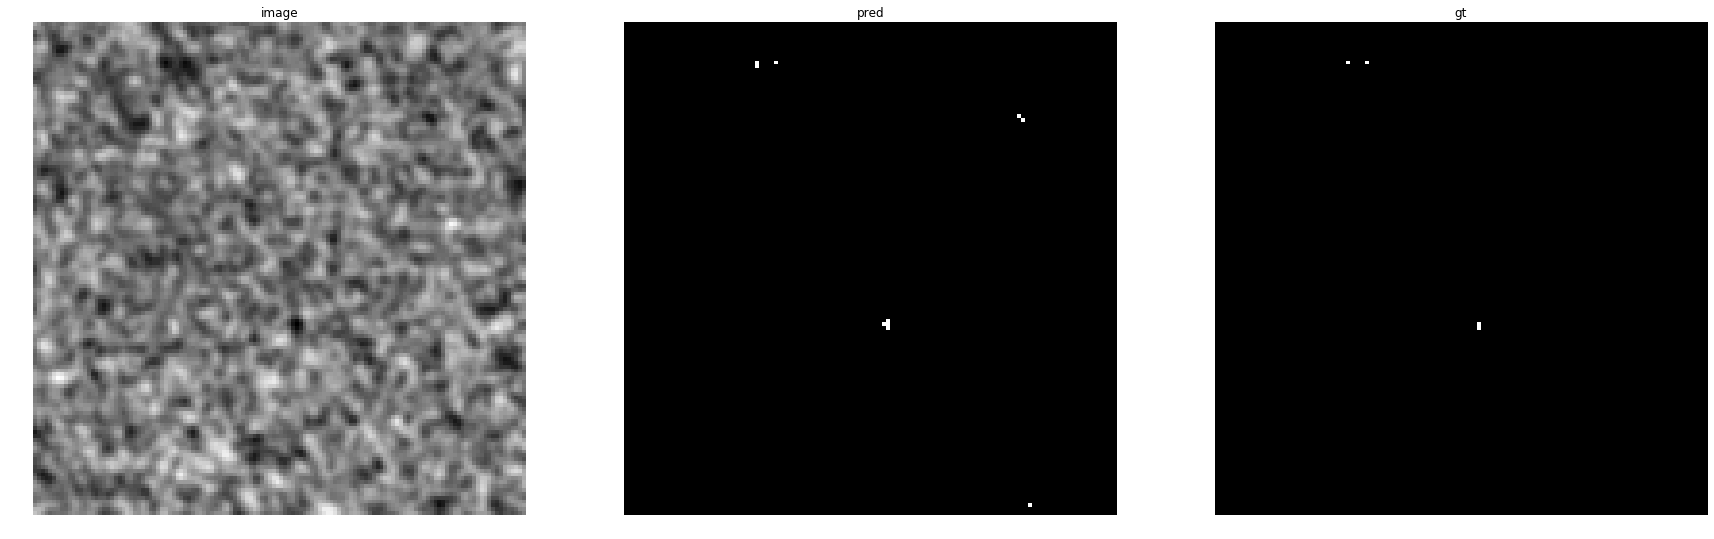

accuracy    : 0.9996337890625
precision   : 0.4
recall      : 1.0
f1          : 0.5714285714285715
pr_auc      : 0.95
iou         : 0.4


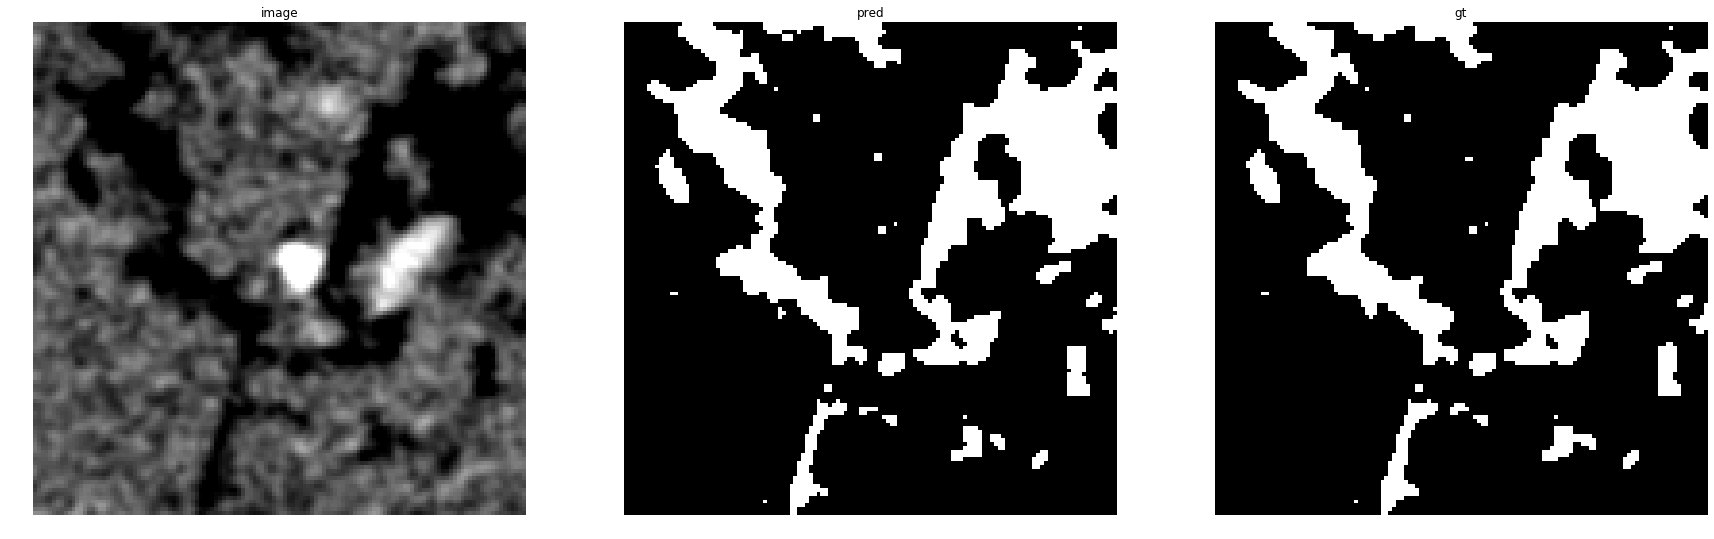

accuracy    : 0.98876953125
precision   : 0.9915045217867909
recall      : 0.9594272076372315
f1          : 0.9752021563342318
pr_auc      : 0.9977946843684811
iou         : 0.9516044187269858


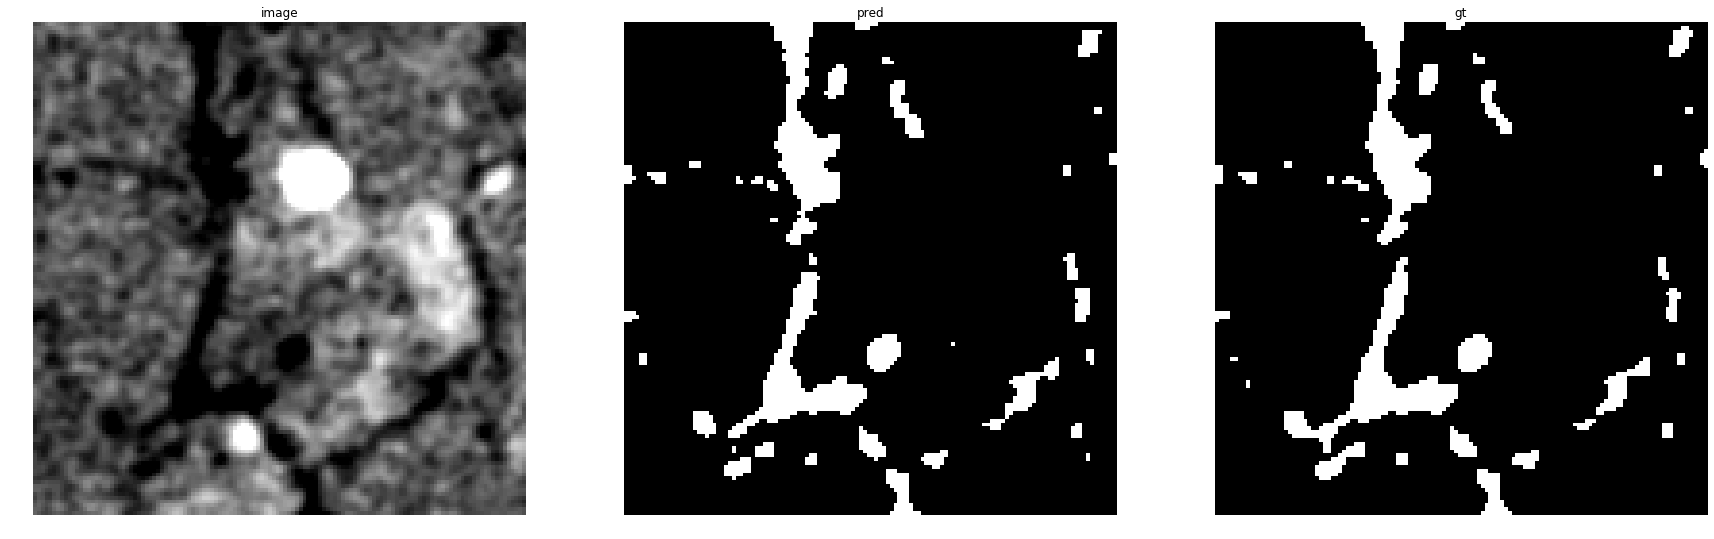

accuracy    : 0.98956298828125
precision   : 0.9478203434610304
recall      : 0.9397511460379829
f1          : 0.9437684972048669
pr_auc      : 0.9889038315192288
iou         : 0.8935242839352429


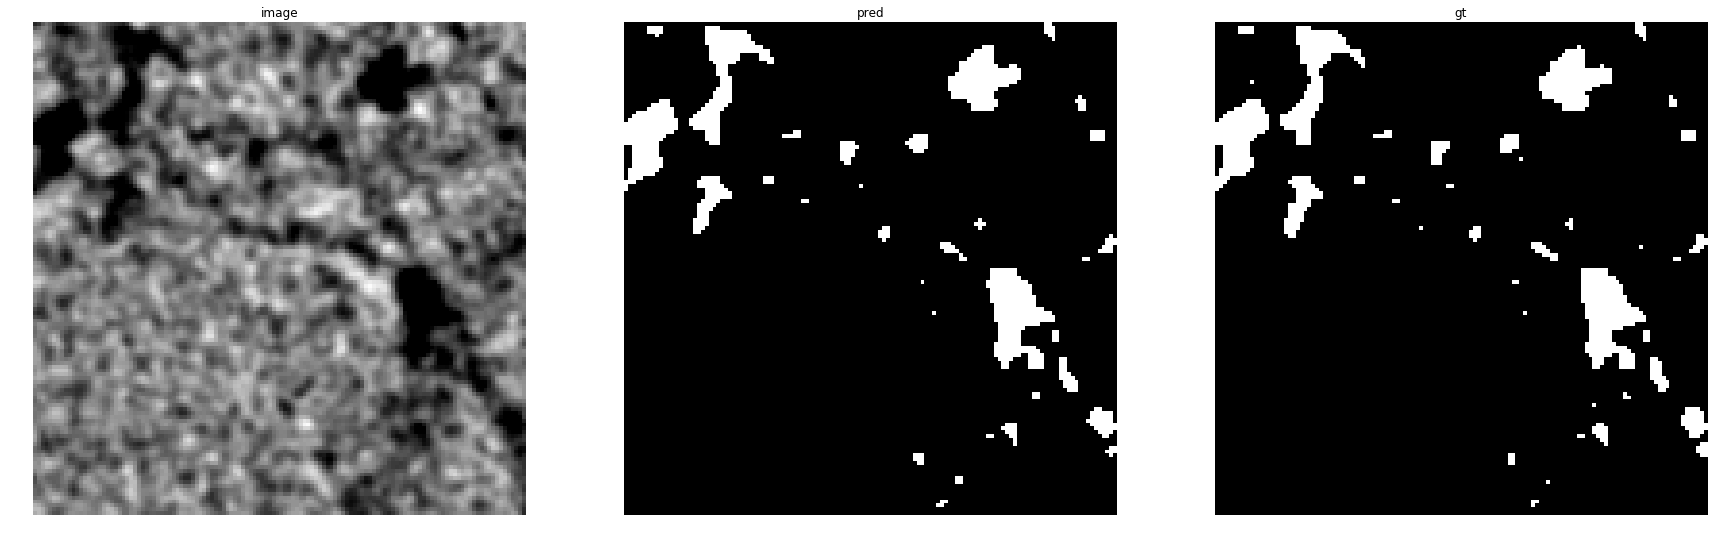

accuracy    : 0.9940185546875
precision   : 0.9702886247877759
recall      : 0.9477611940298507
f1          : 0.9588926174496645
pr_auc      : 0.9944026036256899
iou         : 0.9210314262691378


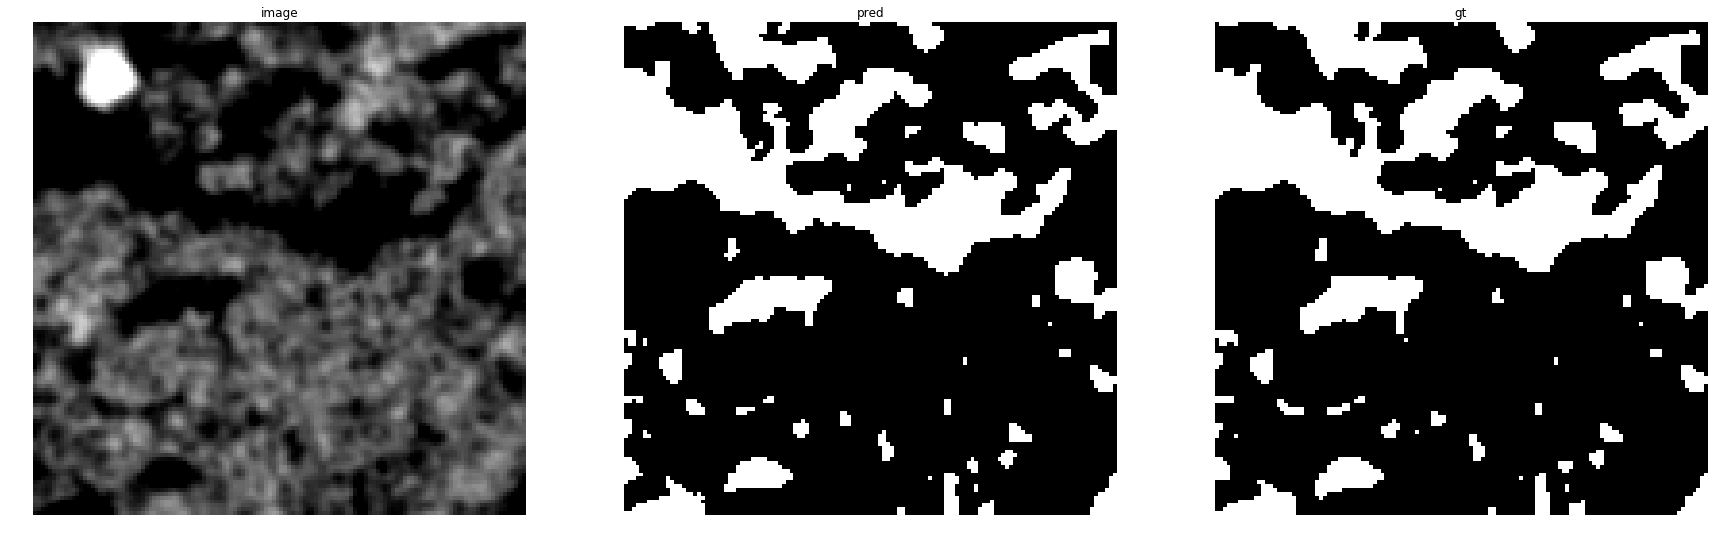

accuracy    : 0.982421875
precision   : 0.9782354317809502
recall      : 0.9554285714285714
f1          : 0.9666975023126735
pr_auc      : 0.9970118652111738
iou         : 0.9355416293643688


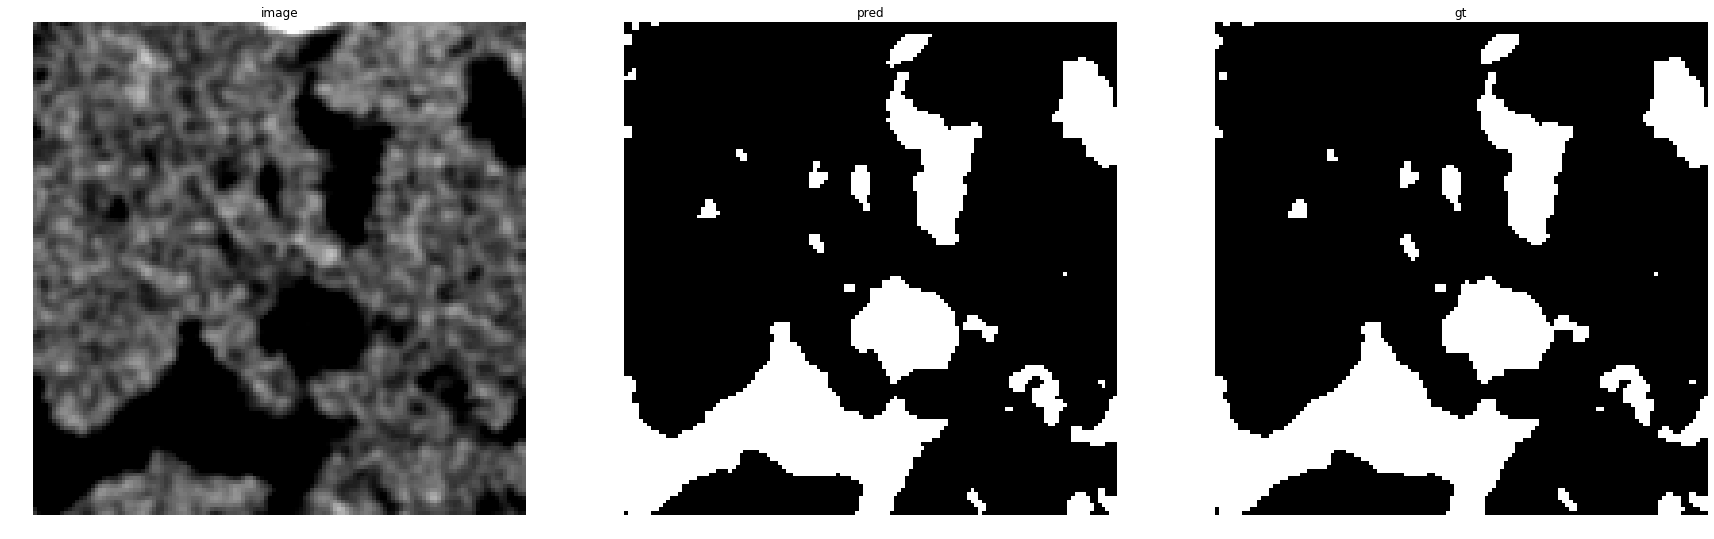

accuracy    : 0.990966796875
precision   : 0.9807959922070693
recall      : 0.9780738273660838
f1          : 0.9794330183435241
pr_auc      : 0.9988212842501472
iou         : 0.9596949891067538


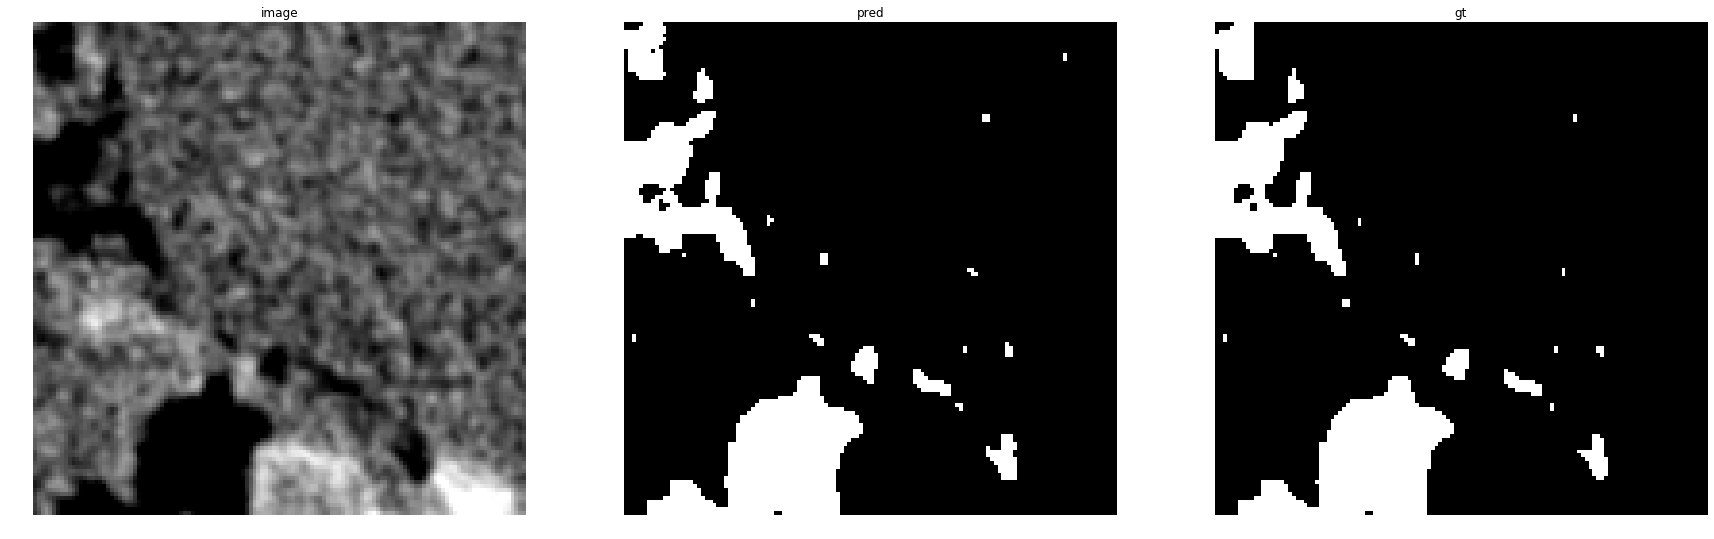

accuracy    : 0.994140625
precision   : 0.9675675675675676
recall      : 0.984992496248124
f1          : 0.9762022806147744
pr_auc      : 0.9985433294389139
iou         : 0.9535108958837772


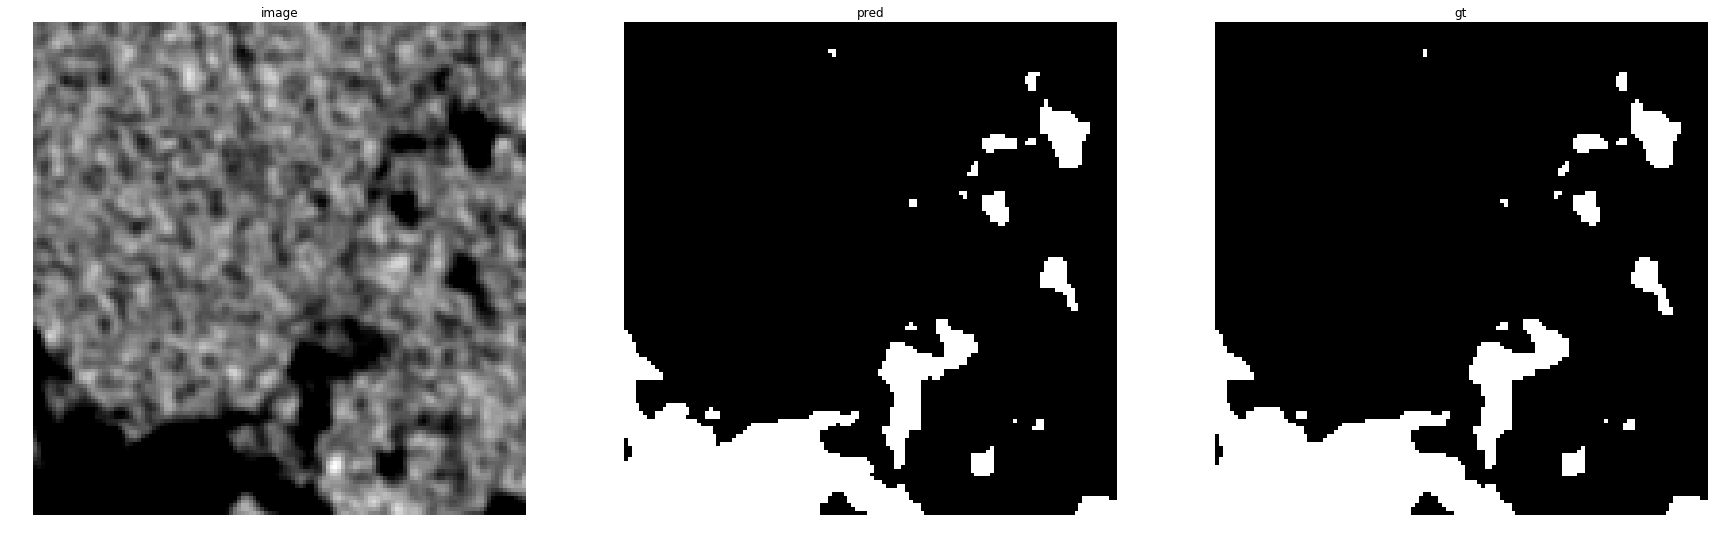

accuracy    : 0.99444580078125
precision   : 0.9900497512437811
recall      : 0.9727087576374746
f1          : 0.9813026505033902
pr_auc      : 0.9990302656522118
iou         : 0.963291649858814


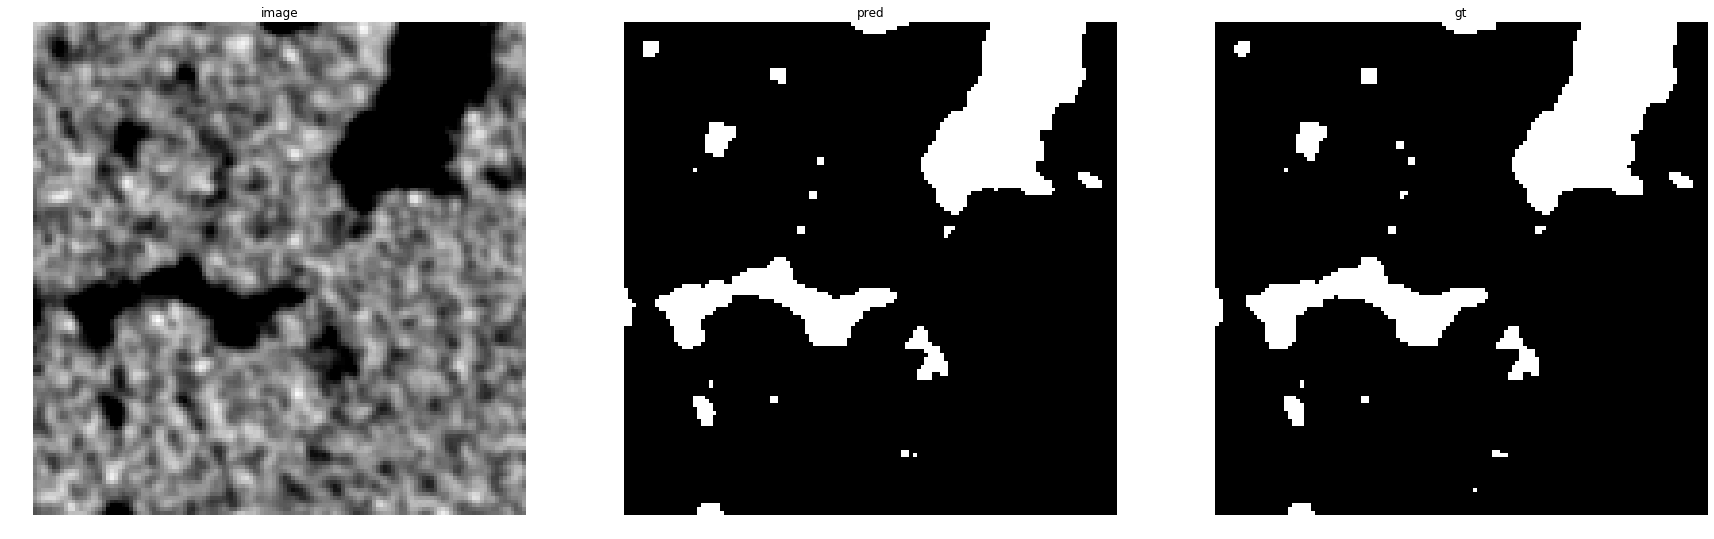

accuracy    : 0.9949951171875
precision   : 0.9920856610800745
recall      : 0.9704007285974499
f1          : 0.9811233885819521
pr_auc      : 0.9986927086764696
iou         : 0.9629462268413918


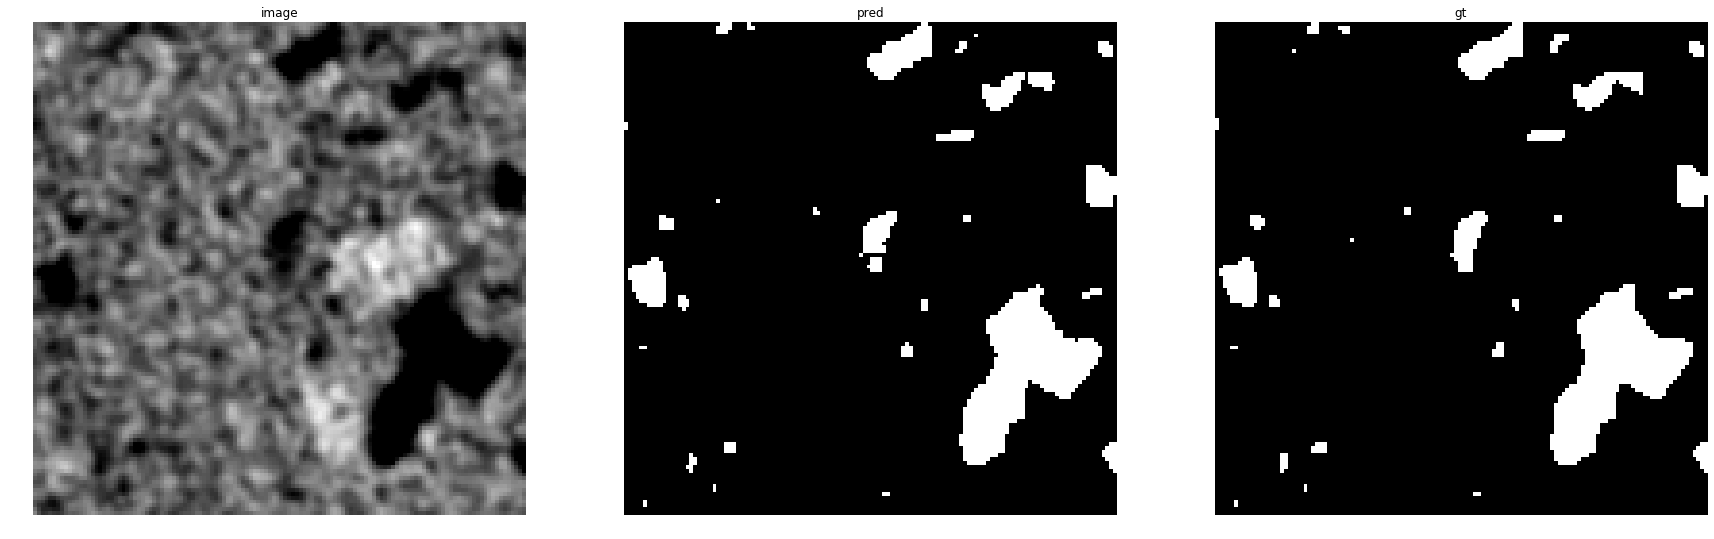

accuracy    : 0.9942626953125
precision   : 0.984452296819788
recall      : 0.9508532423208191
f1          : 0.967361111111111
pr_auc      : 0.9972487432074091
iou         : 0.9367854741089442


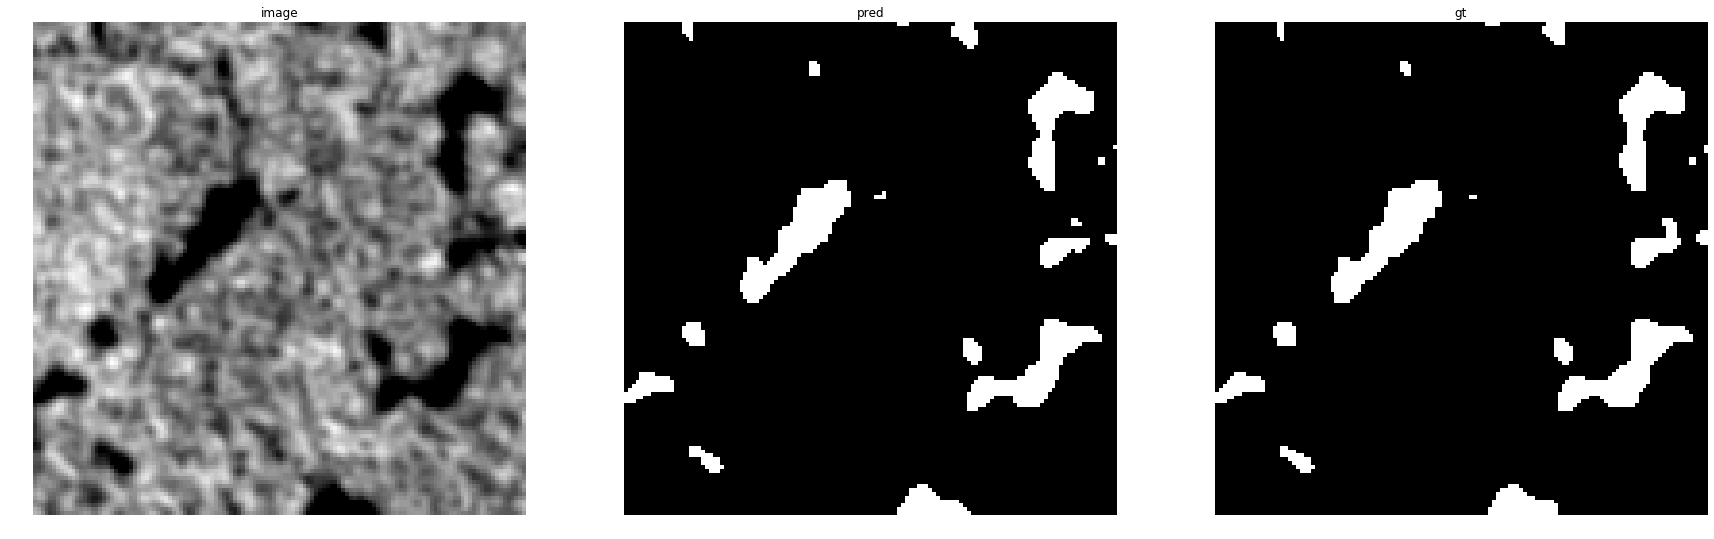

accuracy    : 0.99566650390625
precision   : 0.9864
recall      : 0.958041958041958
f1          : 0.972014189988175
pr_auc      : 0.9979550126411075
iou         : 0.9455521472392638


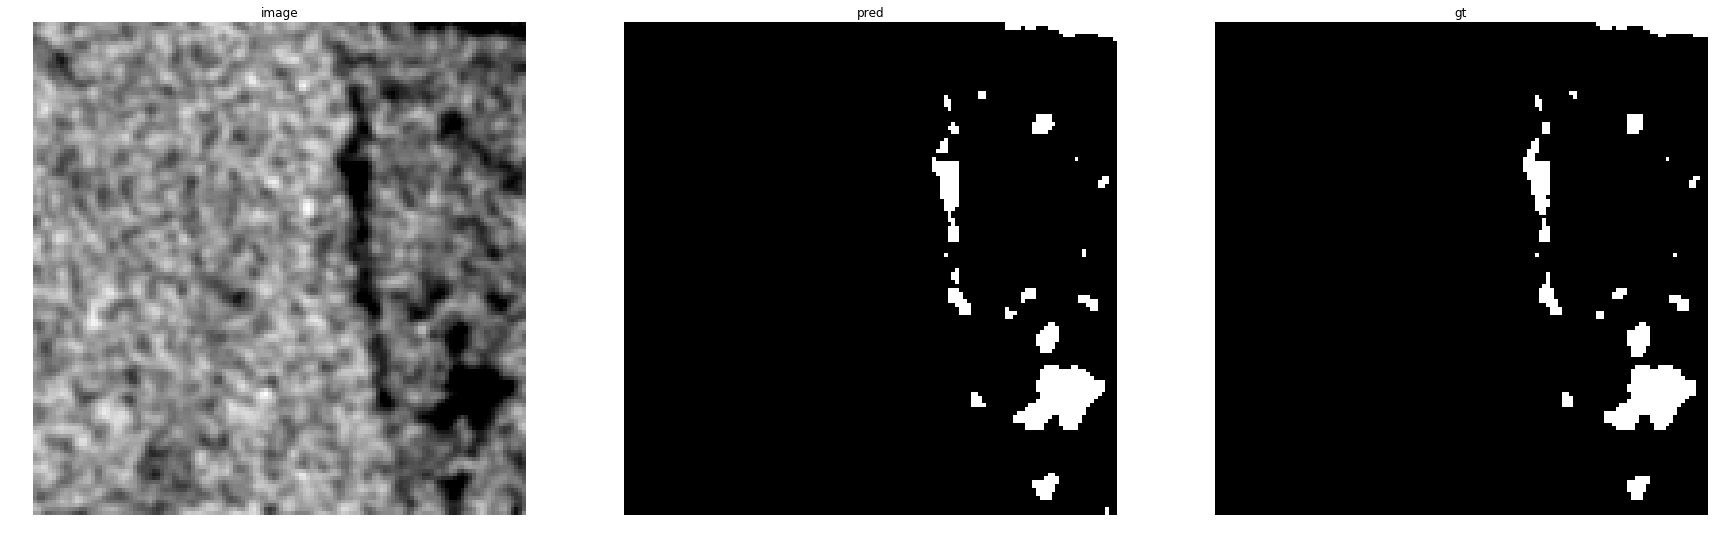

accuracy    : 0.99627685546875
precision   : 0.9377049180327869
recall      : 0.9613445378151261
f1          : 0.9493775933609959
pr_auc      : 0.9941964317525018
iou         : 0.9036334913112164


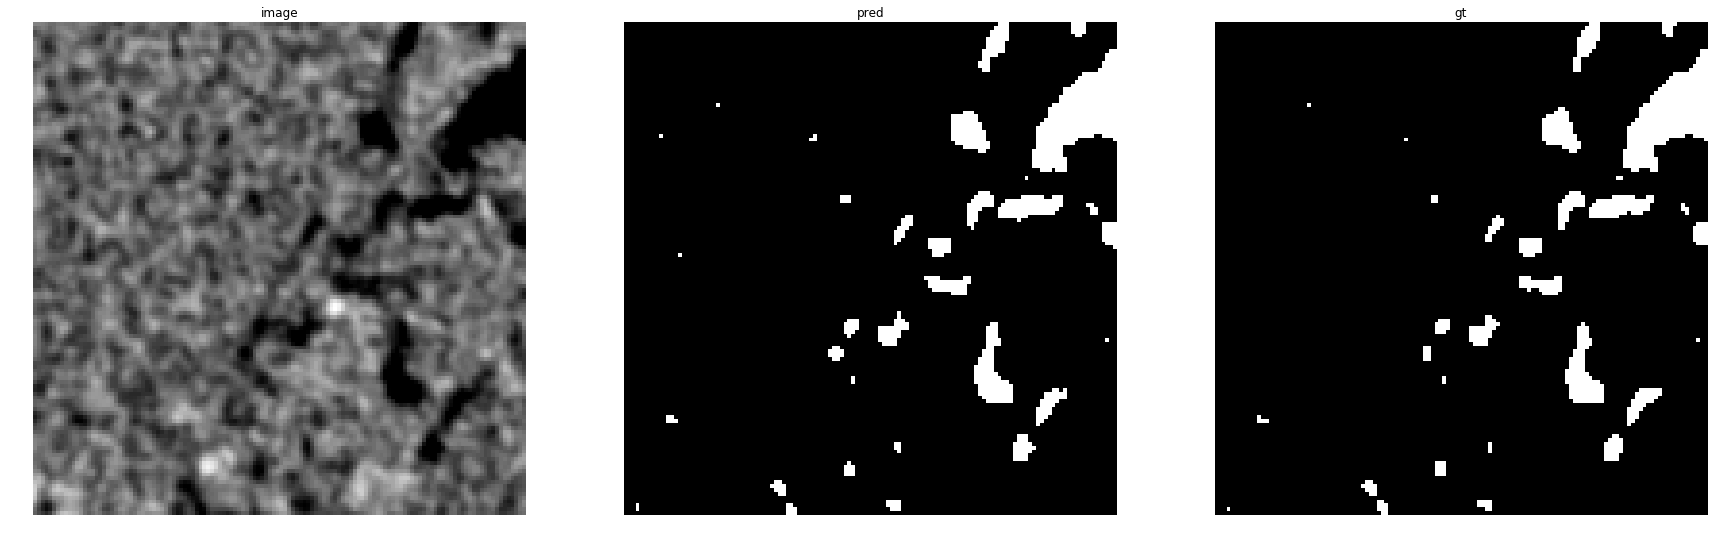

accuracy    : 0.9951171875
precision   : 0.946124763705104
recall      : 0.9775390625
f1          : 0.9615754082612873
pr_auc      : 0.9959588345820837
iou         : 0.9259944495837188


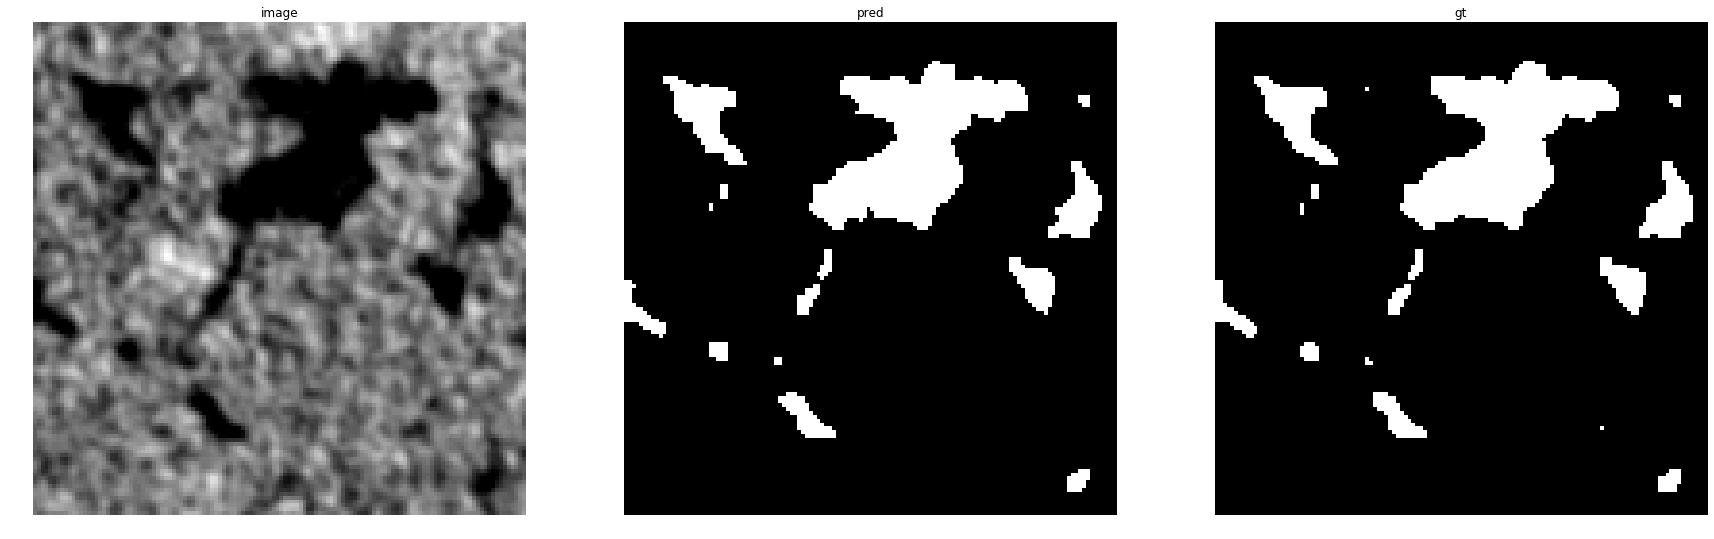

accuracy    : 0.99444580078125
precision   : 0.9902413970210581
recall      : 0.964
f1          : 0.9769445148213834
pr_auc      : 0.9985441262281047
iou         : 0.9549281822684498


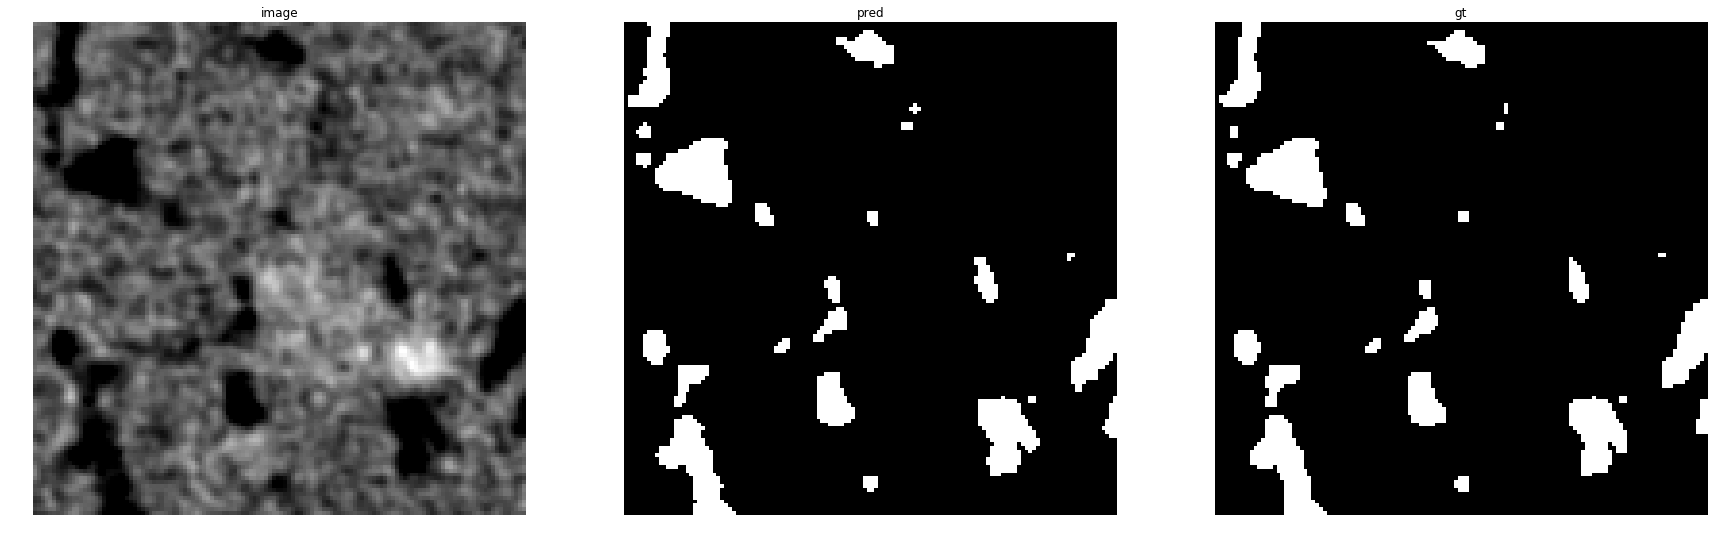

accuracy    : 0.9932861328125
precision   : 0.9574468085106383
recall      : 0.9690444145356663
f1          : 0.9632107023411371
pr_auc      : 0.9959181286953667
iou         : 0.9290322580645162


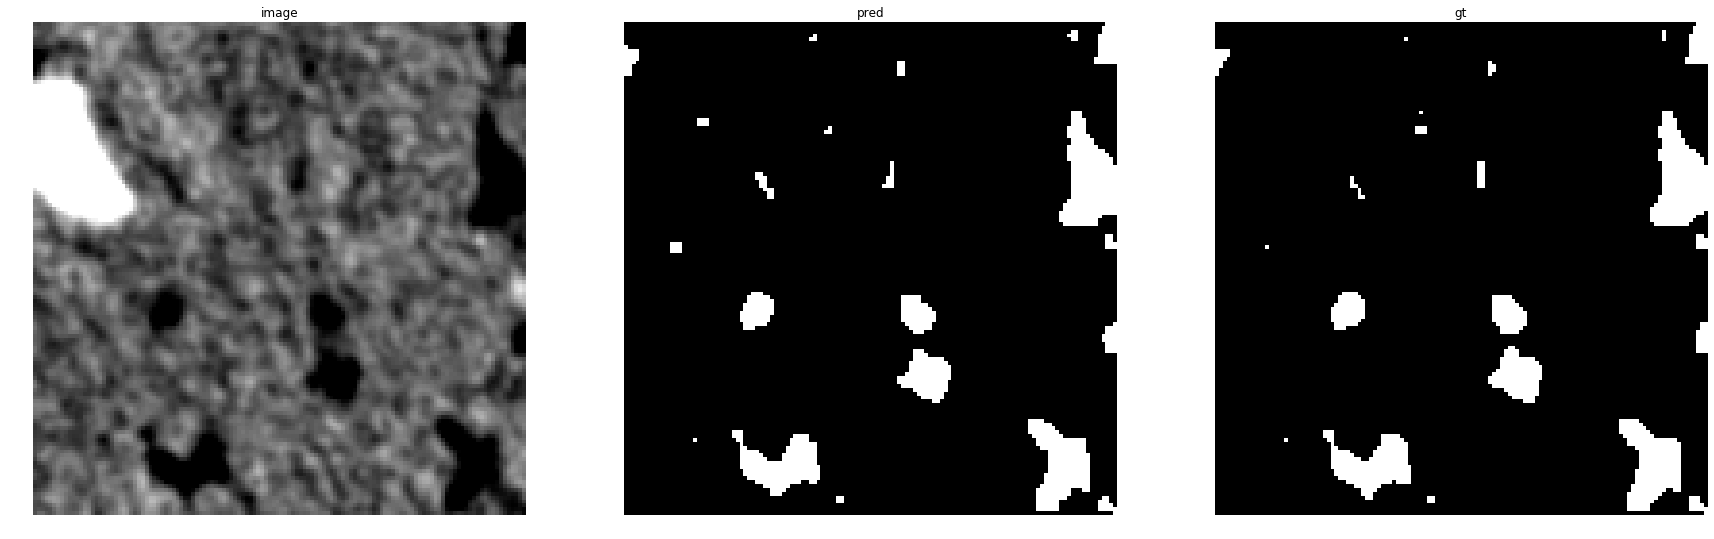

accuracy    : 0.9945068359375
precision   : 0.9633730834752982
recall      : 0.9601018675721562
f1          : 0.9617346938775511
pr_auc      : 0.9956863103160701
iou         : 0.9262899262899262


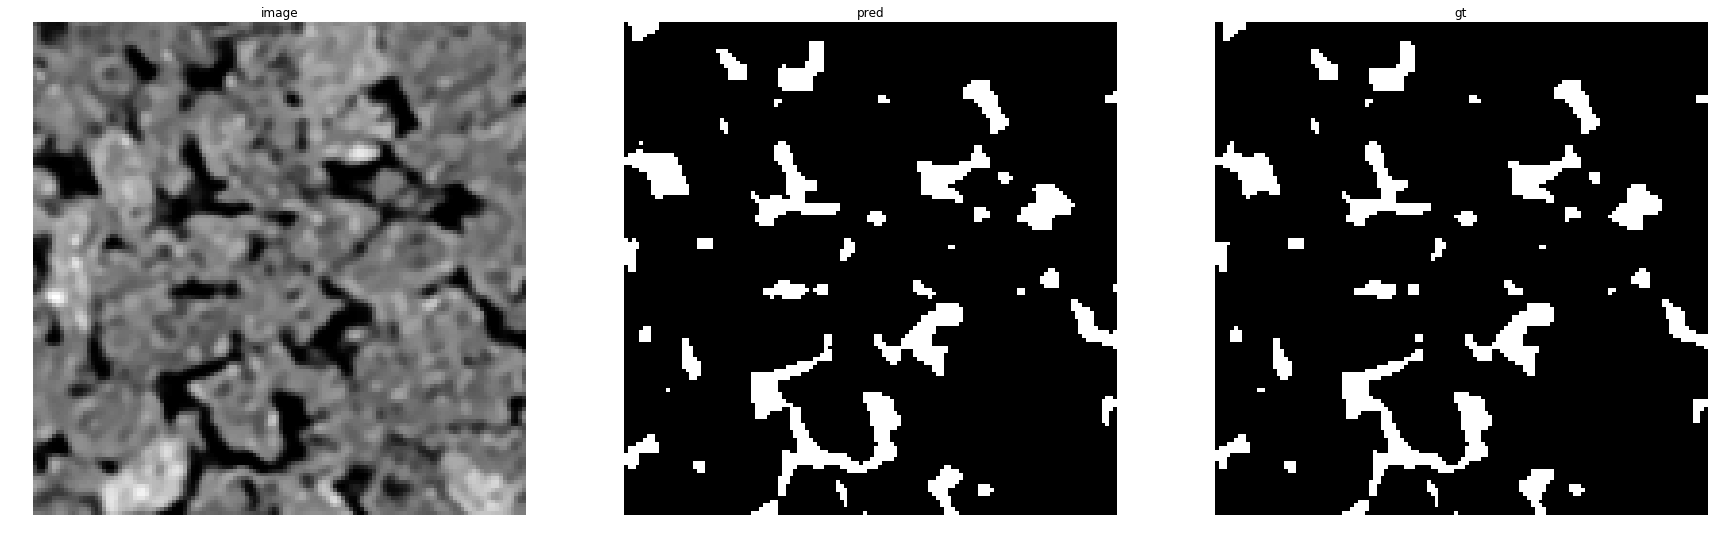

accuracy    : 0.99267578125
precision   : 0.9429678848283499
recall      : 0.9901162790697674
f1          : 0.9659671015314805
pr_auc      : 0.9970490800679868
iou         : 0.934174437739989


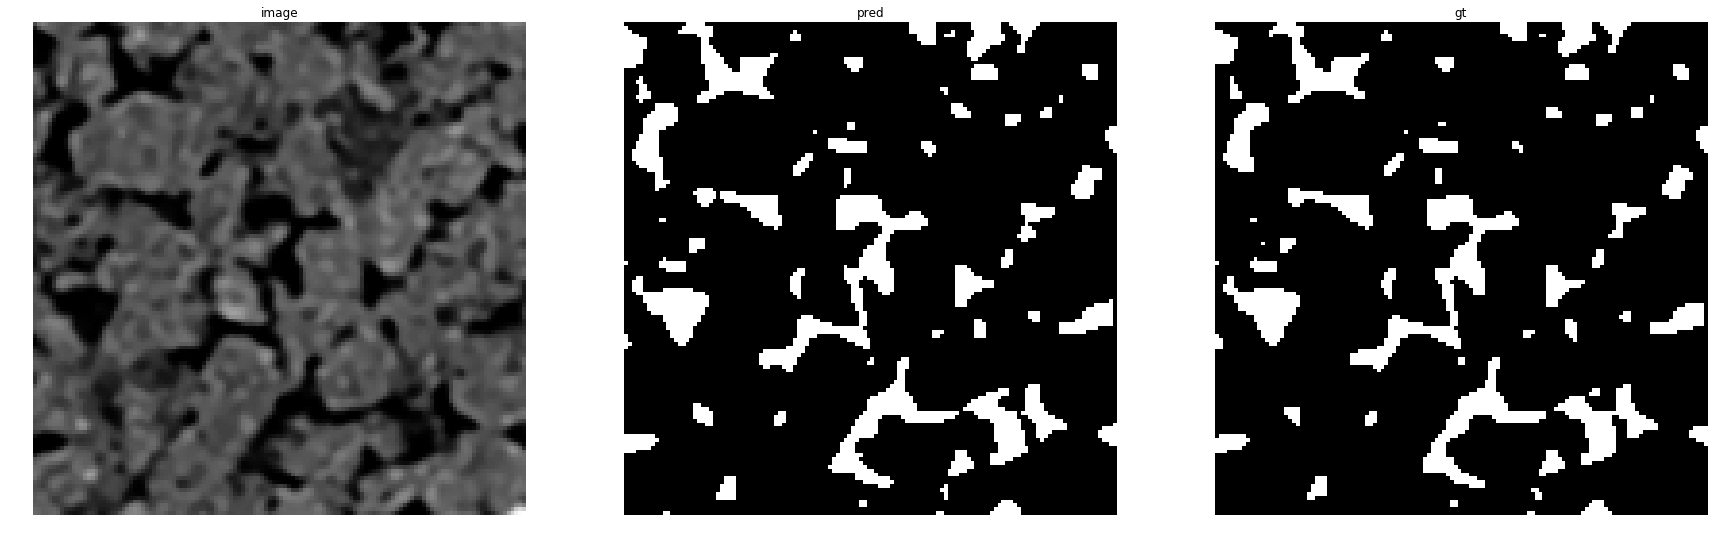

accuracy    : 0.98846435546875
precision   : 0.9325513196480938
recall      : 0.9875776397515528
f1          : 0.9592760180995475
pr_auc      : 0.9966325896038822
iou         : 0.9217391304347826


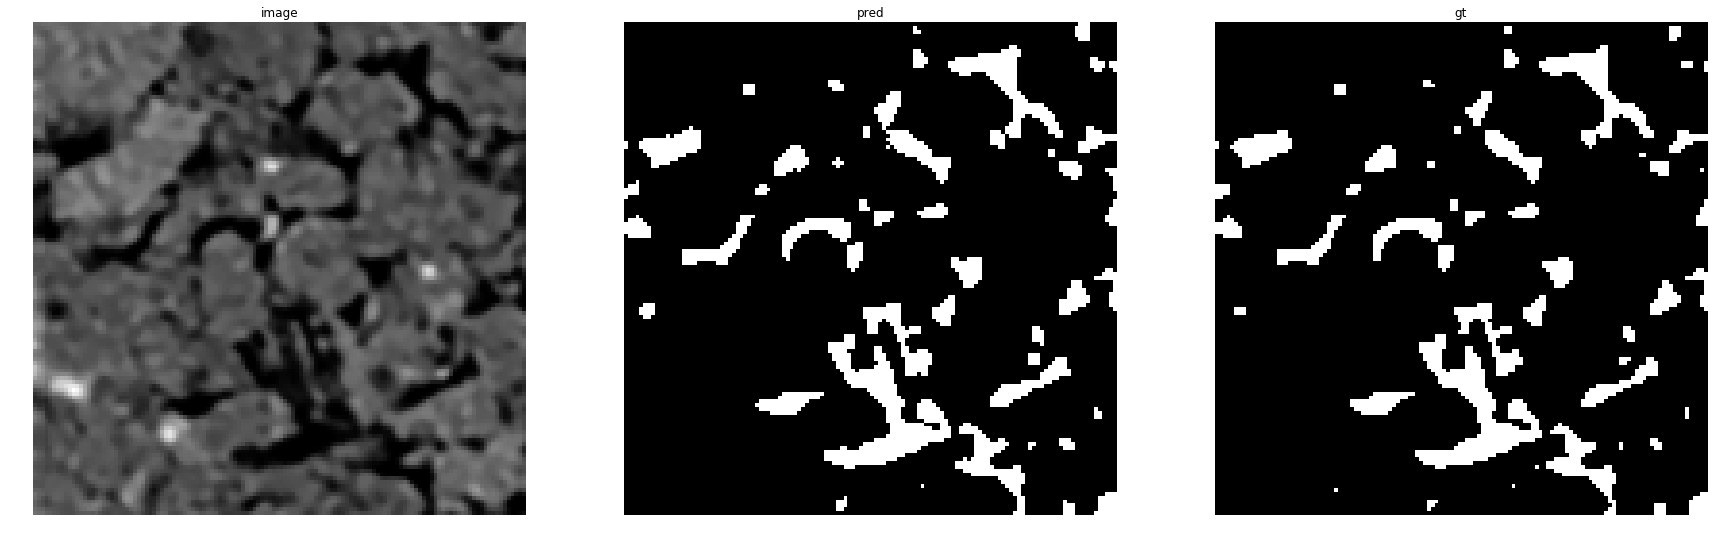

accuracy    : 0.98779296875
precision   : 0.910581222056632
recall      : 0.9892066918510524
f1          : 0.9482669425763064
pr_auc      : 0.9961393941119356
iou         : 0.9016232169208067


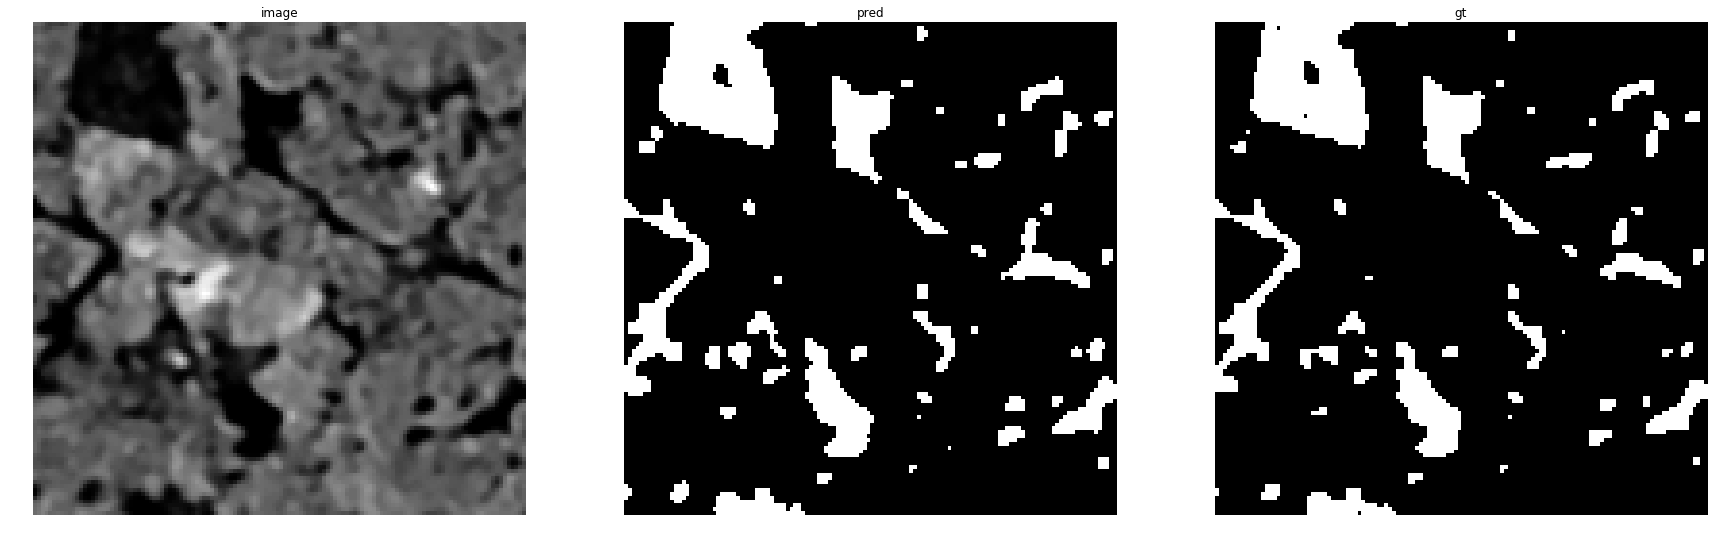

accuracy    : 0.9844970703125
precision   : 0.9077220077220077
recall      : 0.9936601859678783
f1          : 0.9487489911218725
pr_auc      : 0.9969200977230921
iou         : 0.9024952015355087


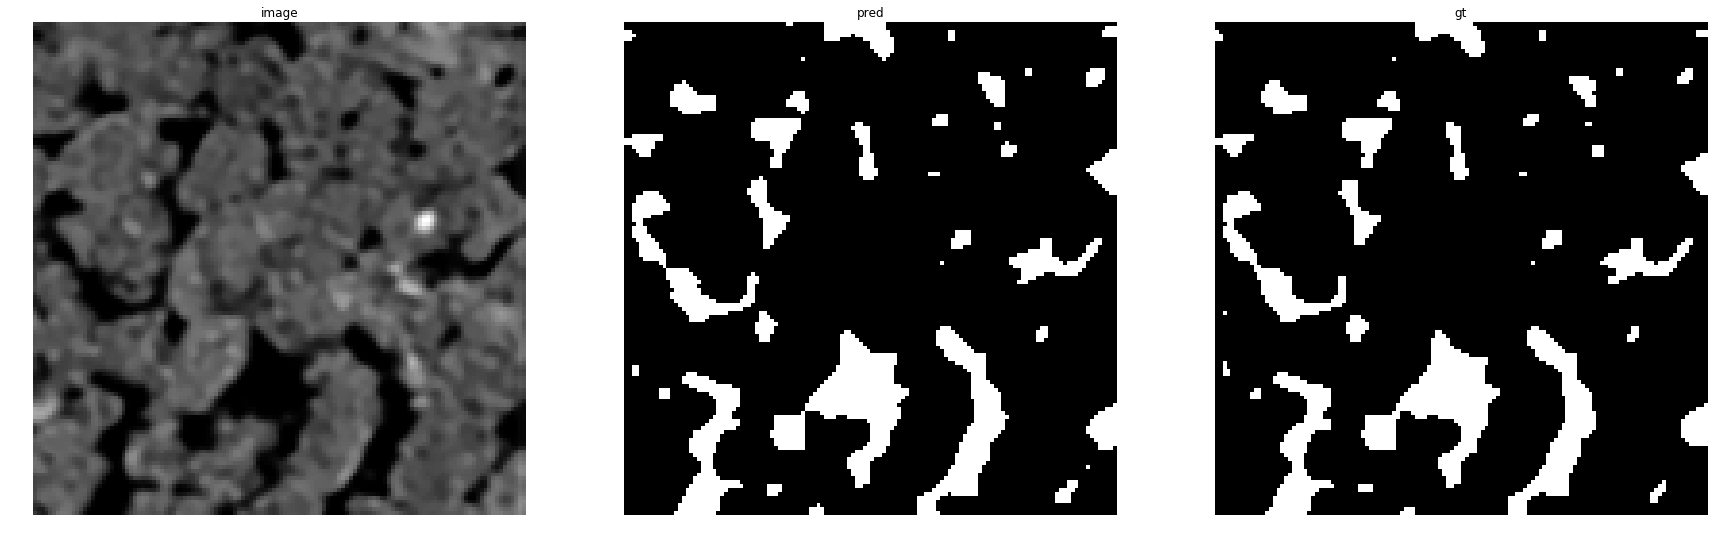

accuracy    : 0.9906005859375
precision   : 0.9436386241193535
recall      : 0.9921568627450981
f1          : 0.9672897196261682
pr_auc      : 0.9980142524241173
iou         : 0.9366515837104072


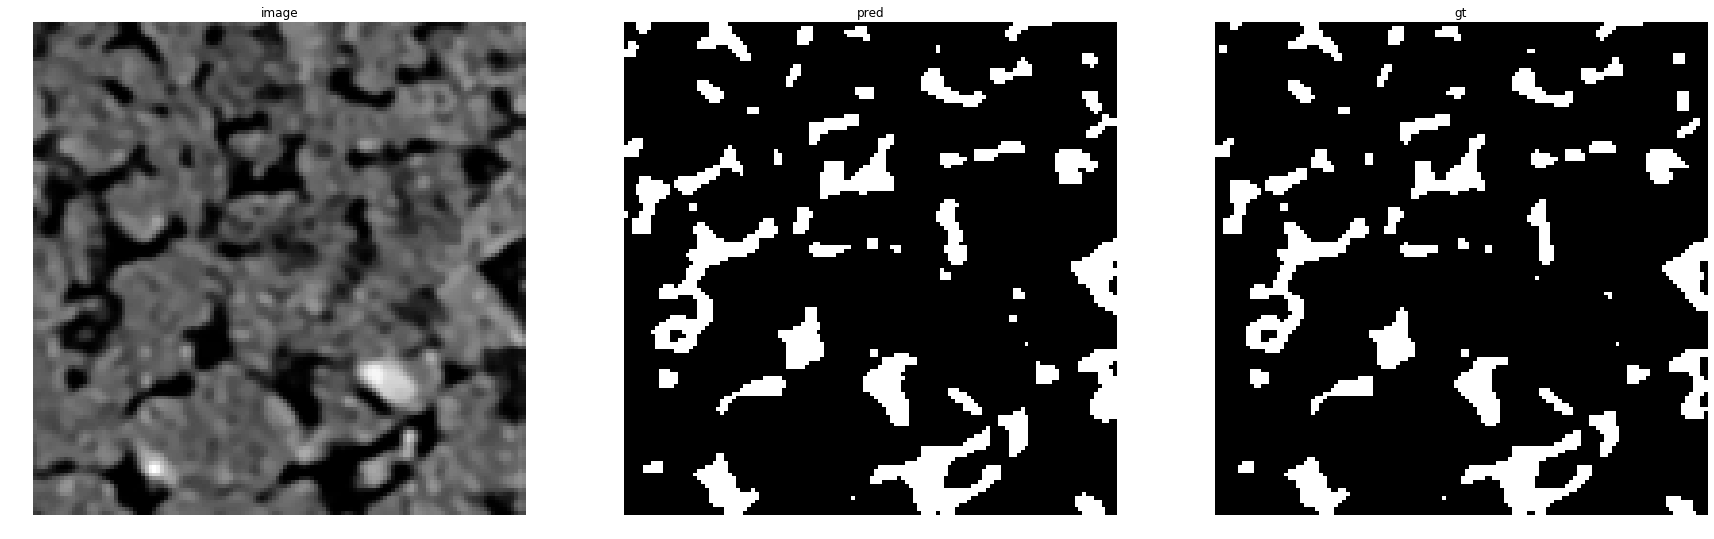

accuracy    : 0.98419189453125
precision   : 0.9041471048513302
recall      : 0.993978494623656
f1          : 0.9469371030526531
pr_auc      : 0.9963324426969742
iou         : 0.8992217898832685


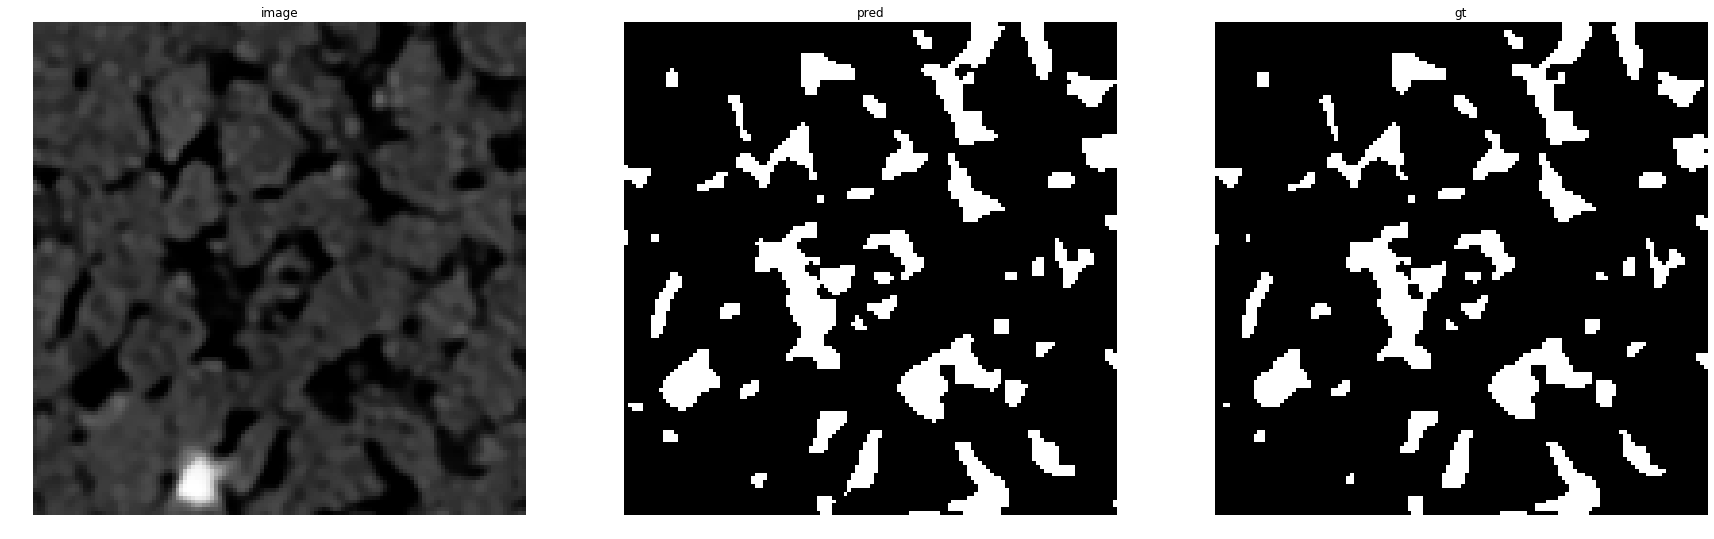

accuracy    : 0.98834228515625
precision   : 0.9341317365269461
recall      : 0.994026284348865
f1          : 0.9631487555469805
pr_auc      : 0.9975174515121414
iou         : 0.9289170078154075


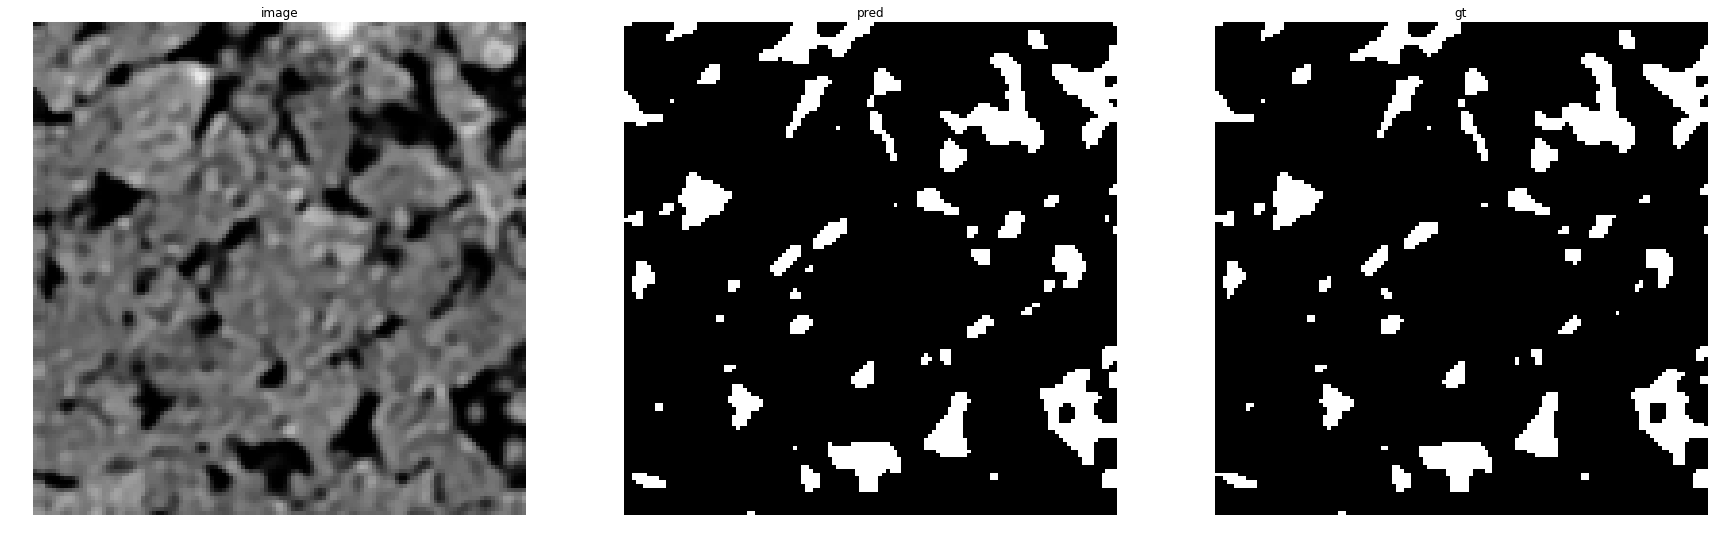

accuracy    : 0.98858642578125
precision   : 0.9226493747105141
recall      : 0.9900596421471173
f1          : 0.9551666267082235
pr_auc      : 0.9968961648030797
iou         : 0.914180816888481


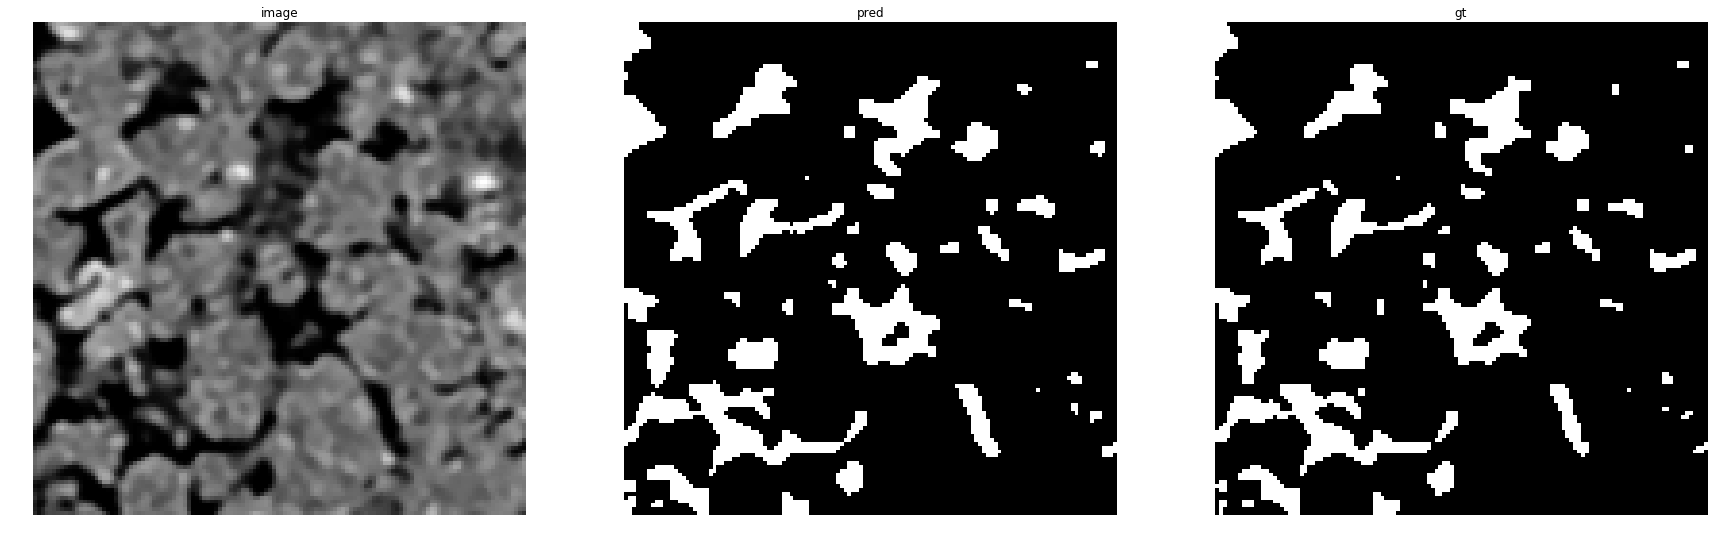

accuracy    : 0.9864501953125
precision   : 0.9168975069252078
recall      : 0.9948475740661228
f1          : 0.9542833607907744
pr_auc      : 0.9970988852586139
iou         : 0.9125640015754234


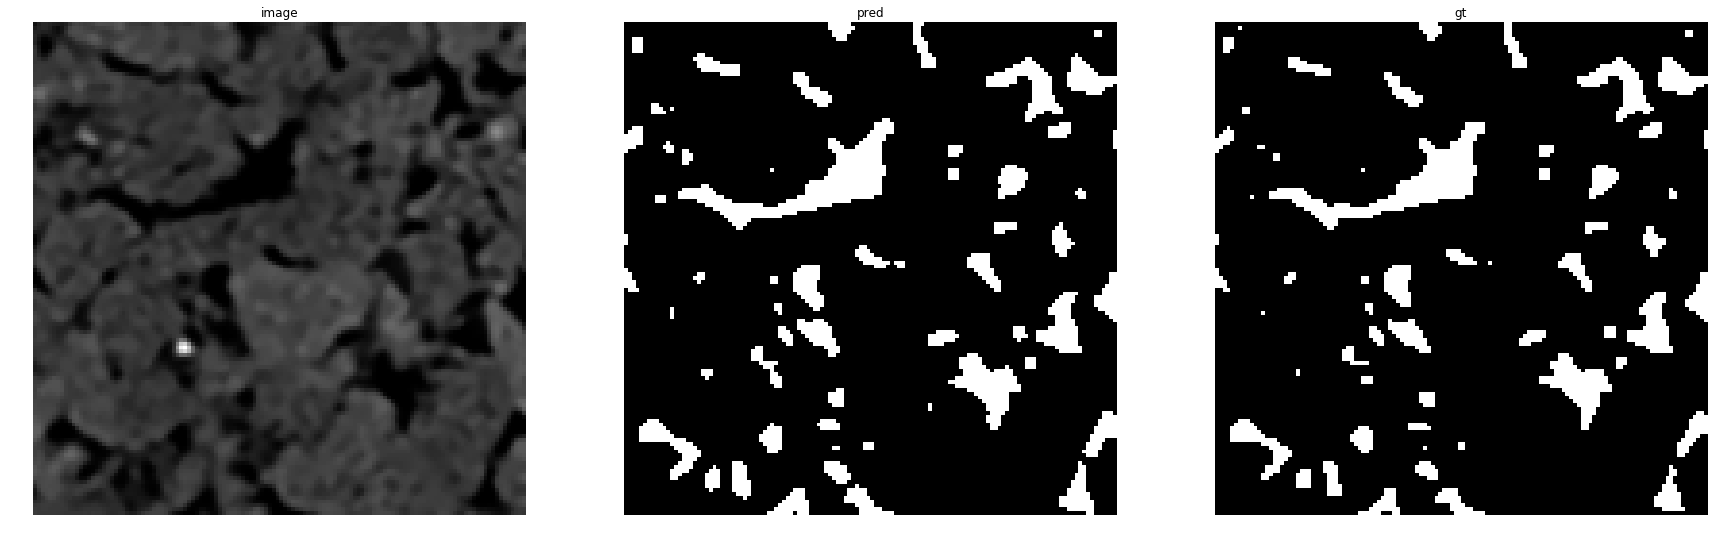

accuracy    : 0.98577880859375
precision   : 0.893687707641196
recall      : 0.9952431289640592
f1          : 0.9417354338584647
pr_auc      : 0.9963731024075926
iou         : 0.8898865784499055


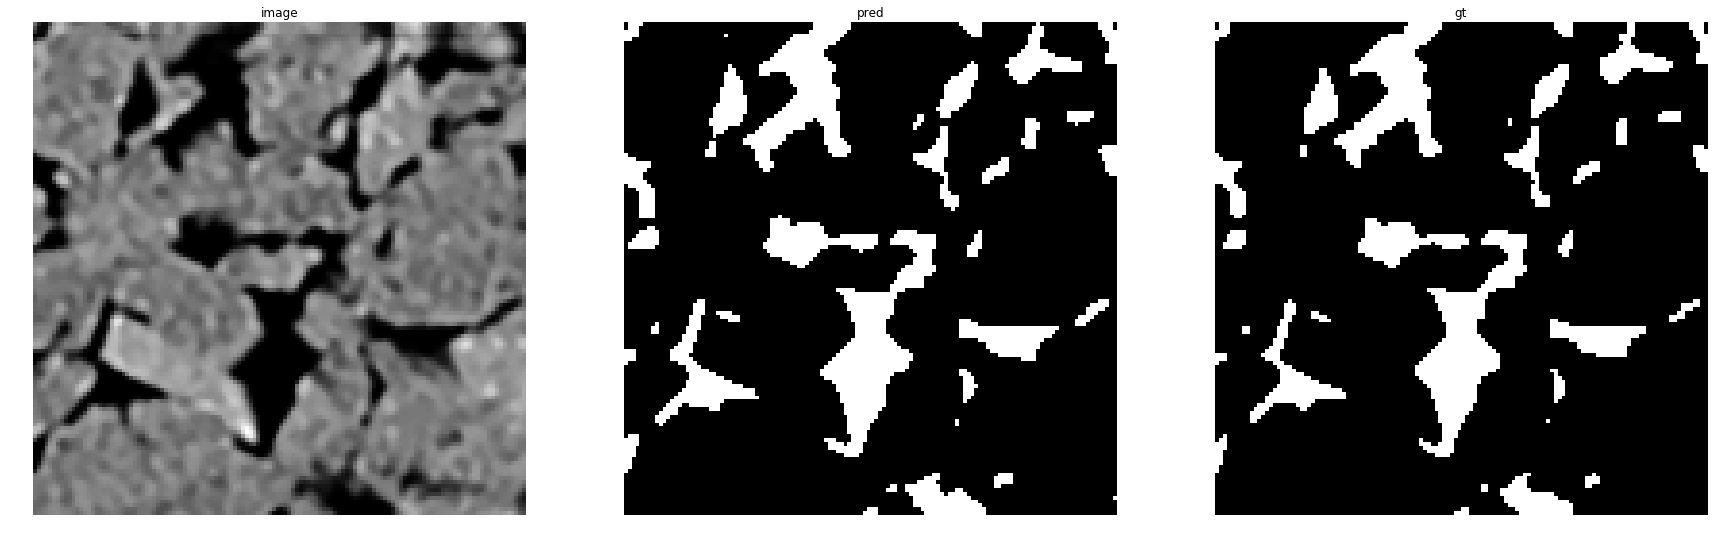

accuracy    : 0.98504638671875
precision   : 0.9137931034482759
recall      : 0.9938850387280881
f1          : 0.952157781683265
pr_auc      : 0.9977861792379291
iou         : 0.9086843086097652


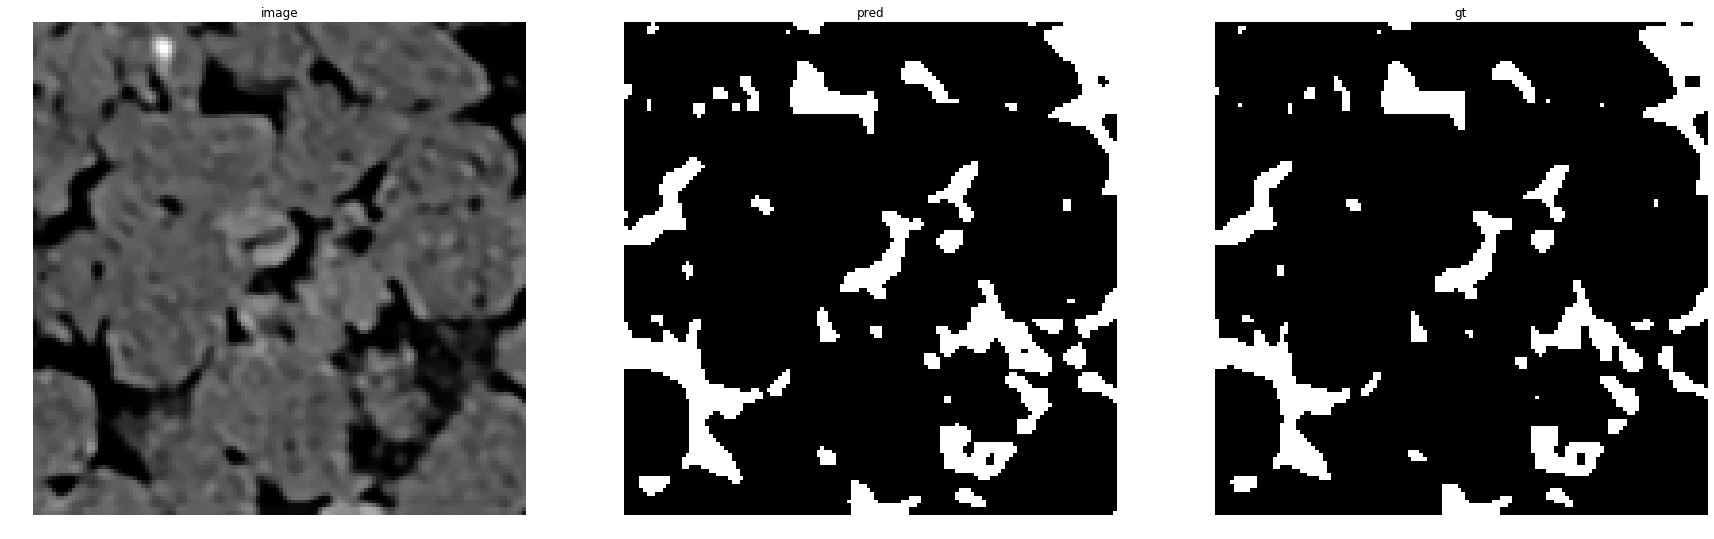

accuracy    : 0.97589111328125
precision   : 0.8561178247734139
recall      : 0.9938623410784744
f1          : 0.9198620409819437
pr_auc      : 0.9953965974794374
iou         : 0.8516153268219384


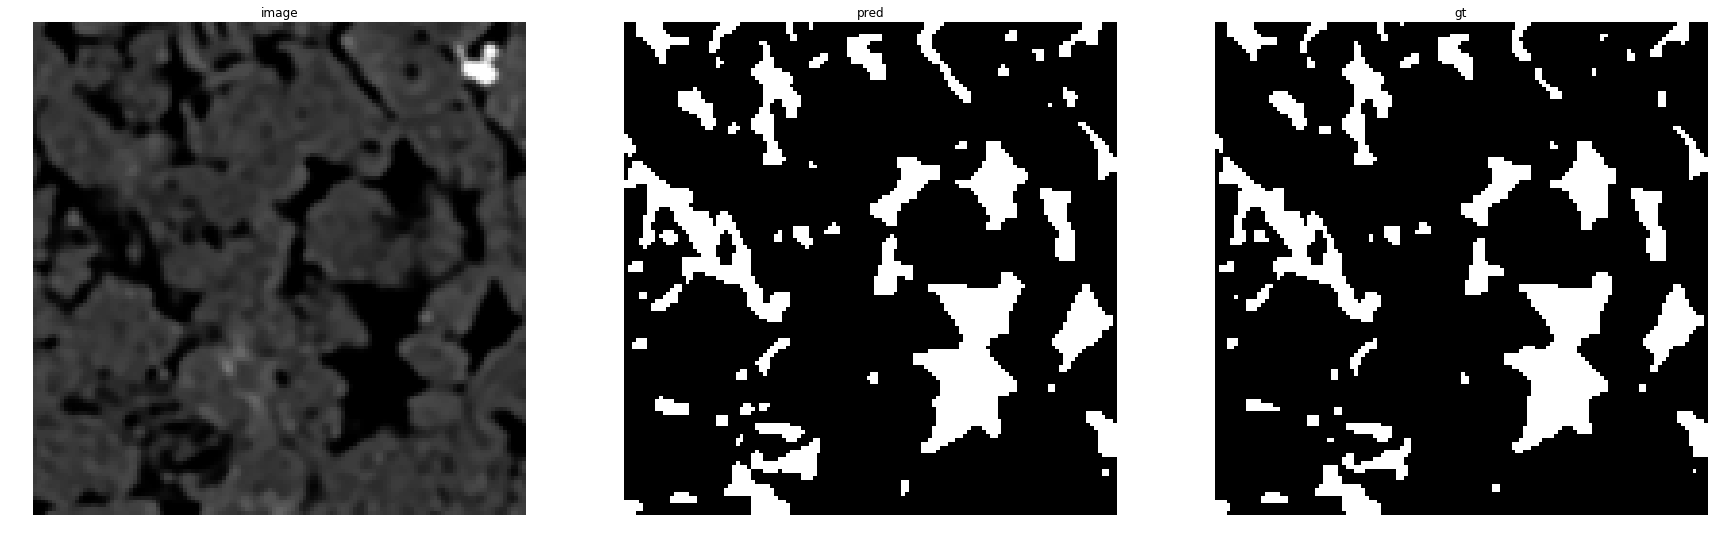

accuracy    : 0.98236083984375
precision   : 0.9148727984344422
recall      : 0.9901164842922697
f1          : 0.9510086455331412
pr_auc      : 0.9966696857366184
iou         : 0.9065934065934066


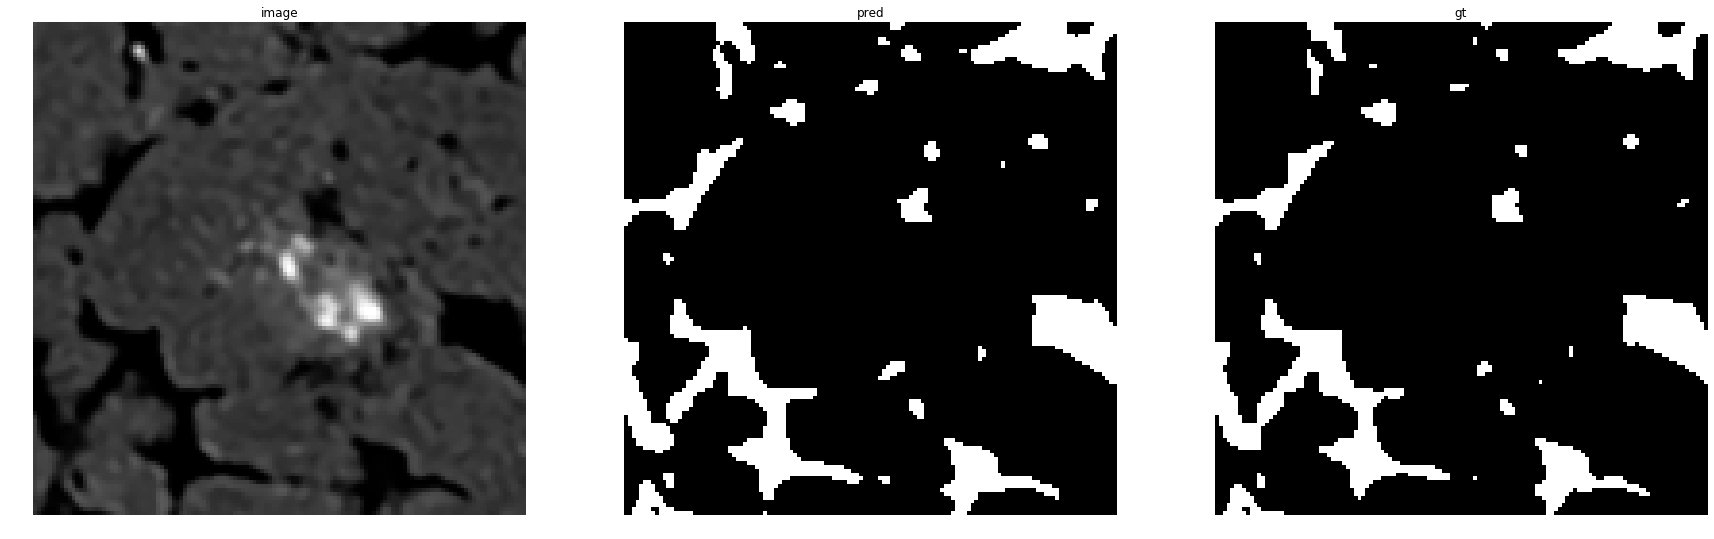

accuracy    : 0.98614501953125
precision   : 0.9099137931034482
recall      : 0.99154532644434
f1          : 0.948977298269274
pr_auc      : 0.9977039019303613
iou         : 0.9029084687767323


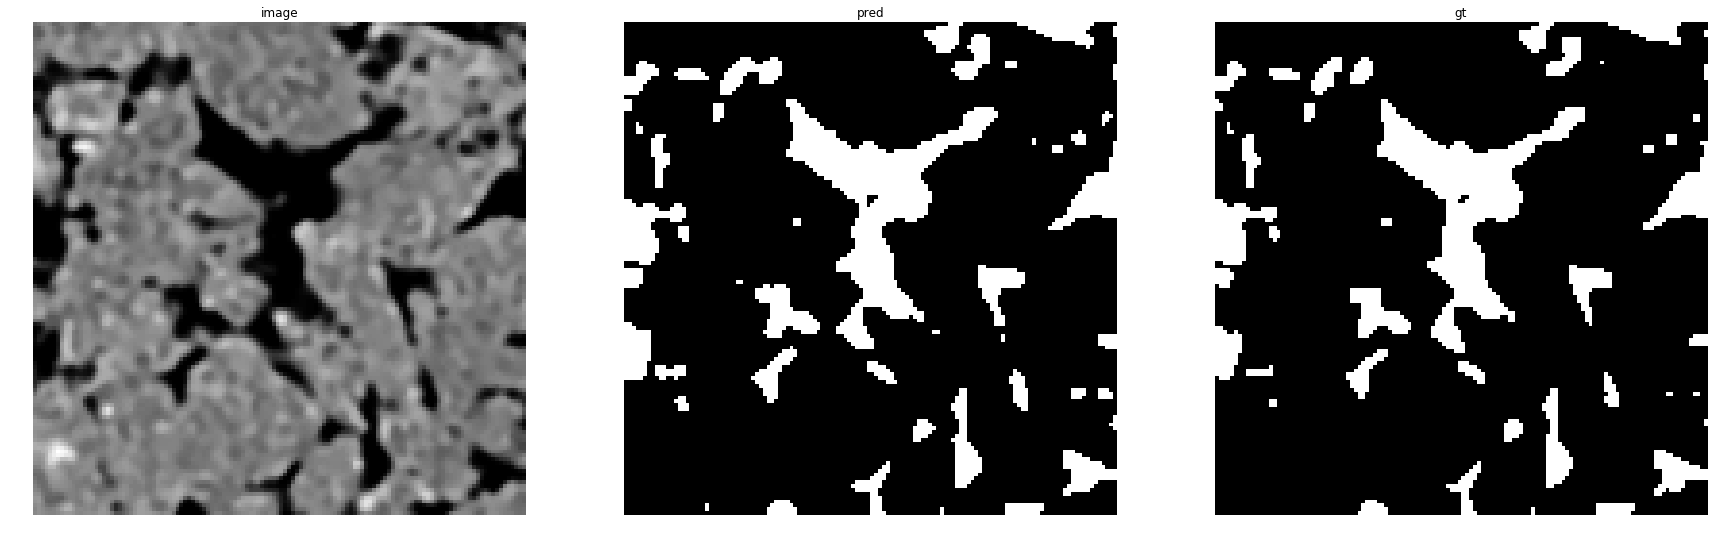

accuracy    : 0.98321533203125
precision   : 0.9075252714339199
recall      : 0.9885807504078303
f1          : 0.946320515323053
pr_auc      : 0.9961892973582901
iou         : 0.8981104112634309


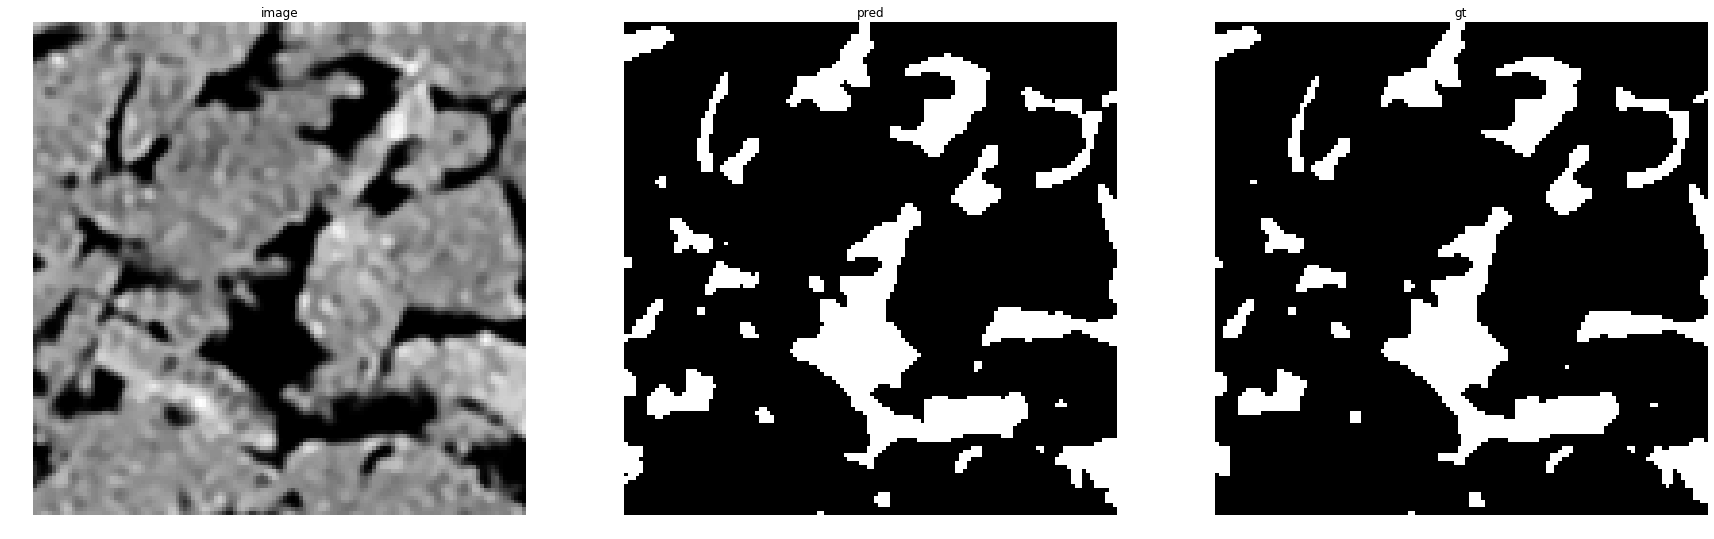

accuracy    : 0.9837646484375
precision   : 0.9234710214537304
recall      : 0.990724836825833
f1          : 0.9559164733178656
pr_auc      : 0.9973591899016769
iou         : 0.9155555555555556


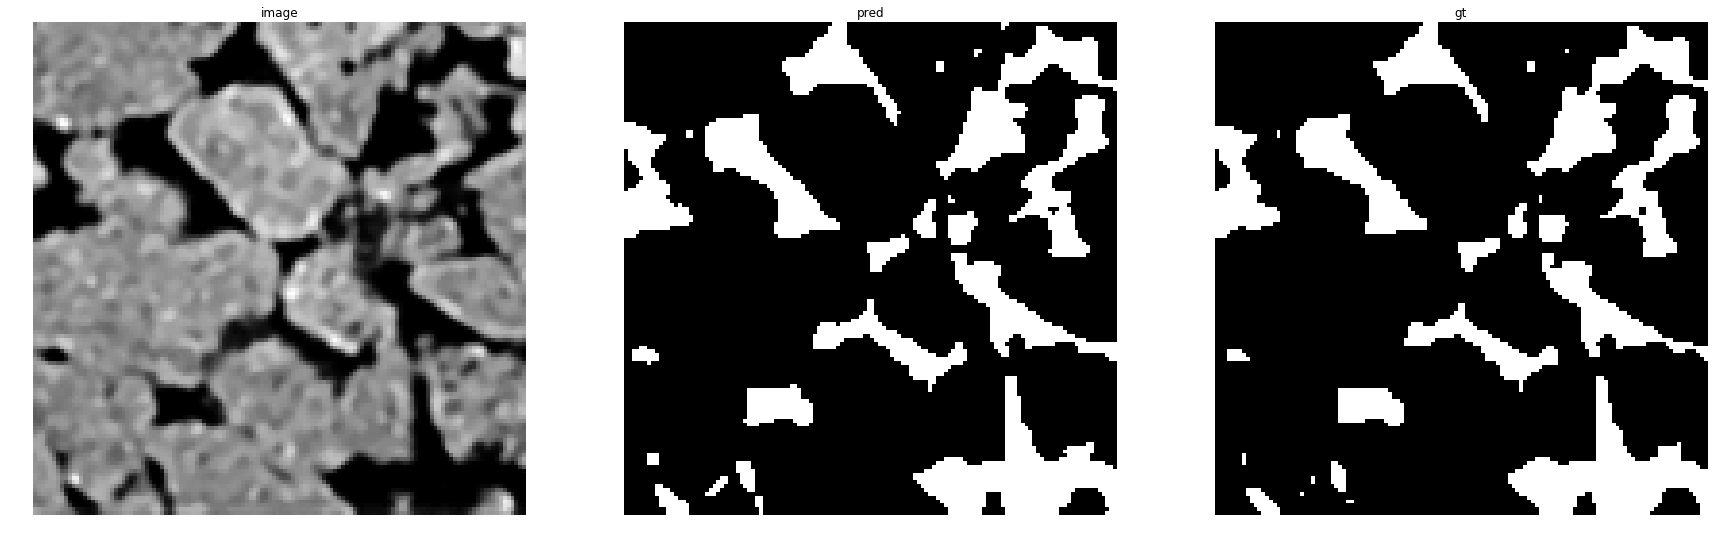

accuracy    : 0.985107421875
precision   : 0.9398952302178109
recall      : 0.9924308588064047
f1          : 0.9654488813367318
pr_auc      : 0.9981742782221232
iou         : 0.9332055844511361


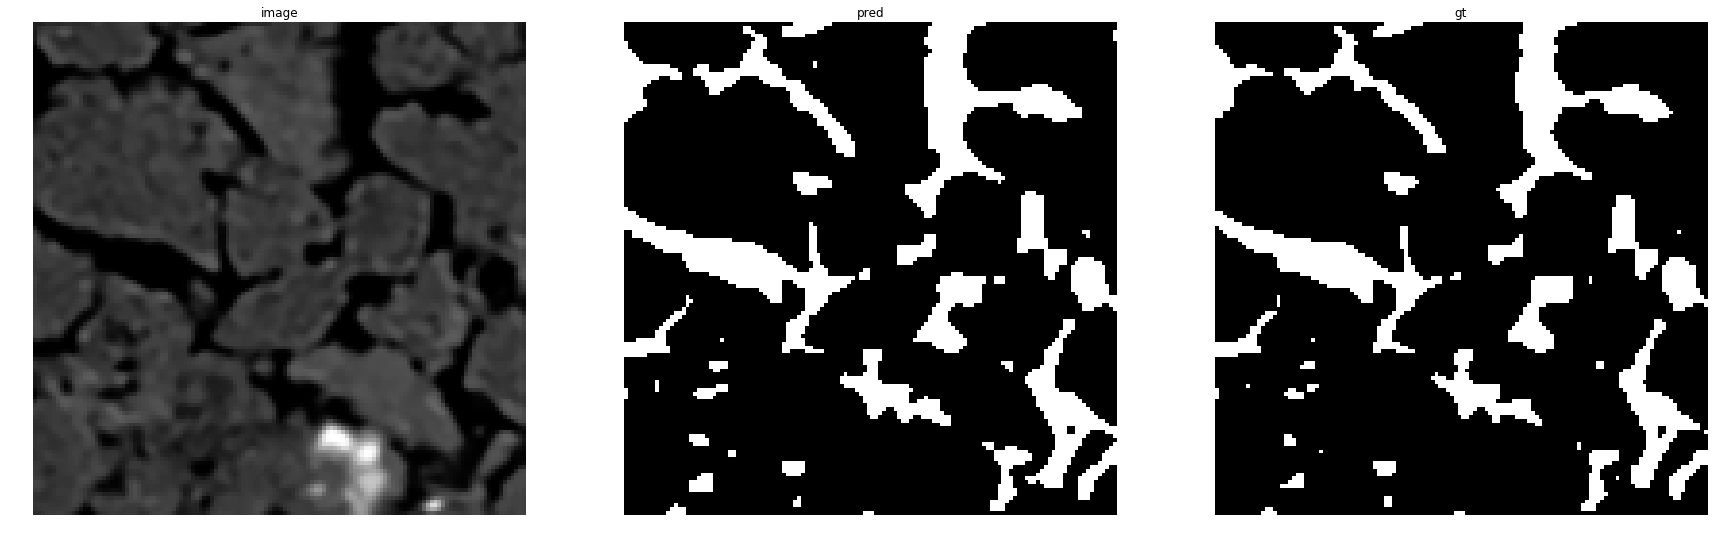

accuracy    : 0.98016357421875
precision   : 0.8989240299967395
recall      : 0.9945887445887446
f1          : 0.9443397842096249
pr_auc      : 0.9970482693424778
iou         : 0.8945489941596366


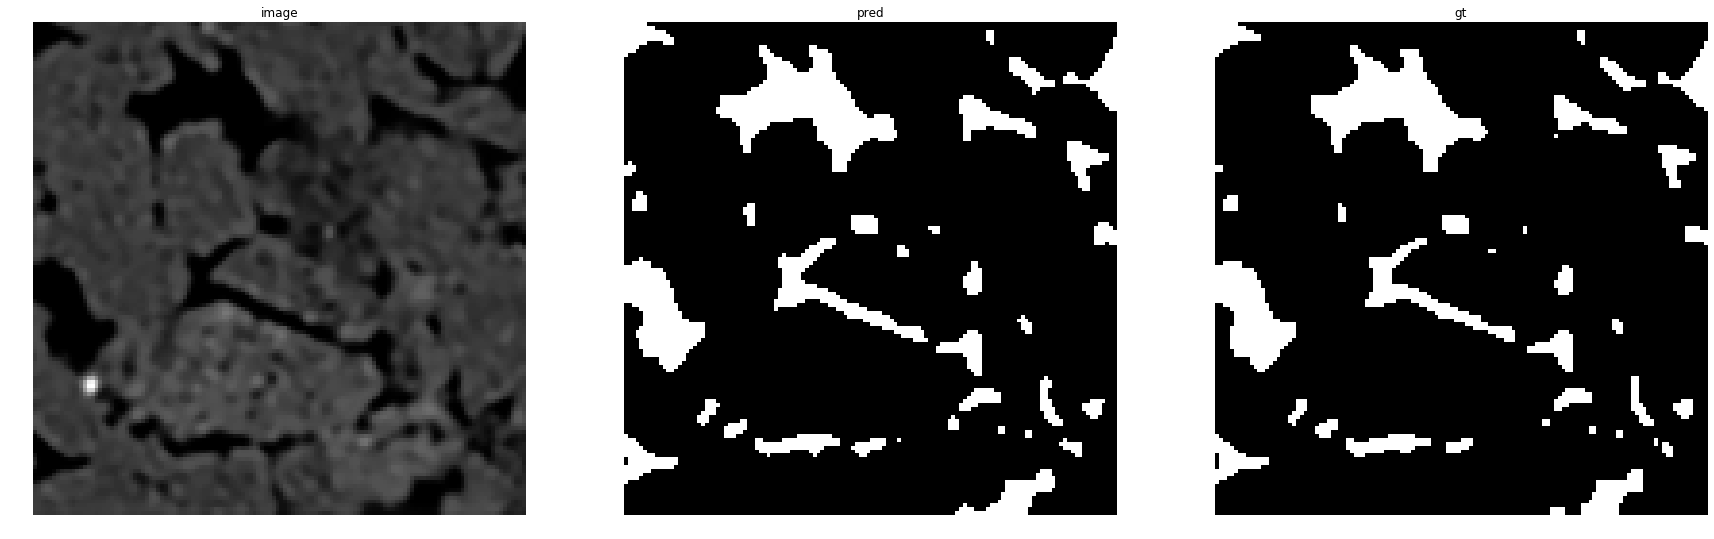

accuracy    : 0.9879150390625
precision   : 0.9188605955977557
recall      : 0.9953249181860683
f1          : 0.9555655296229802
pr_auc      : 0.9979336734314026
iou         : 0.9149119037387193


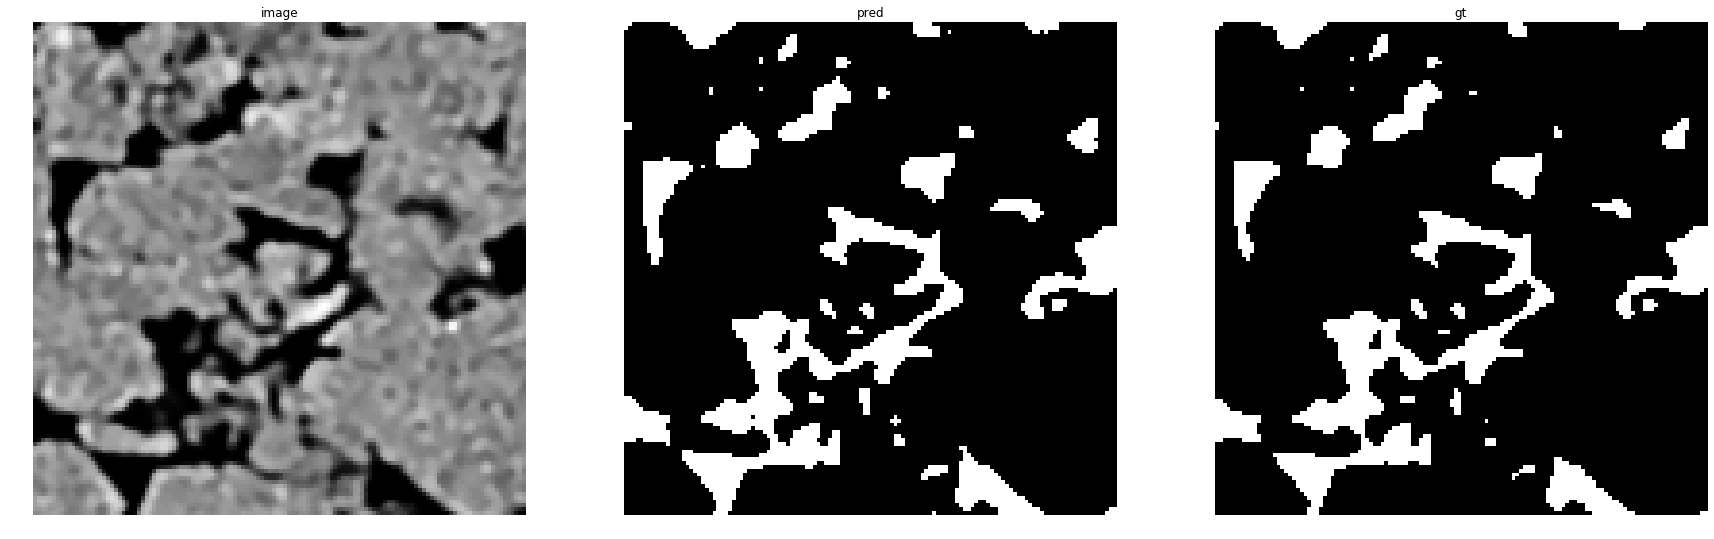

accuracy    : 0.98333740234375
precision   : 0.9042593290614399
recall      : 0.9921422663358147
f1          : 0.9461644646026425
pr_auc      : 0.996977143283721
iou         : 0.8978293413173652


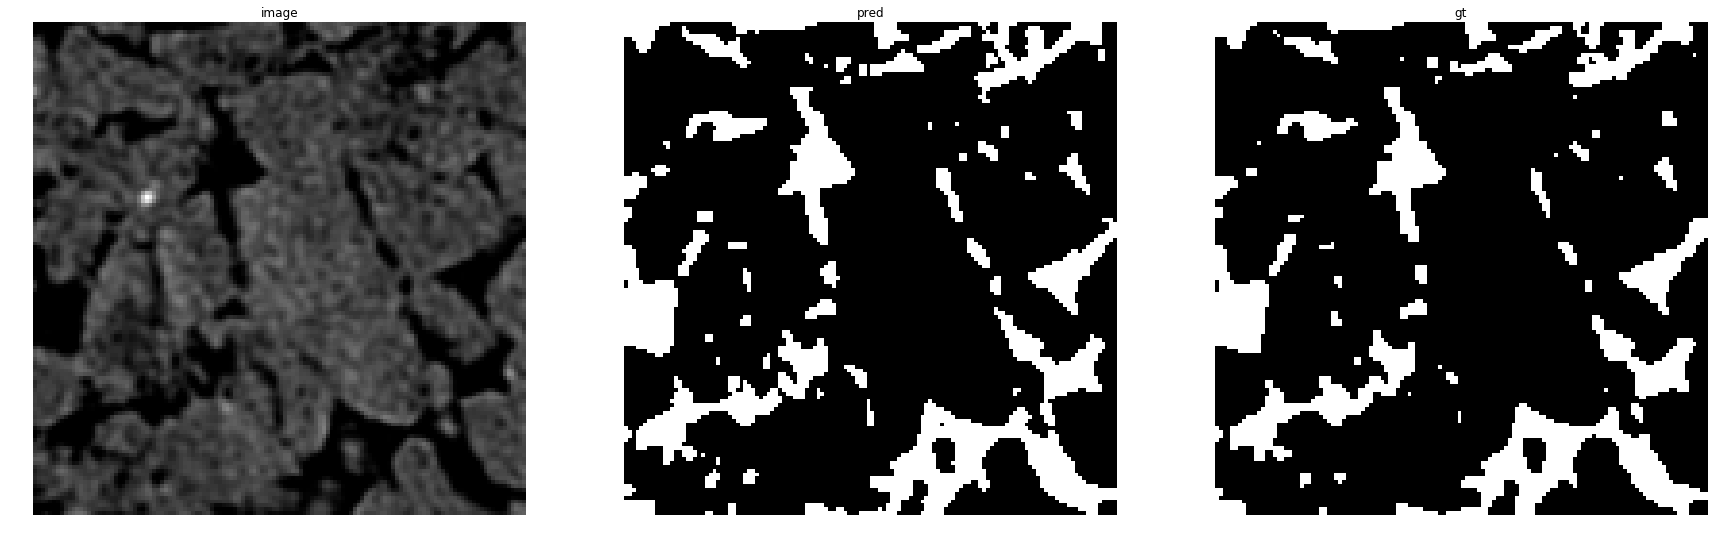

accuracy    : 0.9705810546875
precision   : 0.8764775413711584
recall      : 0.9788778877887789
f1          : 0.9248518864982851
pr_auc      : 0.9916753054800221
iou         : 0.8602088167053364


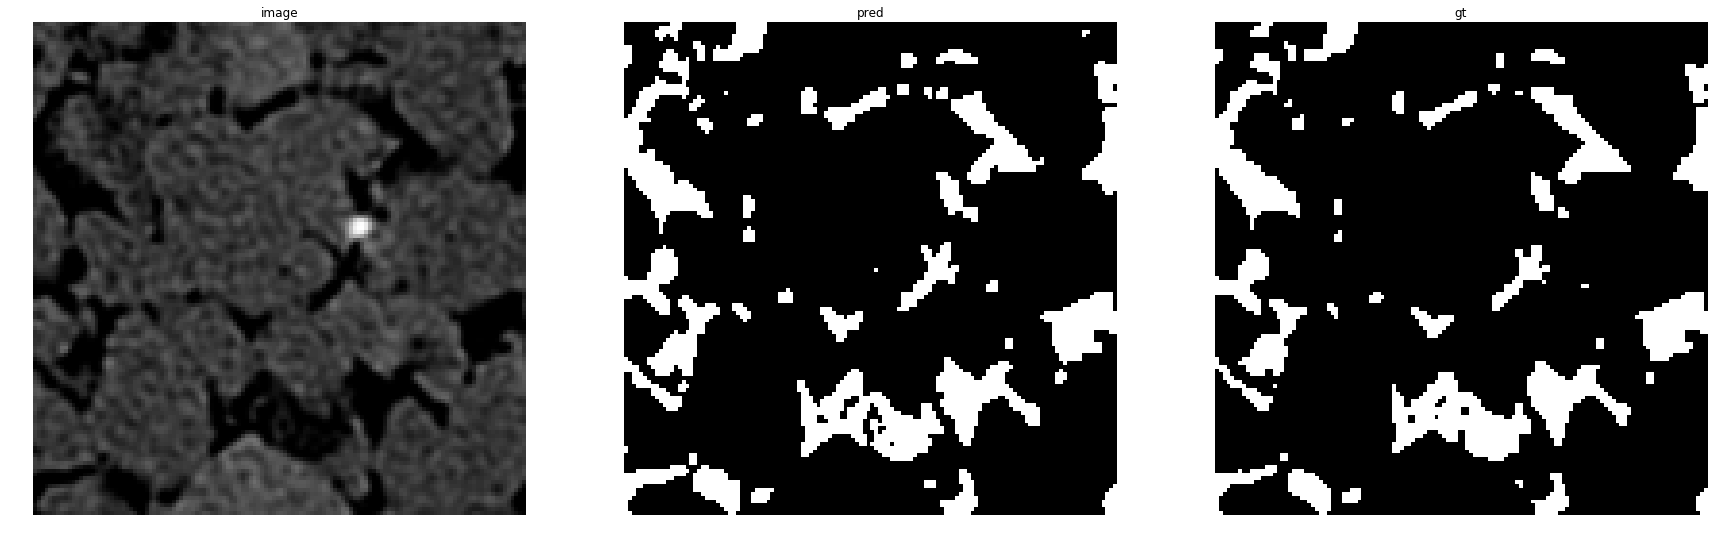

accuracy    : 0.97357177734375
precision   : 0.8761969904240766
recall      : 0.973034561336878
f1          : 0.9220802591326255
pr_auc      : 0.9899498575631397
iou         : 0.8554257095158597


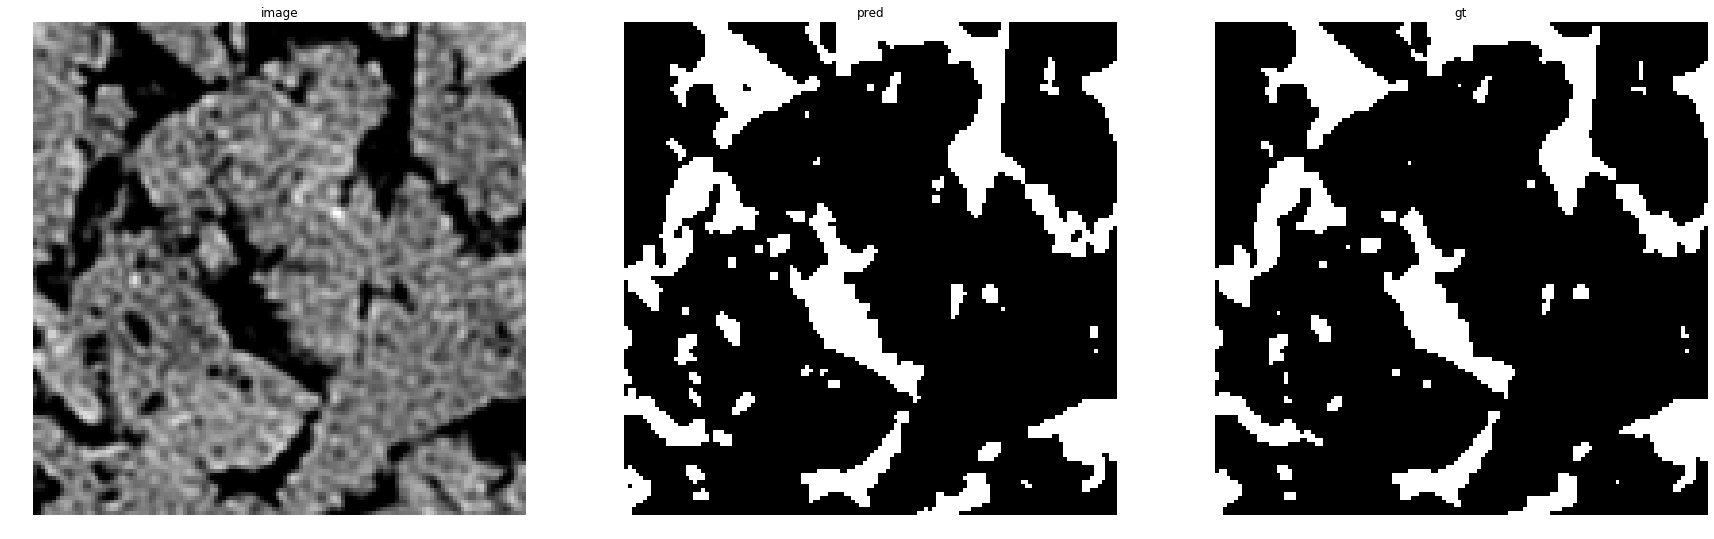

accuracy    : 0.974365234375
precision   : 0.901744966442953
recall      : 0.9841781423967184
f1          : 0.9411599887923787
pr_auc      : 0.9944399533526541
iou         : 0.8888594866366764


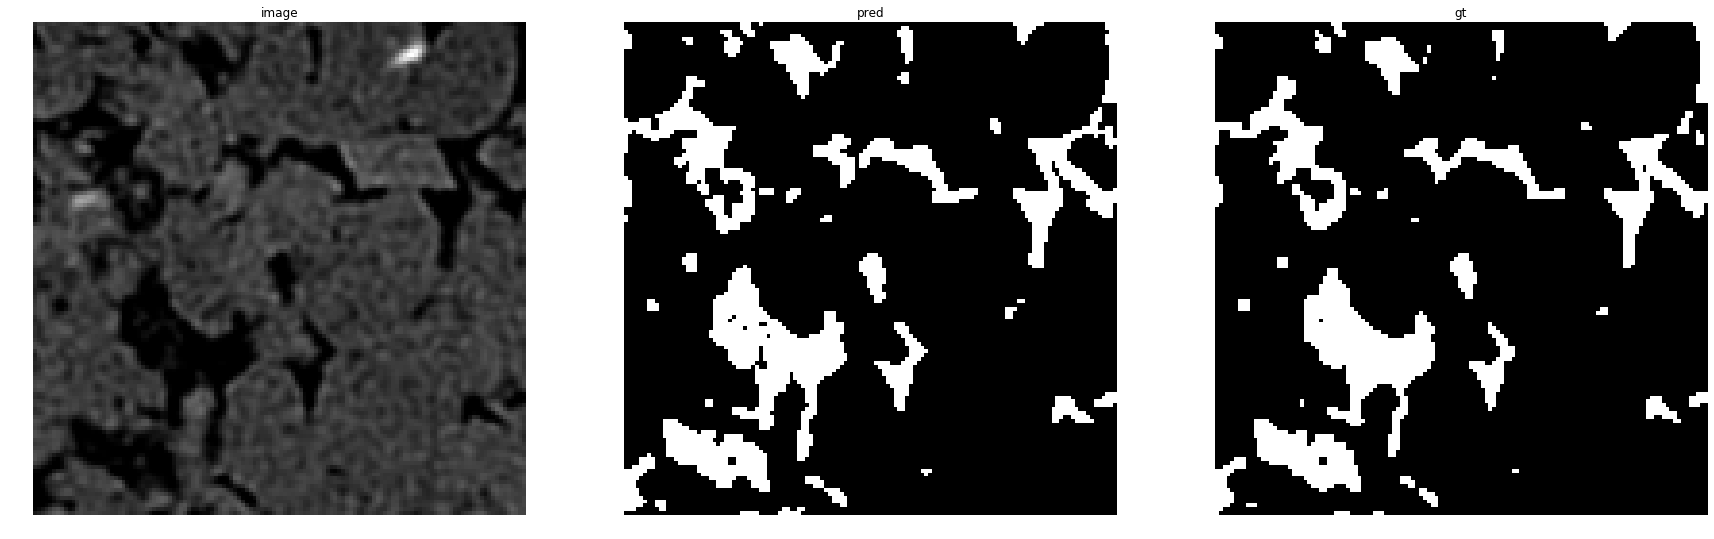

accuracy    : 0.9747314453125
precision   : 0.8736998514115899
recall      : 0.9694971145919209
f1          : 0.9191090269636577
pr_auc      : 0.9879722870605643
iou         : 0.8503253796095445


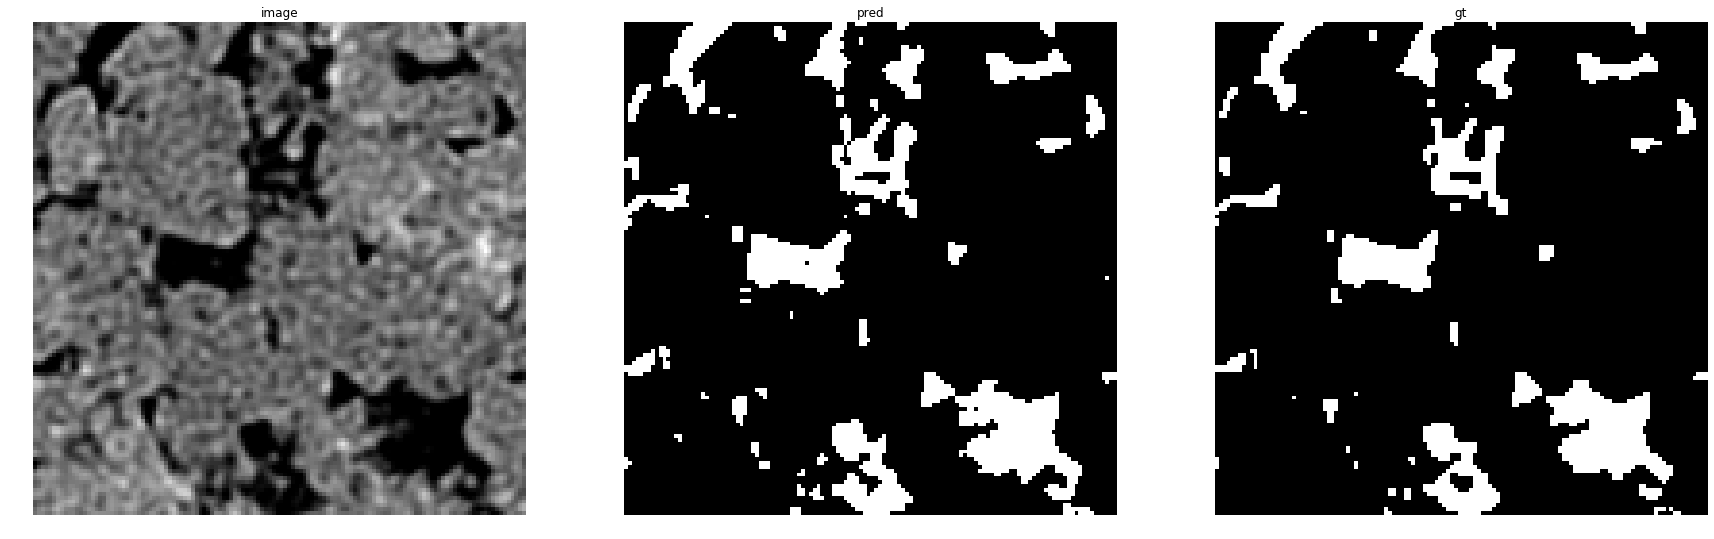

accuracy    : 0.978271484375
precision   : 0.863849765258216
recall      : 0.9820475497331392
f1          : 0.9191643960036332
pr_auc      : 0.9920929653976412
iou         : 0.8504201680672269


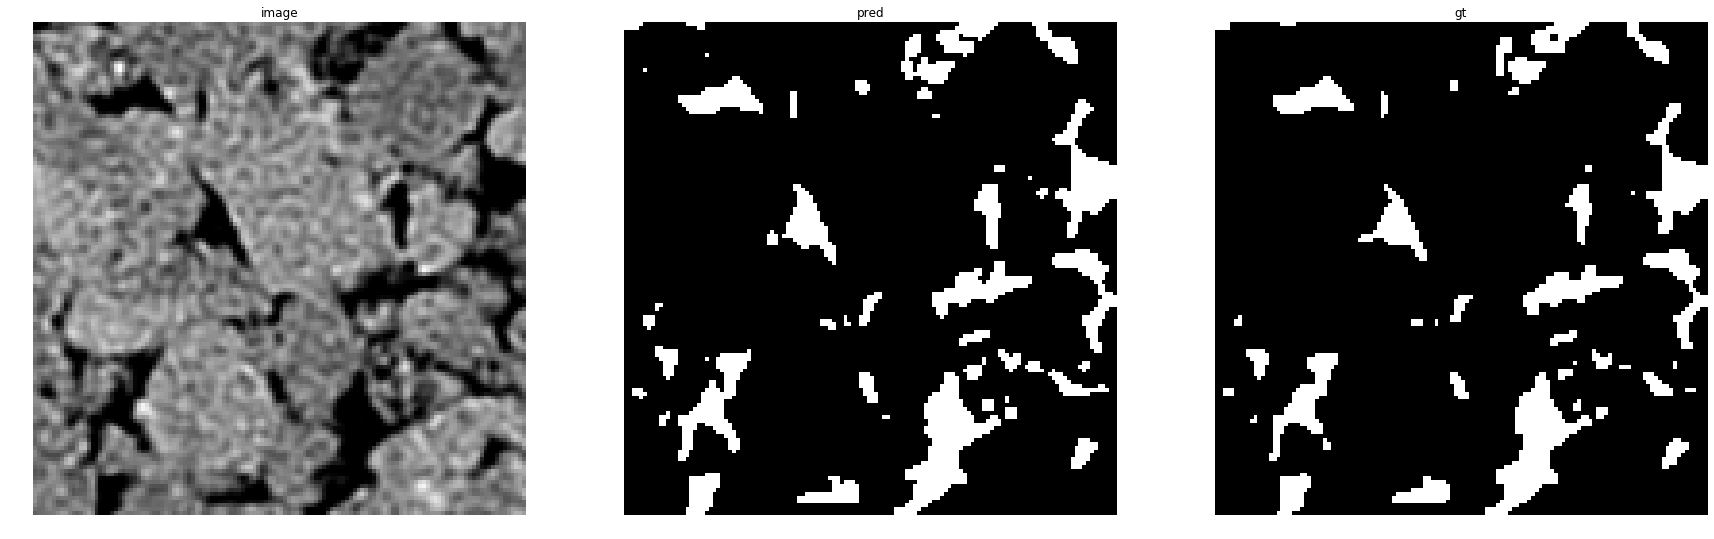

accuracy    : 0.981201171875
precision   : 0.8736745043798986
recall      : 0.9823742871954381
f1          : 0.9248413860419716
pr_auc      : 0.9915145563097102
iou         : 0.8601906491148434


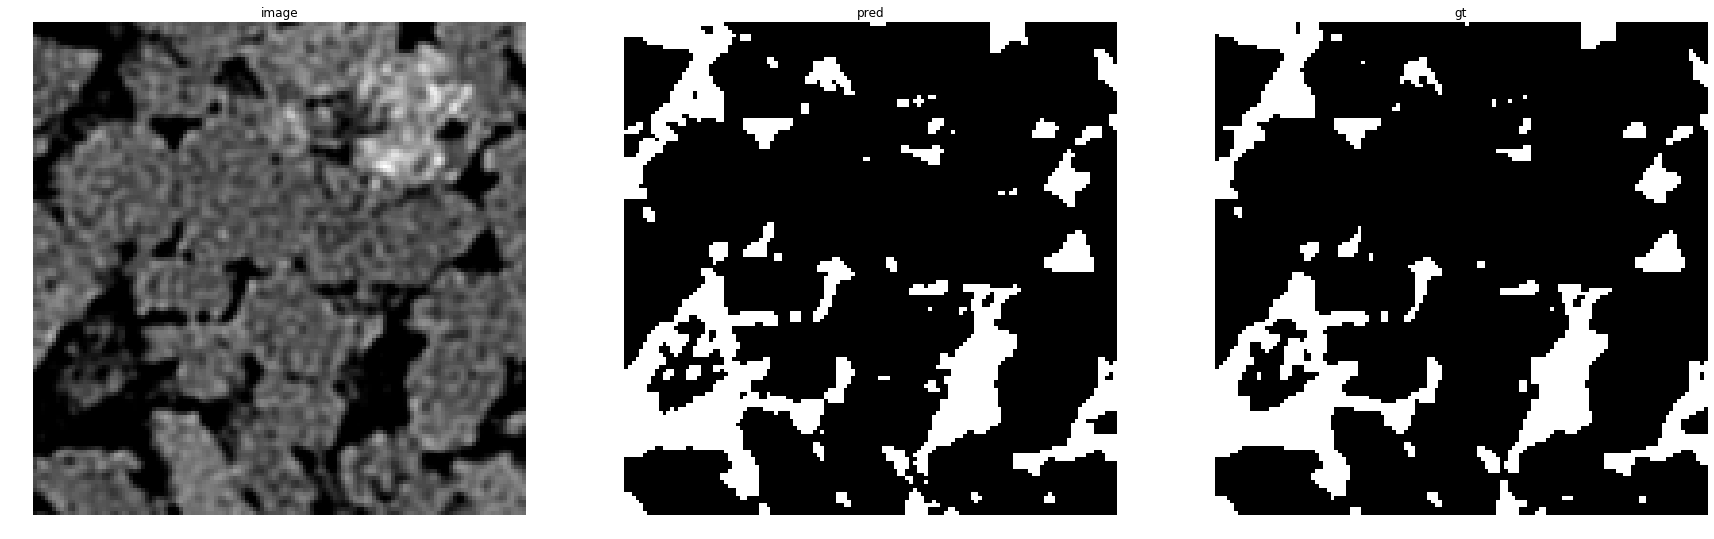

accuracy    : 0.97412109375
precision   : 0.8978430197723187
recall      : 0.9730519480519481
f1          : 0.9339358055468994
pr_auc      : 0.9908334442681829
iou         : 0.8760596316866414


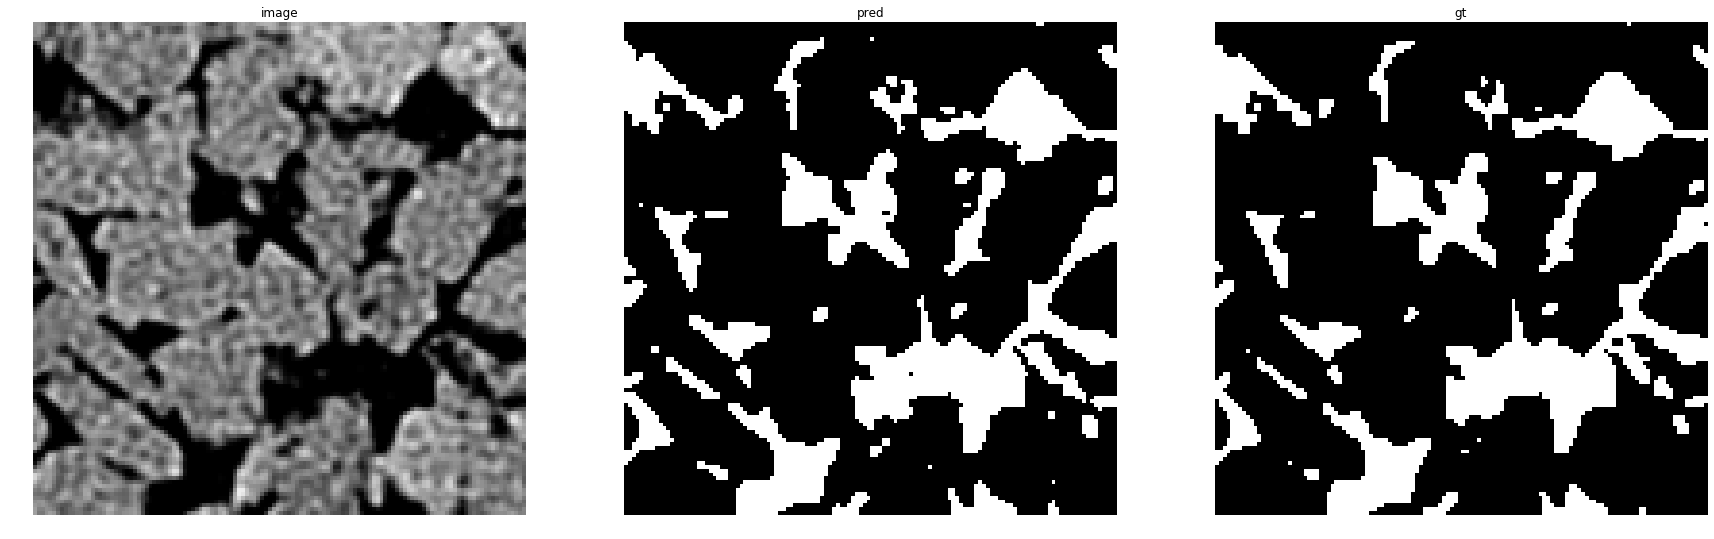

accuracy    : 0.97540283203125
precision   : 0.9088376804254241
recall      : 0.9881607929515418
f1          : 0.9468407861759661
pr_auc      : 0.9959037809012593
iou         : 0.8990480961923848


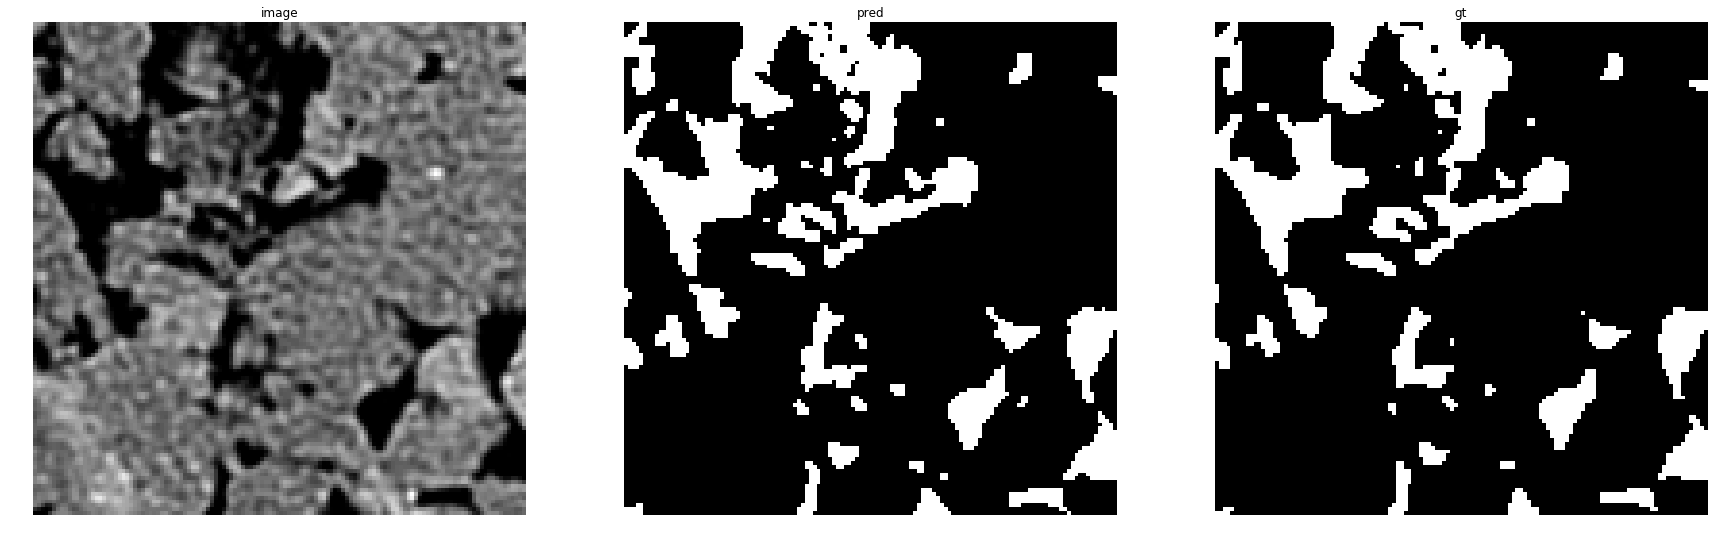

accuracy    : 0.97900390625
precision   : 0.9144305307096005
recall      : 0.9817541613316261
f1          : 0.9468971904908923
pr_auc      : 0.9952218674131309
iou         : 0.8991498094400469


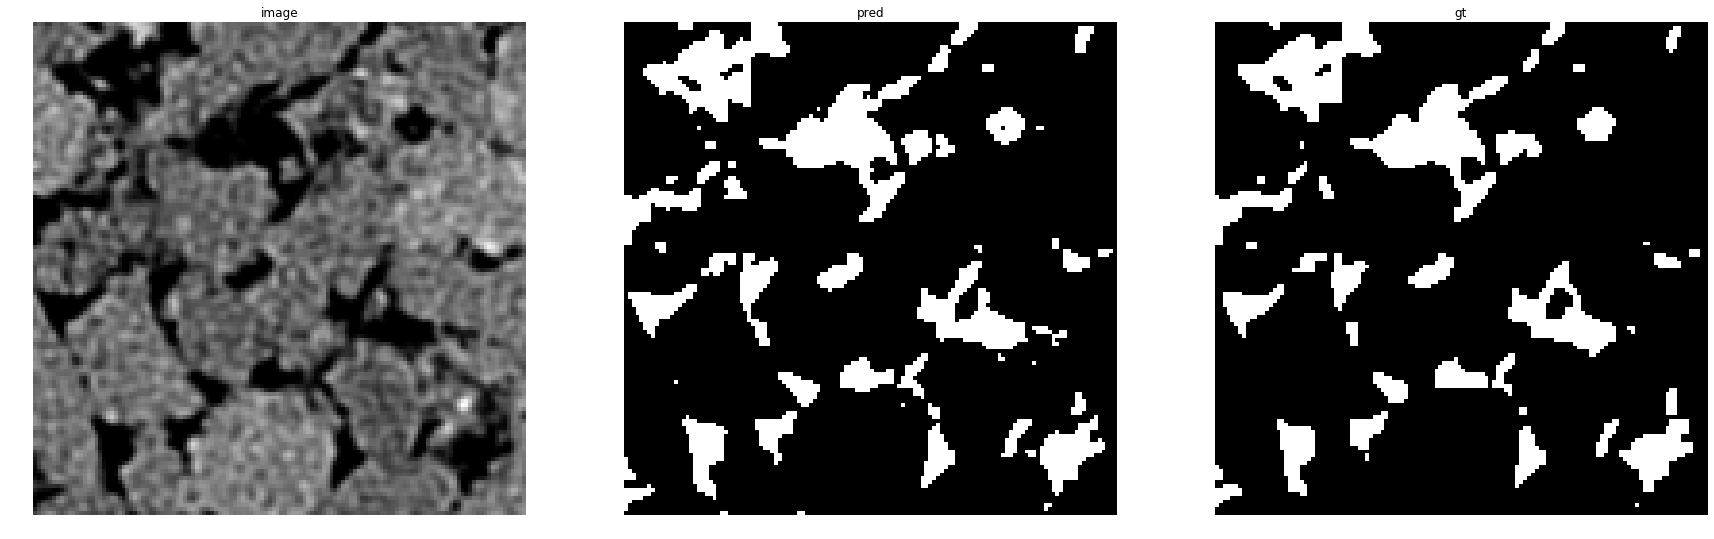

accuracy    : 0.97552490234375
precision   : 0.8814709032488397
recall      : 0.9728132387706856
f1          : 0.9248923019292002
pr_auc      : 0.9910678690922682
iou         : 0.8602787456445993


In [27]:
for stack_name, dataloader_test in dataloaders_test.items():
    cnt = to_plot
    
    stack_name = os.path.split(stack_name)[-1]
    dir_path = os.path.join(os.path.abspath('.'), 'samples', stack_name)
    if stack_name not in os.listdir(os.path.join('.', 'samples')):
        os.mkdir(dir_path)
    
    for samples, masks in dataloader_test:

        preds = model(torch.from_numpy(samples).to(device)).cpu().data.numpy()

        for sample, mask, pred in list(zip(samples, masks, preds))[:cnt]:
            img_path = os.path.join('.', 'samples', stack_name, '{}.png'.format(cnt))
            plot_sample(sample[0], mask, pred, threshold, metrics, img_path)
            cnt -= 1
            
        if cnt ==0:
            break

## Make prediction for particular stack

In [28]:
stack_name = 'carbRNF'

In [29]:
stack = Stack.read_from_source('../../data/{}'.format(stack_name))

700it [00:00, 791.55it/s]
100%|██████████| 700/700 [00:07<00:00, 107.37it/s]


In [30]:
predicted_stack = stack.apply(
    model, 
    patch_sizes=(128, 128, 1), 
    bs=32, num_workers=8, device='cuda:0',
    threshold=None)

25200it [00:00, 239725.61it/s]
25200it [02:01, 207.15it/s]
100%|██████████| 25200/25200 [00:08<00:00, 3127.77it/s]


In [34]:
iou(np.where(predicted_stack.targets == 255, 0, 1).astype(np.uint8), 
    predicted_stack.preds, 
    mode='stack',
    threshold=0.4)

0.8293491089636903

In [35]:
iou(np.where(predicted_stack.targets == 255, 0, 1).astype(np.uint8), 
    predicted_stack.preds, 
    mode='stack',
    threshold=0.3)

0.811955199412253

In [36]:
iou(np.where(predicted_stack.targets == 255, 0, 1).astype(np.uint8), 
    predicted_stack.preds, 
    mode='stack',
    threshold=0.6)

0.8529497099120933

In [37]:
iou(np.where(predicted_stack.targets == 255, 0, 1).astype(np.uint8), 
    predicted_stack.preds, 
    mode='stack',
    threshold=0.5)

0.8427241487869485

In [38]:
iou(np.where(predicted_stack.targets == 255, 0, 1).astype(np.uint8), 
    predicted_stack.preds, 
    mode='stack',
    threshold=0.7)

0.8592262372963283

In [42]:
f1(np.where(predicted_stack.targets == 255, 0, 1).astype(np.uint8), 
    predicted_stack.preds, 
    mode='stack',
    threshold=0.8)

0.9232196500046815

In [7]:
from torch.optim import AdamW

In [ ]:
AdamW()

In [31]:
for k, v in metrics.items():
    print('{:12}: {:.6f}'.format(k, 
                                 v(np.where(predicted_stack.targets == 255, 0, 1).astype(np.uint8), 
                                    predicted_stack.preds, 
                                    mode='stack')))

accuracy    : 0.979874
precision   : 0.884479
recall      : 0.946953
f1          : 0.914650
pr_auc      : 0.983288
iou         : 0.842724


In [29]:
for k, v in metrics.items():
    print('{:12}: {:.6f}'.format(k, 
                                 v(np.where(predicted_stack.targets == 255, 0, 1).astype(np.uint8), 
                                    predicted_stack.preds, 
                                    mode='stack')))

accuracy    : 0.975688
precision   : 0.989578
recall      : 0.794883
f1          : 0.881609
pr_auc      : 0.985471
iou         : 0.788284


In [31]:
for k, v in metrics.items():
    print('{:12}: {:.6f}'.format(k, 
                                 v(np.where(predicted_stack.targets == 255, 0, 1).astype(np.uint8), 
                                    predicted_stack.preds, 
                                    mode='stack')))

accuracy    : 0.977841
precision   : 0.989453
recall      : 0.814097
f1          : 0.893250
pr_auc      : 0.982144
iou         : 0.807093


In [14]:
for ps, d in zip([(128, 128, 1), (128, 1, 128), (1, 128, 128)], ['z', 'y', 'x']):
    predicted_stack = stack.apply(
        model, 
        patch_sizes=ps, 
        bs=32, num_workers=8, device='cuda:0',
        threshold=None)
    predicted_stack.dump('./{}_{}'.format(stack_name, d), features=False, targets=True, preds=True)

25200it [00:00, 238496.09it/s]
25200it [01:58, 212.35it/s]
  0%|          | 0/700 [00:00<?, ?it/s]


AttributeError: 'numpy.ndarray' object has no attribute 'cast'

In [1]:
import torch

In [2]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [45]:
from stack_segmentation.loss import make_loss

In [47]:
foo = make_loss(weight=[1, 10], loss_list=[('BCE', 0.5), ('Dice', 0.5)], device='cpu')

In [40]:
device='cpu'

In [41]:
from torch import nn
weight=[1, 10]
if weight is not None:
    weight = torch.FloatTensor(weight).to(device)
criterion = nn.CrossEntropyLoss(weight=weight)

In [49]:
criterion(b, a)

tensor(0.7139)

In [52]:
from stack_segmentation.loss import dice_coef_loss

In [54]:
dice_coef_loss(b, a) * 0.5 + 0.5 * criterion(b, a)

tensor(0.8570)

In [48]:
foo(b, a)

tensor(0.8570)

In [37]:
a = torch.randint(low=0, high=1, size=(32, 128, 128), dtype=torch.long)
b = torch.rand((32, 2, 128, 128))

In [26]:
def dice_coef(y_pred, y_true, smooth=1.0):
    intersection = (y_true * y_pred[:, 1]).sum()
    return (2. * intersection + smooth) / (y_true.sum() + y_pred[:, 1].sum() + smooth)

In [22]:
c = a * b[:, 1]

In [24]:
c.sum()

tensor(130931.9609)

In [27]:
dice_coef(b, a)

tensor(0.4998)